<a href="https://colab.research.google.com/github/jalonzoh/Challenge-Telecom-X---Parte-2/blob/main/ChallengeTelecomXParte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font> **Proyecto Telecom X - Parte 2 - Evasion de clientes** </font>

## <font color='#b0b0b0'>**Índice**</font>

1. Descripción del proyecto
2. Importación de librerías y configuraciones
    * Importación de librerías
    * Paths
    * Configuraciones
    * Funciones
3. Preprocesamiento de datos
    * Encoding de variables categóricas
    * Normalización de datos
    * Correlación entre variables
    * Análisis de multicolinealidad
    * Análisis dirigido
4. Modelado de datos
    * Train Test split
    * Escalado de variables numéricas
    * Balance del dataset
    * Baseline Model - Decision Tree Classifier
    * Random Forest Classifier
    * Logistic Regression
    * K-Nearest Neighbors
    * XGBoost Classifier
    * Support Vector Machine
5. Evaluación Best Models
    * Métricas Generales
    * Subajuste (Underfitting) y Sobreajuste (Overfitting)
    * Matrices de confusión
    * Importancias y Coeficientes
6. Champion Model
7. Pipeline de prueba en entorno productivo
    * Generación de datos artificiales
    * Pipeline de prueba

# <font color='#5a9bd4'>**1. Descripción del proyecto**</font>

La empresa quiere anticiparse al problema de la evasión de clientes por lo que se creara diferentes tipos de modelos y se eligira a la mejor en base a los resultados obtenidos, para lo cual se realizo lo siguientes pasos:

* Preparación de datos (tratamiento, codificación, normalización).
* Análisis de correlación y selección de variables.
* Entrenar varios modelos de clasificación, evaluar el rendimiento mediante distintas métricas e interpretar los resultados de cada uno de ellos.
* Evitar que el modelo presente sesgos.
* Mecionar las conclusiones de los principales factores que influyen en la evasión de cliente.

# <font color='#5a9bd4'>**2. Importación de librerías y configuraciones**</font>

## <font color='#ebac3a'>**Librerías a usar en el Modelado**</font>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import warnings
import requests
import pickle

from timeit import default_timer as timer
from datetime import datetime

from pathlib import Path
from typing import Tuple, Callable, List

import imblearn
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTENC

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

import xgboost
from xgboost import XGBClassifier

import matplotlib
import sklearn

In [2]:
# Verificando la version de las Librerias
print(f'numpy=={np.__version__}')
print(f'pandas=={pd.__version__}')
print(f'matplotlib=={matplotlib.__version__}')
print(f'seaborn=={sns.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'imblearn=={sklearn.__version__}')
print(f'xgboost=={xgboost.__version__}')

numpy==2.0.2
pandas==2.2.2
matplotlib==3.10.0
seaborn==0.13.2
scikit-learn==1.6.1
imblearn==1.6.1
xgboost==3.0.4


## <font color='#ebac3a'>**Colores**</font>

In [3]:
# Definir los colores personalizados
custom_colors = [
    '#4682b4', '#5a9bd4', '#2e6eab', '#1f4e79',  # Azules
    '#6a3fa0', '#8b5fc4', '#4f2d84', '#381c66',  # Púrpuras
    '#ebac3a', '#d99a2e', '#c48824', '#b0771b',  # Cremas
    '#e9611d', '#f07c3e', '#cc4e0f', '#a53d0c',  # Naranjas
]

# Crear el colormap personalizado
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)

## <font color='#ebac3a'>**Funciones**</font>

In [4]:
def boxplot_churn(df: pd.DataFrame,
                  ycol: str,
                  ylabel: str=None,
                  title_translate: str=None):

    if ylabel is None:
        ylabel = ycol
    if title_translate is None:
        title_translate = ycol

    fig, ax = plt.subplots(figsize=(8, 5))

    ax = sns.boxplot(data=df, x='Churn', y=ycol, hue='Churn', palette=None)
    plt.title(f'Distribución de {title_translate} según\nEvasión (Churn) de clientes', fontsize=18, pad=20)
    plt.xlabel('Churn', fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.xticks(fontsize=13)
    plt.grid(True)

    fig.savefig(f'boxplot_Churn_{ycol}.png',
                transparent=False,
                dpi=300,
                bbox_inches='tight')
    plt.show()
    return fig


def metricas_evaluacion(modelo,
                       x_test: pd.core.frame.DataFrame,
                       y_test: pd.core.series.Series,
                       nombre: str,
                       conjunto: str,
                       umbral: float=None):

    if umbral == None:
        metricas = {}
        y_pred = modelo.predict(x_test)
        metricas['Model'] = nombre
        metricas['Dataset'] = conjunto
        metricas['Accuracy'] = np.round(accuracy_score(y_test, y_pred), 4)
        metricas['Precision'] = np.round(precision_score(y_test, y_pred), 4)
        metricas['Recall'] = np.round(recall_score(y_test, y_pred), 4)
        metricas['F1-score'] = np.round(f1_score(y_test, y_pred), 4)
        if hasattr(modelo, "predict_proba"):
            y_proba = modelo.predict_proba(x_test)[:, 1]
            metricas['AUC'] = np.round(roc_auc_score(y_test, y_proba), 4)
        else:
            metricas['AUC'] = '---'
        metricas['Umbral'] = 0.50
    else:
        if hasattr(modelo, "predict_proba"):
            metricas = {}
            probs = modelo.predict_proba(x_test)[:, 1]
            y_pred = (probs >= umbral).astype(int)
            metricas['Model'] = nombre
            metricas['Dataset'] = conjunto
            metricas['Accuracy'] = np.round(accuracy_score(y_test, y_pred), 4)
            metricas['Precision'] = np.round(precision_score(y_test, y_pred), 4)
            metricas['Recall'] = np.round(recall_score(y_test, y_pred), 4)
            metricas['F1-score'] = np.round(f1_score(y_test, y_pred), 4)
            metricas['AUC'] = np.round(roc_auc_score(y_test, probs), 4)
            metricas['Umbral'] = umbral
        else:
            raise ValueError('El modelo no cuenta con el método "predict_proba"')

    return metricas

def cv_score_interval(results,
                      nombre: str,
                      score:str='Recall'):

    score_mean = np.round(results['test_score'].mean(), 4)
    score_stdev = np.round(results['test_score'].std(), 4)
    lower_b = np.round(score_mean - 2 * score_stdev, 4)
    upper_b = np.round(min(1, score_mean + 2 * score_stdev), 4)

    print(f'Recall promedio de {nombre}: {score_mean}')
    print(f'Desviación estándar del Recall de {nombre}: {score_stdev}')
    print(f'El {score} de {nombre} estará entre [{lower_b:.4f},{upper_b:.4f}] con un 95% de confianza')

def plot_conf_mat(model,
                  x: pd.core.frame.DataFrame,
                  y: pd.core.series.Series,
                  name: str,
                  save: str,
                  umbral: float=None):

    if umbral == None:
        y_pred = model.predict(x)
    else:
        y_probs = model.predict_proba(x)[:, 1]
        y_pred = (y_probs >= umbral).astype(int)

    confmat = confusion_matrix(y_true=y, y_pred=y_pred)

    confmat_plot = ConfusionMatrixDisplay(confmat, display_labels=['Retención', 'Evasión'])

    fig, ax = plt.subplots(figsize=(10,6))
    confmat_plot.plot(ax=ax, cmap=custom_cmap, colorbar=False, text_kw={'color': 'black', 'fontweight': 'bold'})

    plt.title(name, fontsize=18, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    plt.tick_params(axis='both', labelsize=13)

    plt.subplots_adjust(right=0.88)
    plt.tight_layout(pad=3.0)

    fig.savefig(f'confmat_{save}.png',
                transparent=True,
                dpi=300,
                bbox_inches=None)

In [5]:
def plot_umbrales(modelo,
                  score: str,
                  x: pd.core.frame.DataFrame,
                  y: pd.core.series.Series,
                  caja_x: float,
                  caja_y: float,
                  nombre: str):

    umbrales = np.linspace(0.0, 1.0, 100)
    scores = []
    if hasattr(modelo, 'predict_proba'):
        modelo_pred_proba = modelo.predict_proba(x)[:, 1]
    else:
        raise ValueError('El modelo no cuenta con el método predict_proba')
    for t in umbrales:
        y_pred = (modelo_pred_proba >= t).astype(int)
        scores.append(f1_score(y, y_pred))

    fig, ax = plt.subplots(figsize=(7,5))
    plt.suptitle(nombre, fontsize=18, fontweight='bold')

    plt.plot(umbrales, scores, label='F1-Score', color='#4682b4')
    plt.title(f'{score} vs Umbral', fontsize=15)
    plt.xlabel("Umbral de decisión", fontsize=13)
    plt.ylabel(score, fontsize=13)

    plt.grid(True, alpha=0.3)


    idx_max = np.argmax(scores)
    mejor_umbral = umbrales[idx_max]
    mejor_valor = scores[idx_max]
    plt.scatter(mejor_umbral, mejor_valor, color='#ebac3a', zorder=5)
    plt.annotate(
        f'Umbral óptimo\nsegún F1-score: {mejor_umbral:.2f}',
        xy=(mejor_umbral, mejor_valor),
        xytext=(mejor_umbral + caja_x, mejor_valor - caja_y),
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3),
        fontsize=9
    )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return fig

def plot_precision_recall_curve(modelo,
                                x: pd.core.frame.DataFrame,
                                y: pd.core.series.Series,
                                nombre:str):

    y_pred = modelo.predict_proba(x)[:, 1]

    # Calcular precisión, recall y umbrales
    precision, recall, thresholds = precision_recall_curve(y, y_pred)

    # Graficar la curva
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', color='#4682b4', label='Baseline Model')
    plt.title(f'{nombre}: Curva Precision-Recall', fontsize=18, fontweight='bold')
    plt.xlabel('Recall', fontsize=13)
    plt.ylabel('Precision', fontsize=13)

    plt.grid(True, alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

def plot_analisis_variables(df: pd.core.frame.DataFrame,
                            analisis: str,
                            nombre_modelo: str,
                            save: str,
                            n_vars: int= None,
                            space: float=0.5):

    if analisis != 'Coeficiente' and analisis != 'Importancia':
        raise ValueError('Esta función acepta solo los valores "Importancia" o "Coeficiente" para el parámetro <analisis>')

    if n_vars:
        if analisis == 'Coeficiente':
            n_vars = int(n_vars / 2)
            df1 = df.head(n_vars)
            df2 = df.tail(n_vars)
            df = pd.concat([df1, df2])
        else:
            df = df.head(n_vars)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.barplot(data=df, x=analisis, y='Feature', orient='h', hue=analisis, palette=custom_cmap)
    plt.title(f'{analisis}s de Variables - {nombre_modelo}', fontsize=18, loc='left')
    plt.xlabel(analisis, fontsize=16)
    plt.ylabel('Feature', fontsize=16)


    x_max = df[analisis].max()
    x_min = df[analisis].min()

    for p in ax.patches:
        width = p.get_width()
        y = p.get_y() + p.get_height() / 2
        if width != 0:
            if analisis == 'Coeficiente':
                if width > 0:
                    ax.text(
                        (width + (x_max * space)), y,
                        f'{width:.4f}',
                        ha='right', va='center',
                        fontsize=9, color='black', fontweight='bold')
                else:
                    ax.text(
                        (width - (x_max * space)), y,
                        f'{width:.4f}',
                        ha='left', va='center',
                        fontsize=9, color='black', fontweight='bold')
            else:
                ax.text(
                    (width + (x_max * space)), y,
                    f'{width*100:.2f}%',
                    ha='center', va='center',
                    fontsize=9, color='black', fontweight='bold'
                    )

    sns.despine()
    if analisis == 'Coeficiente':
        plt.xlim(x_min-1, x_max+1)
    plt.tight_layout()

    fig.savefig(f'{analisis}_variables_{save}.png',
                transparent=False,
                dpi=300,
                bbox_inches='tight')

    plt.show()

def generar_tabla(df,
                 title: str,
                 save: str,
                 figsize: Tuple=(8,6)):

    # Crear tabla para exportar como imagen
    fig, ax = plt.subplots(figsize=figsize)
    # Eliminar los ejes
    ax.axis('off')

    colors = ['#b0b0b0','#dcdcdc']


    color_order = []
    for i in range(len(df)):
        if i % 2 == 0:
            color_order.append(colors[0])
        else:
            color_order.append(colors[1])
    max_rate = max(df, key=lambda x: x[1])
    idx_max = df[df == max_rate].index[0]

    cols_names = df.columns
    cell_colors = [[color, color, color, color] for color in color_order]
    table = df.values.tolist()

    for row in table:
        row[1] = np.round(row[1], 4)
    tabla = ax.table(cellText=table,
                     colLabels=cols_names,
                     cellLoc='center',
                     loc='center',
                     colColours=['#ebac3a' for i in range(df.shape[0])],
                     cellColours=cell_colors)

    tabla.auto_set_font_size(False)
    for (row, col), cell in tabla.get_celld().items():
        cell.set_fontsize(10)

    plt.title(f'{title}', fontsize=18, fontweight='bold')

    # Escalar la tabla para mayor legibilidad
    tabla.scale(1, 2)

    plt.tight_layout()

    fig.savefig(f'{save}.png', transparent=True, dpi=300, bbox_inches='tight')


    plt.show()

# <font color='#5a9bd4'>**3. Preprocesamiento de datos**</font>

Se incluira los **valores atípicos** de la etapa anterior identificados  en la exploración y análisis de la base de datos, estos representan comportamientos importantes.

In [6]:
URL = 'https://raw.githubusercontent.com/jalonzoh/Challenge-Telecom-X---Parte-2/refs/heads/main/TelecomX_dataLimpio.json'

datos = pd.read_json(URL)
datos.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesDaily,ChargesMonthly,ChargesTotal,Churn
0,0002-ORFBO,Female,No,Yes,Yes,9,Yes,No,DSL,No,...,Yes,Yes,No,One year,Yes,Mailed check,2.19,65.6,593.30,No
1,0003-MKNFE,Male,No,No,No,9,Yes,Yes,DSL,No,...,No,No,Yes,Month-to-month,No,Mailed check,2.00,59.9,542.40,No
2,0004-TLHLJ,Male,No,No,No,4,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,2.46,73.9,280.85,Yes
3,0011-IGKFF,Male,Yes,Yes,No,13,Yes,No,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,3.27,98.0,1237.85,Yes
4,0013-EXCHZ,Female,Yes,Yes,No,3,Yes,No,Fiber optic,No,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,2.80,83.9,267.40,Yes


***Nota**: Se eliminarán las varialbes `CustomerID` ya que esta no aporta poder predictivo debido a que es un simple identificador de cliente, y `ChargesDaily` ya que esta variable fue agregada simplemente al dividir `ChargesMonthly` en 30 días.*

In [67]:
try:
    URL = 'https://raw.githubusercontent.com/jalonzoh/Challenge-Telecom-X---Parte-2/refs/heads/main/no_clientes_importantes.json'
    outliers = pd.read_json(URL)
    # Concatenar ambos DafaFrame verticalmente
    datos = pd.concat([datos, outliers], axis=0)
    # Mezclar los datos ya que sino quedaran los outliers ubicados todos al final
    datos = datos.sample(frac=1, random_state=42).reset_index(drop=True)
except Exception as e:
    print('No se encontró el archivo correspondiente, o hubo un problema al cargar los datos')
    print(f'Error: {e}')

In [68]:
datos = datos.drop(['CustomerID', 'ChargesDaily'], axis=1)

In [69]:
datos.describe()

,Tenure,ChargesMonthly,ChargesTotal
count,7261.000000,7261.000000,7261.000000
mean,33.317174,65.944195,2411.553505
std,24.796551,30.408742,2357.947962
min,0.000000,18.250000,0.000000
25%,9.000000,39.200000,417.650000
50%,30.000000,71.350000,1462.050000
75%,57.000000,91.000000,4089.450000
max,72.000000,118.750000,8684.800000


In [70]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7261 entries, 0 to 7260
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            7261 non-null   object 
 1   SeniorCitizen     7261 non-null   object 
 2   Partner           7261 non-null   object 
 3   Dependents        7261 non-null   object 
 4   Tenure            7261 non-null   int64  
 5   PhoneService      7261 non-null   object 
 6   MultipleLines     7261 non-null   object 
 7   InternetService   7261 non-null   object 
 8   OnlineSecurity    7261 non-null   object 
 9   OnlineBackup      7261 non-null   object 
 10  DeviceProtection  7261 non-null   object 
 11  TechSupport       7261 non-null   object 
 12  StreamingTV       7261 non-null   object 
 13  StreamingMovies   7261 non-null   object 
 14  Contract          7261 non-null   object 
 15  PaperlessBilling  7261 non-null   object 
 16  PaymentMethod     7261 non-null   object 


## <font color='#ebac3a'>**Encoding de variables categóricas**</font>

In [71]:
datos.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'ChargesMonthly', 'ChargesTotal', 'Churn'],
      dtype='object')

In [72]:
X = datos.drop('Churn', axis=1)
y = datos['Churn']

In [73]:
X_linear = X.copy()
y_linear = y.copy()

In [74]:
X

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesMonthly,ChargesTotal
0,Female,Yes,Yes,No,32,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,93.20,2931.00
1,Male,No,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),44.05,44.05
2,Female,No,No,No,10,Yes,No,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Bank transfer (automatic),80.25,846.00
3,Female,No,Yes,No,59,Yes,Yes,Fiber optic,Yes,Yes,No,No,Yes,No,Month-to-month,Yes,Electronic check,94.75,5597.65
4,Female,No,No,No,38,Yes,No,No,No,No,No,No,No,No,One year,No,Mailed check,20.05,678.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7256,Female,No,Yes,Yes,72,Yes,Yes,No,No,No,No,No,No,No,Two year,No,Bank transfer (automatic),25.10,1857.85
7257,Male,No,No,No,1,Yes,No,No,No,No,No,No,No,No,Month-to-month,No,Mailed check,20.20,20.20
7258,Male,No,Yes,No,27,Yes,No,DSL,No,Yes,No,Yes,No,No,Month-to-month,Yes,Electronic check,53.80,1389.85
7259,Female,Yes,No,No,32,Yes,No,DSL,No,Yes,No,Yes,No,No,Month-to-month,No,Bank transfer (automatic),54.65,1830.10


In [75]:
categoricas = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']

In [76]:
one_hot = make_column_transformer(
                    (OneHotEncoder(drop='if_binary'), categoricas),
                    remainder='passthrough',
                    sparse_threshold=0,
                    force_int_remainder_cols=False
)

one_hot_linear = make_column_transformer(
                    (OneHotEncoder(drop='first'), categoricas),
                    remainder='passthrough',
                    sparse_threshold=0,
                    force_int_remainder_cols=False
)

label_encoder = LabelEncoder()

In [77]:
X = one_hot.fit_transform(X)
X_linear = one_hot_linear.fit_transform(X_linear)

y = label_encoder.fit_transform(y)
y_linear = label_encoder.fit_transform(y_linear)

In [79]:
columnas = one_hot.get_feature_names_out()

columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

El conjunto de datos **df**: contendrá las variables categóricas codificadas y variables numéricas sin escalar.

In [80]:
df = pd.DataFrame(X, columns=columnas_encoded)
df_y = pd.DataFrame(y, columns=['Churn'])
df = pd.concat([df, df_y], axis=1)
df.head()

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal,Churn
0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,32.0,93.20,2931.00,1
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,44.05,44.05,0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,10.0,80.25,846.00,1
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,59.0,94.75,5597.65,0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,38.0,20.05,678.20,0


In [81]:
columnas = one_hot_linear.get_feature_names_out()

columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

El conjunto de datos **df_linear**: contendrá las variables categóricas codificadas y variables numéricas escaladas.

In [82]:
df_linear = pd.DataFrame(X_linear, columns=columnas_encoded)
df_y_linear = pd.DataFrame(y_linear, columns=['Churn'])
df_linear = pd.concat([df_linear, df_y_linear], axis=1)
df_linear.head()

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal,Churn
0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,32.0,93.20,2931.00,1
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,44.05,44.05,0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,10.0,80.25,846.00,1
3,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,59.0,94.75,5597.65,0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,38.0,20.05,678.20,0


In [83]:
df.rename(columns={'InternetService_No': 'NoInternetService'}, inplace=True)
df_linear.rename(columns={'InternetService_No': 'NoInternetService'}, inplace=True)

El conjunto de datos **df_scale**: contendrá las variables categóricas codificadas  y variables numéricas escaladas.

In [84]:
df_scale = df.copy()

## <font color='#ebac3a'>**Normalización de datos**</font>

In [85]:
def bin_width(df, columna):
    n = df.shape[0]
    iqr = df[columna].quantile(0.75) - df[columna].quantile(0.25)

    bin_width = 2 * (iqr / np.cbrt(n))
    return bin_width

In [86]:
scaler_tenure = StandardScaler()
scaler_chargesmonthly = StandardScaler()
scaler_chargestotal = StandardScaler()

In [26]:
robust_tenure = RobustScaler()
robust_chargesmonthly = RobustScaler()
robust_chargestotal = RobustScaler()

#### **Tenure**

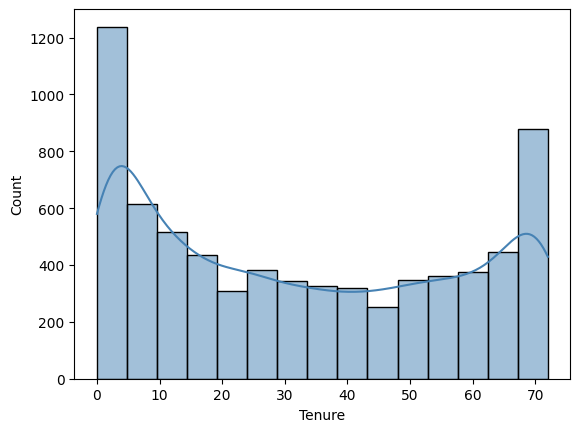

In [27]:
BIN_WIDTH = bin_width(df, 'Tenure')

sns.histplot(df['Tenure'], binwidth=BIN_WIDTH, color='#4682b4', kde=True)
plt.show()

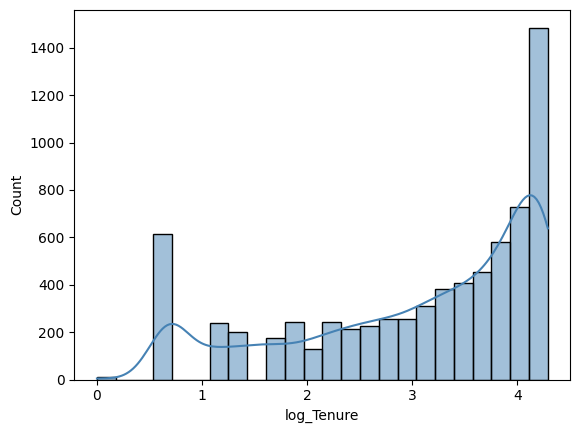

In [28]:
df['log_Tenure'] = np.log(df['Tenure'] + 1)
BIN_WIDTH = bin_width(df, 'log_Tenure')

sns.histplot(df['log_Tenure'], binwidth=BIN_WIDTH, color='#4682b4', kde=True)
plt.show()

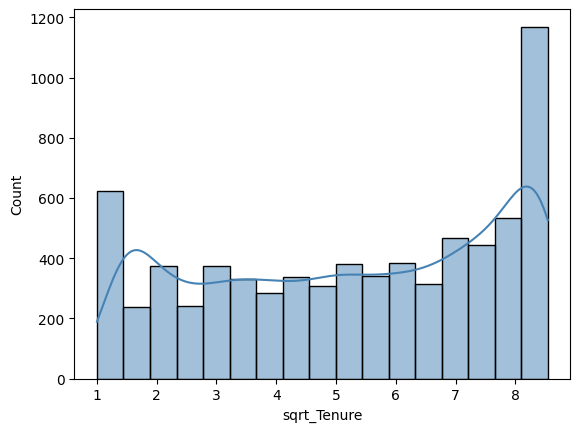

In [29]:
df['sqrt_Tenure'] = np.sqrt(df['Tenure'] + 1)
BIN_WIDTH = bin_width(df, 'sqrt_Tenure')

sns.histplot(df['sqrt_Tenure'], binwidth=BIN_WIDTH, color='#4682b4', kde=True)
plt.show()

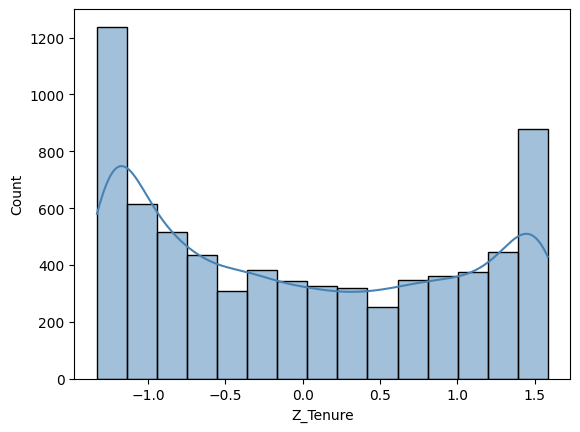

In [30]:
df['Z_Tenure'] = scaler_tenure.fit_transform(df[['Tenure']])
BIN_WIDTH = bin_width(df, 'Z_Tenure')

sns.histplot(df['Z_Tenure'], binwidth=BIN_WIDTH, color='#4682b4', kde=True)
plt.show()

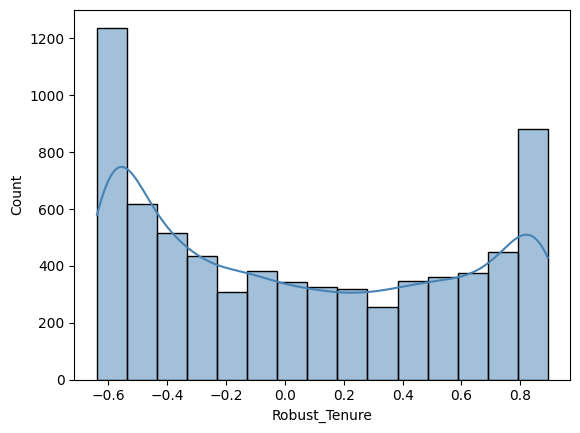

In [31]:
df['Robust_Tenure'] = robust_tenure.fit_transform(df[['Tenure']])
BIN_WIDTH = bin_width(df, 'Robust_Tenure')

sns.histplot(df['Robust_Tenure'], binwidth=BIN_WIDTH, color='#4682b4', kde=True)
plt.show()

#### **ChargesMonthly**

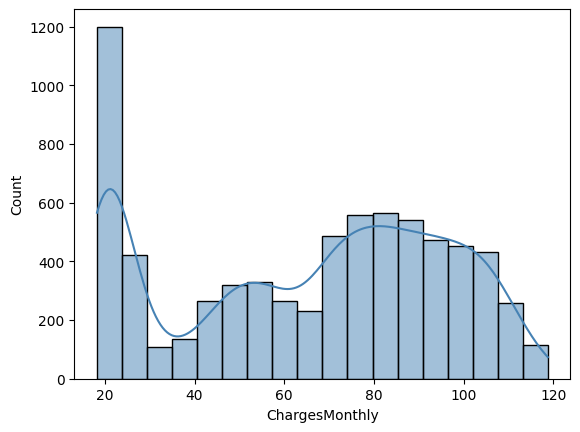

In [32]:
BIN_WIDTH = bin_width(df, 'ChargesMonthly')

sns.histplot(df['ChargesMonthly'], binwidth=BIN_WIDTH, color='#4682b4', kde=True)
plt.show()

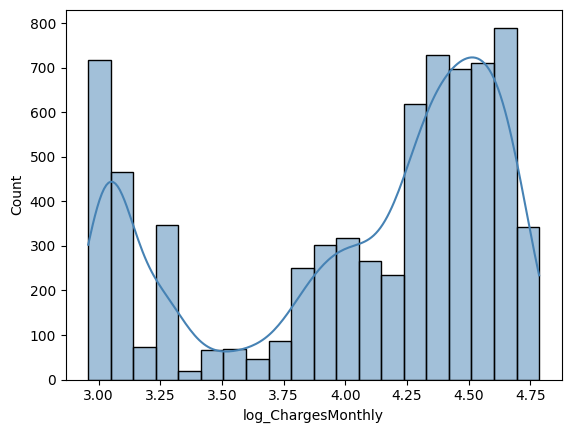

In [33]:
df['log_ChargesMonthly'] = np.log(df['ChargesMonthly'] + 1)
BIN_WIDTH = bin_width(df, 'log_ChargesMonthly')

sns.histplot(df['log_ChargesMonthly'], binwidth=BIN_WIDTH, color='#4682b4', kde=True)
plt.show()

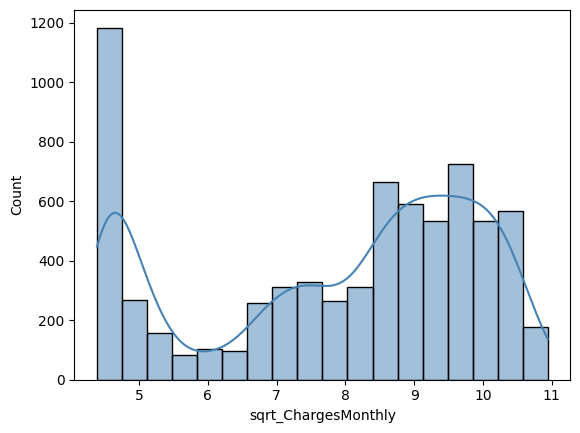

In [34]:
df['sqrt_ChargesMonthly'] = np.sqrt(df['ChargesMonthly'] + 1)
BIN_WIDTH = bin_width(df, 'sqrt_ChargesMonthly')

sns.histplot(df['sqrt_ChargesMonthly'], binwidth=BIN_WIDTH, color='#4682b4', kde=True)
plt.show()

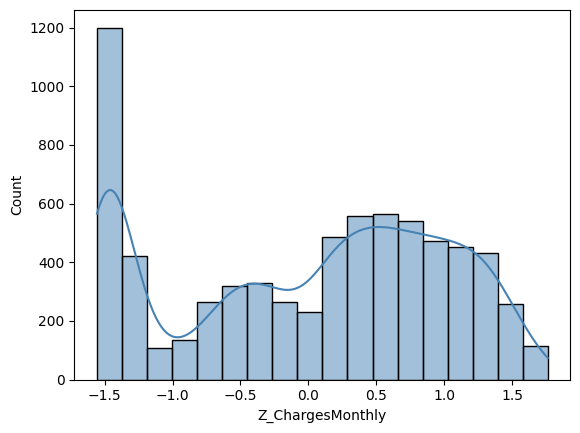

In [35]:
df['Z_ChargesMonthly'] = scaler_chargesmonthly.fit_transform(df[['ChargesMonthly']])
BIN_WIDTH = bin_width(df, 'Z_ChargesMonthly')

sns.histplot(df['Z_ChargesMonthly'], binwidth=BIN_WIDTH, color='#4682b4', kde=True)
plt.show()

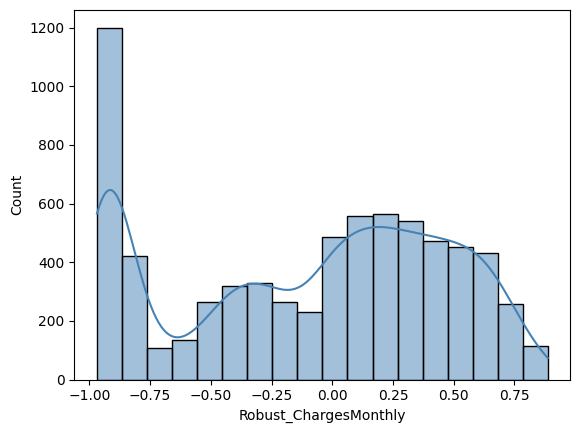

In [36]:
df['Robust_ChargesMonthly'] = robust_chargesmonthly.fit_transform(df[['ChargesMonthly']])
BIN_WIDTH = bin_width(df, 'Robust_ChargesMonthly')

sns.histplot(df['Robust_ChargesMonthly'], binwidth=BIN_WIDTH, color='#4682b4', kde=True)
plt.show()

#### **ChargesTotal**

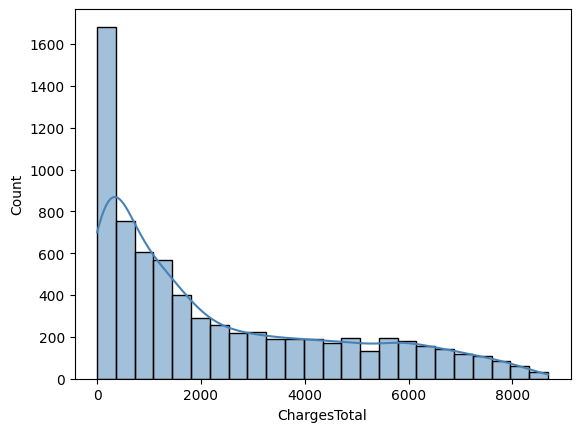

In [37]:
BIN_WIDTH = bin_width(df, 'ChargesTotal')

sns.histplot(df['ChargesTotal'], binwidth=BIN_WIDTH, color='#4682b4', kde=True)
plt.show()

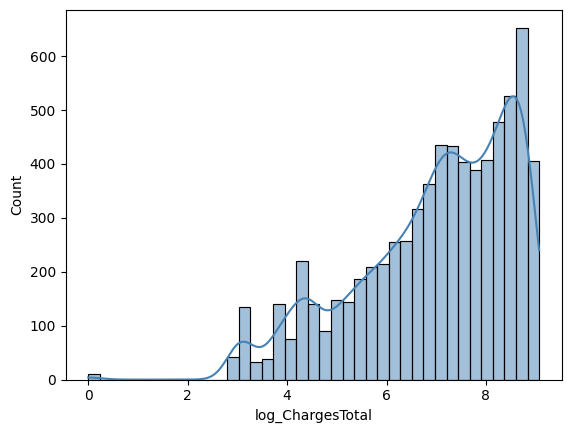

In [38]:
df['log_ChargesTotal'] = np.log(df['ChargesTotal'] + 1)
BIN_WIDTH = bin_width(df, 'log_ChargesTotal')

sns.histplot(df['log_ChargesTotal'], binwidth=BIN_WIDTH, color='#4682b4', kde=True)
plt.show()

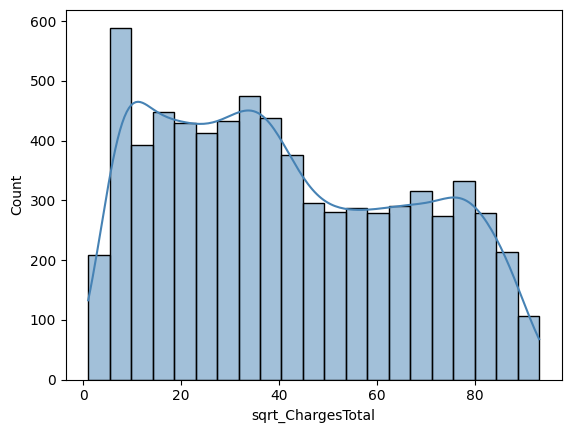

In [39]:
df['sqrt_ChargesTotal'] = np.sqrt(df['ChargesTotal'] + 1)
BIN_WIDTH = bin_width(df, 'sqrt_ChargesTotal')

sns.histplot(df['sqrt_ChargesTotal'], binwidth=BIN_WIDTH, color='#4682b4', kde=True)
plt.show()

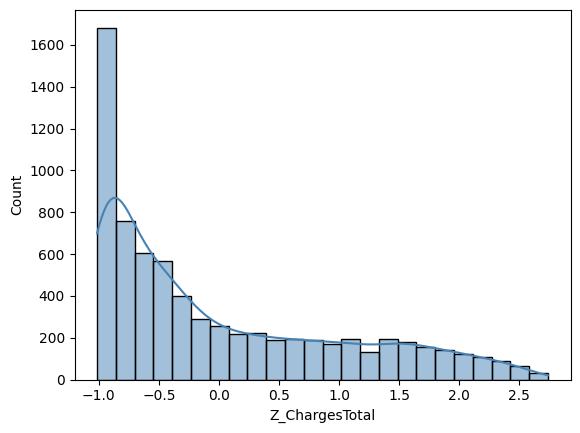

In [40]:
df['Z_ChargesTotal'] = scaler_chargestotal.fit_transform(df[['ChargesTotal']])
BIN_WIDTH = bin_width(df, 'Z_ChargesTotal')

sns.histplot(df['Z_ChargesTotal'], binwidth=BIN_WIDTH, color='#4682b4', kde=True)
plt.show()

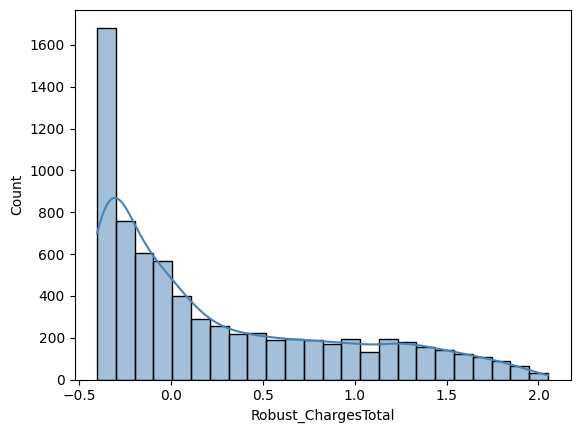

In [41]:
df['Robust_ChargesTotal'] = robust_chargestotal.fit_transform(df[['ChargesTotal']])
BIN_WIDTH = bin_width(df, 'Robust_ChargesTotal')

sns.histplot(df['Robust_ChargesTotal'], binwidth=BIN_WIDTH, color='#4682b4', kde=True)
plt.show()

### <font color='#8b5fc4'>**Observaciones: Normalización de datos**</font>

Se observa que ninguna de las transformaciones aplicadas consigue corregir la asimetría positiva de ChargesTotal.

Es por tal motivo que fueron incluidos los registros considerados outliers (clientes de alto valor que abandonaron la empresa), ya que resulta importante conocer que características comparten estos con aquellos de "menor valor".
Tenure y ChargesMonthly muestran una distribución bimodal que se mantiene en todas las transformaciones.


In [42]:
df = df.drop(['log_Tenure', 'sqrt_Tenure', 'Z_Tenure', 'Robust_Tenure',
              'log_ChargesMonthly', 'sqrt_ChargesMonthly', 'Z_ChargesMonthly', 'Robust_ChargesMonthly',
              'log_ChargesTotal', 'sqrt_ChargesTotal', 'Z_ChargesTotal', 'Robust_ChargesTotal'], axis=1)

In [43]:
df.shape

(7152, 27)

## <font color='#ebac3a'>**Correlación entre variables**</font>

In [44]:
corr = df.corr()

In [45]:
# Generar una máscara para el triángulo superior
mascara = np.zeros_like(corr, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

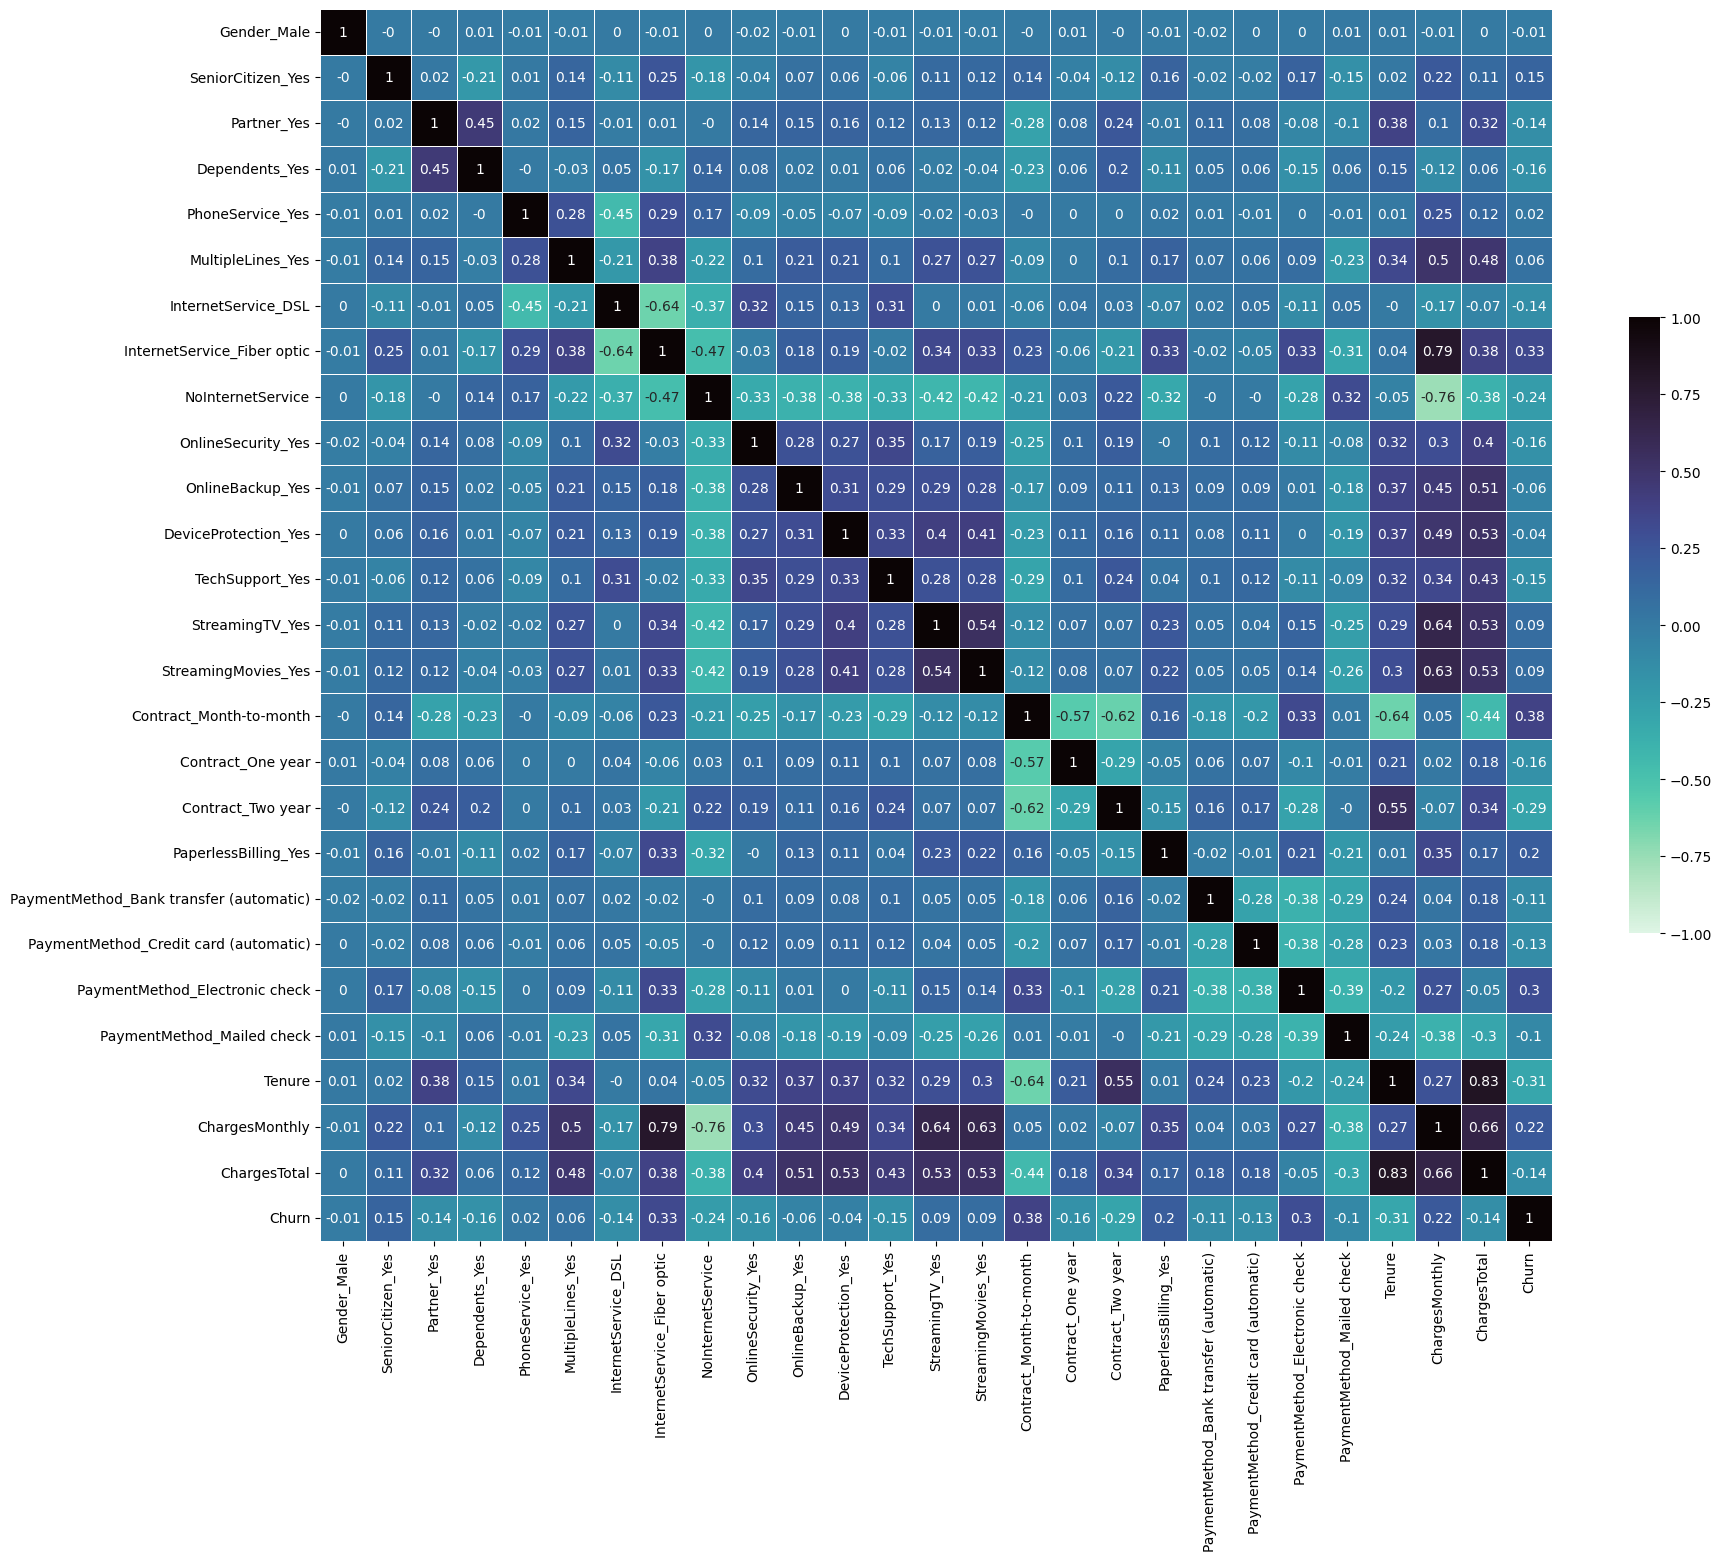

In [46]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(corr, 2), vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5}, cmap='mako_r')
plt.show()

Por la gran cantidad de variables, para reducir selecionaré aquellas que tiene una correlación absoluta con la Evasión mayor a 0.07

In [47]:
cols = corr.loc['Churn'].abs()[corr.loc['Churn'].abs() > 0.07].index
corr_selected = corr[cols].loc[cols]  # Subset del DataFrame completo

In [48]:
# Generar una máscara para el triángulo superior
mascara = np.zeros_like(corr_selected, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

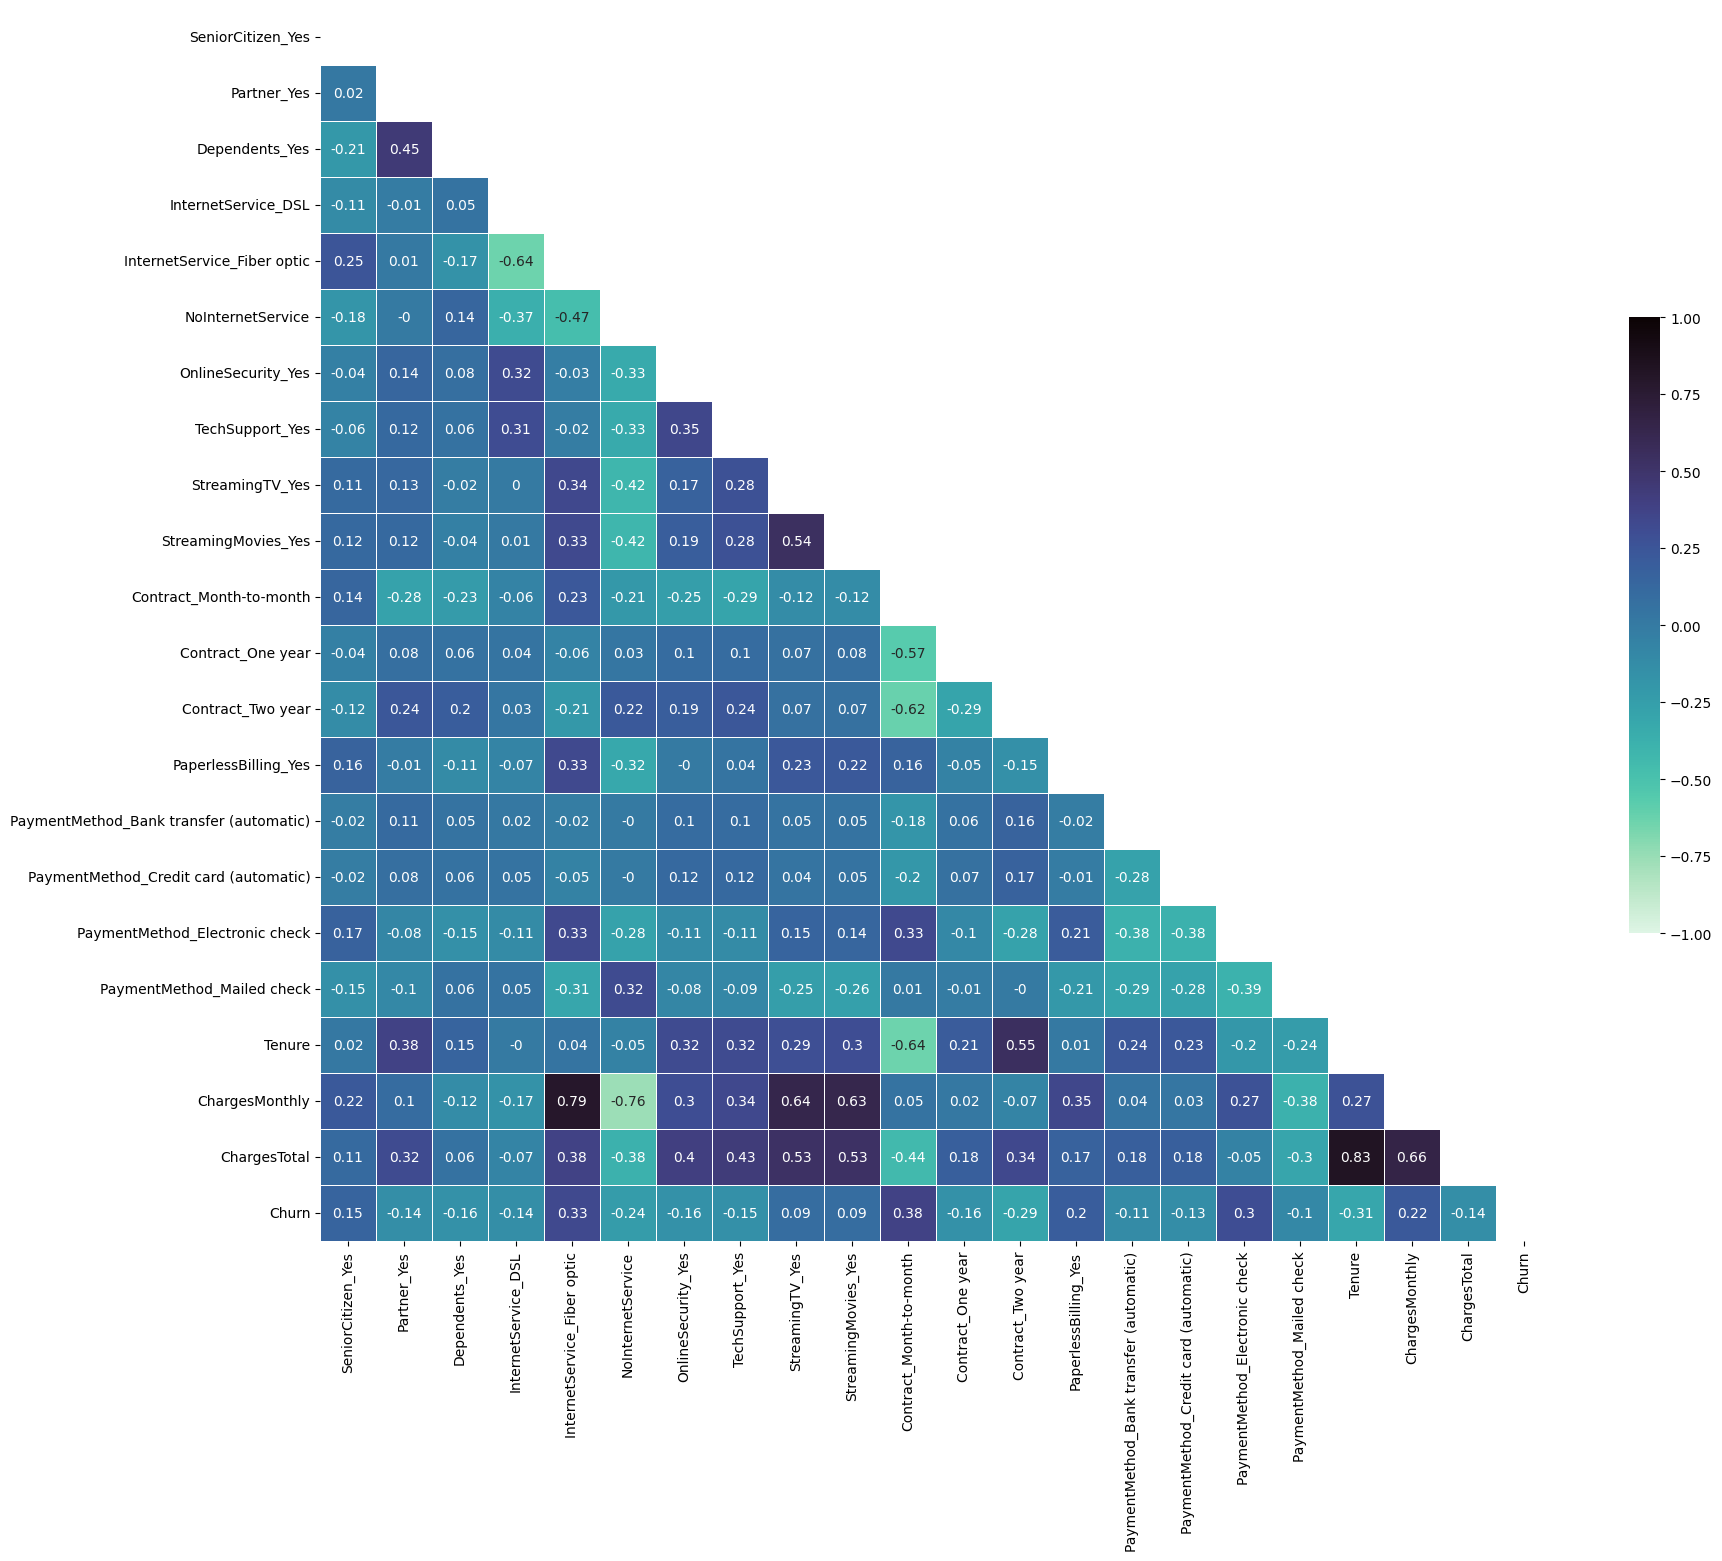

In [49]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(corr_selected, 2), mask=mascara, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5}, cmap='mako_r')
fig.savefig('corr_matrix.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

La relación positiva fuerte  entre ChargesTotal y Tenure. Para validar se realizara un análisis de colinealidad, a través de VIF.

## <font color='#ebac3a'>**Análisis de multicolinealidad**</font>

### <font color='#f07c3e'>**VIF 1**</font>

Variance Inflation Factor, en esencia, realiza una regresión lineal tomando cada variable explicativa como variable respuesta, y busca explicarla a través del resto de variables explicativas. Los valores aceptables suelen ser:

* 1 < VIF < 5 = **Aceptable**
* 5 < VIF < 10 = **La variable puede conservarse si se considera necesario**
* 10 < VIF = **Existe colinealidad fuerte entre dicha variable y alguna de las otras variables explicativas**

En los casos que exista colinealidad, dichas variables se descartan para no perjudicar al modelo.

Se utilizará la variable X_linear que fue codificada con `OneHotEncoder(drop='first')`, esto asegura que se descarte la primera categoría de cada feature al codificar las variables, evitando que se introduzca multicolinealidad manualmente al modelo.

Además, se escalarán las variables numéricas ya que dicho algoritmo, al realizar regresiones lineales, es sensible a la escala de los datos.

In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.preprocessing import RobustScaler

In [51]:
vif_robust_scaler = RobustScaler()

In [52]:
df_vif = df_linear.copy()

In [53]:
x_num = ['Tenure', 'ChargesMonthly', 'ChargesTotal']

X_vif_num = df_vif[x_num]

X_vif_num = vif_robust_scaler.fit_transform(X_vif_num)

df_vif[['Tenure_scaled', 'ChargesMonthly_scaled', 'ChargesTotal_scaled']] = X_vif_num

df_vif = df_vif.drop(['Tenure', 'ChargesMonthly', 'ChargesTotal'], axis=1)

In [54]:
X_vif = df_vif.drop('Churn', axis=1)

In [55]:
features = X_vif.columns

In [56]:
df_vif_1 = pd.DataFrame()
df_vif_1['Feature'] = features
df_vif_1['VIF'] = [vif(X_vif[features], i) for i in range(len(features))]

In [57]:
df_vif_1.sort_values('VIF', ascending=False)

,Feature,VIF
22,ChargesTotal_scaled,12.902310
21,ChargesMonthly_scaled,11.696381
4,PhoneService_Yes,10.048787
20,Tenure_scaled,7.750051
6,InternetService_Fiber optic,6.817227
7,NoInternetService,5.937551
15,Contract_Two year,3.436684
12,StreamingTV_Yes,3.055135
13,StreamingMovies_Yes,3.029339
16,PaperlessBilling_Yes,2.989310


Las variables, `ChargesTotal` y `ChargesMonthly` son las variables que presentan mayor valor de **VIF**.

|Feature	            |VIF      |
|-----------------------|---------|
|ChargesTotal_scaled	|12.902310|
|ChargesMonthly_scaled  |11.696381|

ChargesTotal es la acumulación por mes de `ChargesMonthly` de `Tenure`. Por lo que, se descartará ChargesTotal para re evaluar el resultado de **Variance Inflation Factor**.

### <font color='#f07c3e'>**VIF 2**</font>

In [58]:
X_vif = df_vif.copy()

In [59]:
X_vif = X_vif.drop(['ChargesTotal_scaled', 'Churn'], axis=1)

In [60]:
features = X_vif.columns
features

Index(['Gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_Fiber optic',
       'NoInternetService', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure_scaled', 'ChargesMonthly_scaled'],
      dtype='object')

In [61]:
df_vif_2 = pd.DataFrame()
df_vif_2['Feature'] = features
df_vif_2['VIF'] = [vif(X_vif[features], i) for i in range(len(features))]

In [62]:
df_vif_2.sort_values('VIF', ascending=False)

,Feature,VIF
21,ChargesMonthly_scaled,10.568394
4,PhoneService_Yes,10.015450
6,InternetService_Fiber optic,6.736119
7,NoInternetService,5.918196
15,Contract_Two year,3.408953
12,StreamingTV_Yes,3.017488
16,PaperlessBilling_Yes,2.989275
13,StreamingMovies_Yes,2.987107
18,PaymentMethod_Electronic check,2.964332
2,Partner_Yes,2.845660


Al eliminar la variable con mayor VIF (`ChargesTotal_scaled`), el puntaje de VIF de `Tenure_scaled` descendió de **7.7500 a 2.8292**. Esto explica de porque `ChargesTotal_scaled` estaba fuertemente ligada por las otras dos variables numéricas (`Tenure_scaled` y `ChargesMonthly_scaled`), habiendo una fuerte colinealidad entre ellas.

Los valores VIF de `ChargesMonthly` y `PhoneService_Yes` aún presentan un valor elevado, superando el umbral crítico aunque sea levemente.

**modelos lineales**, como `LogisticRegression`, **son sensibles a la multicolinealidad**, ya que esta distorsiona la interpretación de los coeficientes y puede inflar su varianza.

**modelos no lineales** como `RandomForest`, `XGBoost` o `KNN`, **son mucho más robustos** y pueden beneficiarse de contar con variables redundantes, ya que su arquitectura puede determinar cuáles resultan más útiles para la clasificación sin sufrir distorsión en los parámetros.

**se conservarán todas las variables** para los modelos no lineales, y se realizara la eliminación de variables con VIF elevado **únicamente en los modelos lineales**, con el objetivo de maximizar la interpretabilidad y estabilidad de los mismos.

## <font color='#ebac3a'>**Análisis Dirigido**</font>

### <font color='#f07c3e'>**Monto total de la Evasión (Churn)**</font>

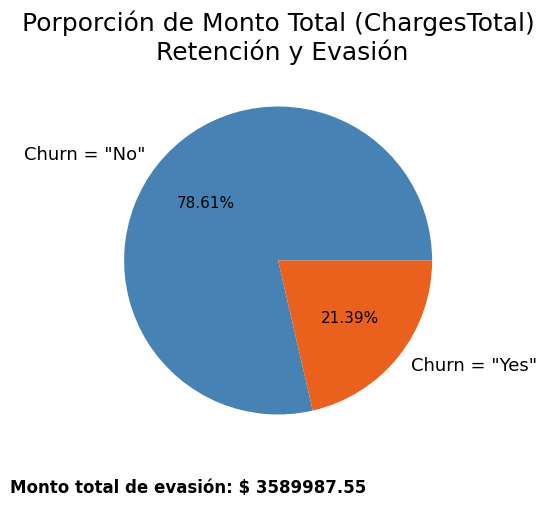

In [63]:
totales = datos.groupby('Churn')['ChargesTotal'].sum().reset_index()
churn_yes = totales[totales['Churn'] == 'Yes']

fig, ax = plt.subplots(figsize=(8,5))

wedges, texts, autotexts = ax.pie(data=totales,
                                  x='ChargesTotal',
                                  autopct='%1.2f%%',
                                  labels=['Churn = "No"', 'Churn = "Yes"'],
                                  colors= ['#4682b4', '#e9611d'],
                                  startangle=0
                                  )
for t in texts:
    t.set_fontsize(13)
for a in autotexts:
    a.set_fontsize(11)

plt.title('Porporción de Monto Total (ChargesTotal)\n Retención y Evasión', fontsize=18)
plt.figtext(0.4, 0.03, f'Monto total de evasión: $ {churn_yes["ChargesTotal"].values[0]}', ha='center', fontsize=12, fontweight='bold')

fig.savefig('monto_evasion.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

### <font color='#f07c3e'>**Evasión (Churn) según Antiguedad (Tenure)**</font>

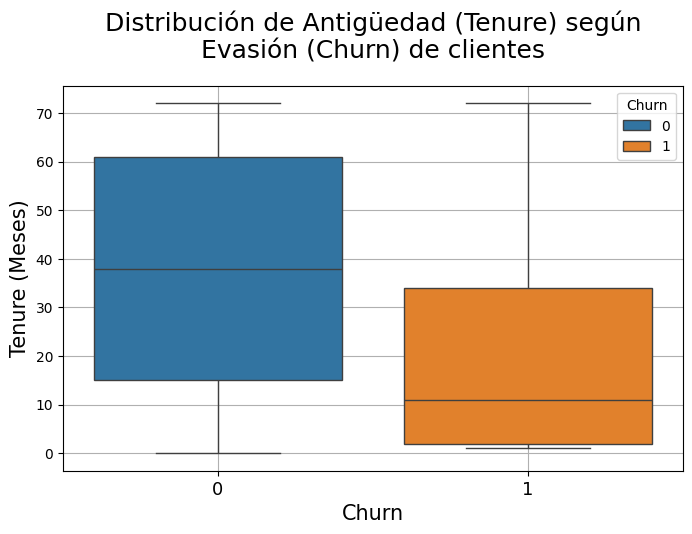

In [64]:
tenure_boxplot = boxplot_churn(df, ycol='Tenure', ylabel='Tenure (Meses)', title_translate='Antigüedad (Tenure)')

In [65]:
df[df['Churn'] == 1].describe()['Tenure']

,Tenure
count,1978.000000
mean,20.508595
std,21.721863
min,1.000000
25%,2.000000
50%,11.000000
75%,34.000000
max,72.000000


Se observa que la frecuencia de abandono es mayor en las etapas tempranas de la relación del cliente con la empresa, con una **concentración del 50% de abandono** antes del primer año de contrato.

### <font color='#f07c3e'>**Evasión (Churn) según Gasto Total (ChargesTotal)**</font>

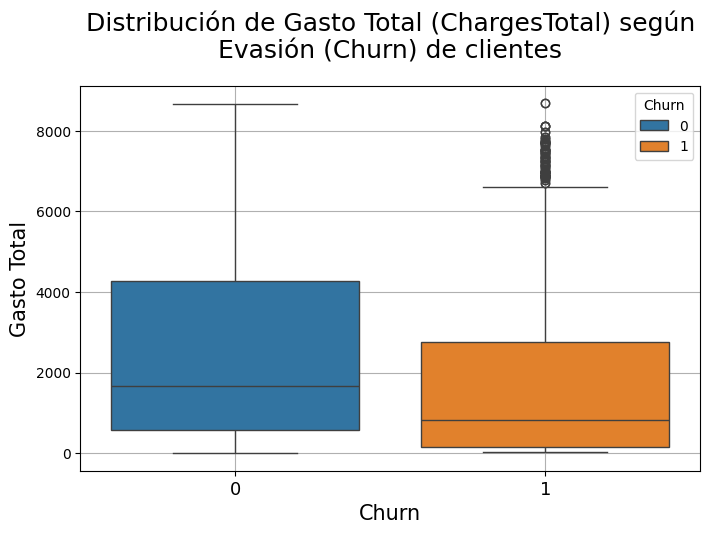

In [66]:
tenure_boxplot = boxplot_churn(df, ycol='ChargesTotal', ylabel='Gasto Total', title_translate='Gasto Total (ChargesTotal)')

ChargesTotal es una variable de naturaleza acumulativa, esta fuertemente relacionada con la antigüedad del cliente. Esto se puede observar en el análisis de correlación donde en índice de Pearson entre ambas variables es **0.94**. Esto puede generar redundancia en el modelo, por lo que, se experimentará primero considerando ambas variables, y luego se mantendrá Tenure y ChargesMonthly, ya que la combinación de estas dos variables explican ChargesTotal.


# <font color='#5a9bd4'>**4. Modelado de datos**</font>


## <font color='#ebac3a'>**Train Test Split**</font>

In [87]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [88]:
X_cv, X_test, y_cv, y_test = tts(X, y, test_size=0.15, stratify=y, random_state=42)

In [89]:
X_train, X_val, y_train, y_val = tts(X_cv, y_cv, test_size=0.10, stratify=y_cv, random_state=42)

#### **Conjunto X_scale**

In [90]:
X_scale = df_scale.drop('Churn', axis=1)
y_scale = df_scale['Churn']

In [91]:
X_scale_cv, X_scale_test, y_scale_cv, y_scale_test = tts(X_scale, y_scale, test_size=0.15, stratify=y_scale, random_state=42)

In [92]:
X_scale_train, X_scale_val, y_scale_train, y_scale_val = tts(X_scale_cv, y_scale_cv, test_size=0.10, stratify=y_scale_cv, random_state=42)

#### **Conjunto X_linear**

In [93]:
X_linear = df_linear.drop('Churn', axis=1)
y_linear = df_linear['Churn']

In [94]:
X_linear_cv, X_linear_test, y_linear_cv, y_linear_test = tts(X_linear, y_linear, test_size=0.15, stratify=y_linear, random_state=42)

In [95]:
X_linear_train, X_linear_val, y_linear_train, y_linear_val = tts(X_linear_cv, y_linear_cv, test_size=0.10, stratify=y_linear_cv, random_state=42)

## <font color='#ebac3a'>**Escalado de variables numéricas**</font>

In [96]:
var_num = ['Tenure', 'ChargesMonthly', 'ChargesTotal']
var_num_scaled = ['Tenure_scaled', 'ChargesMonthly_scaled', 'ChargesTotal_scaled']

#### **Conjunto X_scale**

In [97]:
X_scale_cv

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,NoInternetService,OnlineSecurity_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal
5753,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,44.0,56.25,2419.55
2566,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,19.25,112.30
715,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,6.0,90.75,512.25
13,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,53.0,64.15,3491.55
6196,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,19.40,50.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,69.75,69.75
7156,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,58.0,45.30,2651.20
4209,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,19.0,89.35,1686.85
5720,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,29.0,20.65,654.85


In [98]:
robust_scaler = RobustScaler()

# Fit solo en los datos de entrenamiento (X_cv)
robust_scaler.fit(X_scale_cv[var_num])

# Transformar todos los datasets usando el mismo scaler
X_scaled_cv = X_scale_cv.copy()
y_scaled_cv = y_scale_cv.copy()
X_scaled_train = X_scale_train.copy()
y_scaled_train = y_scale_train.copy()
X_scaled_val = X_scale_val.copy()
y_scaled_val = y_scale_val.copy()
X_scaled_test = X_scale_test.copy()
y_scaled_test = y_scale_test.copy()

X_scaled_cv[var_num_scaled] = robust_scaler.transform(X_scale_cv[var_num])
X_scaled_train[var_num_scaled] = robust_scaler.transform(X_scale_train[var_num])
X_scaled_val[var_num_scaled] = robust_scaler.transform(X_scale_val[var_num])
X_scaled_test[var_num_scaled] = robust_scaler.transform(X_scale_test[var_num])

X_scaled_cv.drop(var_num, axis=1, inplace=True)
X_scaled_train.drop(var_num, axis=1, inplace=True)
X_scaled_val.drop(var_num, axis=1, inplace=True)
X_scaled_test.drop(var_num, axis=1, inplace=True)

In [99]:
X_scaled_cv.head()

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,NoInternetService,OnlineSecurity_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure_scaled,ChargesMonthly_scaled,ChargesTotal_scaled
5753,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.291667,-0.287234,0.260371
2566,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.479167,-1.002901,-0.367034
715,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.500000,0.380077,-0.258277
13,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.479167,-0.134429,0.551877
6196,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.583333,-1.000000,-0.383812


#### **Conjunto X_linear**

In [100]:
robust_scaler_linear = RobustScaler()

X_linear_cv[var_num_scaled] = robust_scaler_linear.fit_transform(X_linear_cv[var_num])
X_linear_train[var_num_scaled] = robust_scaler_linear.transform(X_linear_train[var_num])
X_linear_val[var_num_scaled] = robust_scaler_linear.transform(X_linear_val[var_num])
X_linear_test[var_num_scaled] = robust_scaler_linear.transform(X_linear_test[var_num])

X_linear_cv.drop(var_num, axis=1, inplace=True)
X_linear_train.drop(var_num, axis=1, inplace=True)
X_linear_val.drop(var_num, axis=1, inplace=True)
X_linear_test.drop(var_num, axis=1, inplace=True)

In [101]:
X_linear_cv.head()

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,NoInternetService,OnlineSecurity_Yes,OnlineBackup_Yes,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure_scaled,ChargesMonthly_scaled,ChargesTotal_scaled
5753,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.291667,-0.287234,0.260371
2566,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.479167,-1.002901,-0.367034
715,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.500000,0.380077,-0.258277
13,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.479167,-0.134429,0.551877
6196,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.583333,-1.000000,-0.383812


## <font color='#ebac3a'>**Balance del dataset**</font>

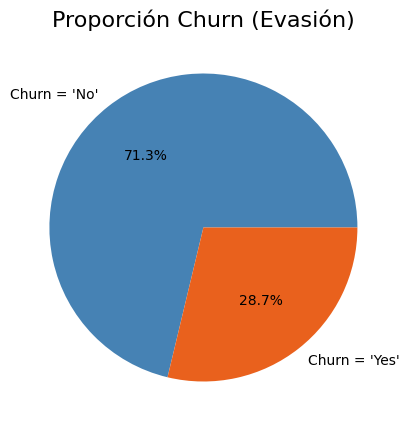

In [102]:
# Visualizar la proporción de registros en relación a la evasión (Churn)
churns = df.groupby('Churn')['Churn'].value_counts()
churns = pd.DataFrame(churns)
fig, ax = plt.subplots(figsize=(6,5))
ax = plt.pie(data=churns,
             x=churns['count'],
             labels=["Churn = 'No'", "Churn = 'Yes'"],
             autopct='%1.1f%%',
             colors= ['#4682b4', '#e9611d'])

plt.title('Proporción Churn (Evasión)', fontsize=16)

fig.savefig('pie_Churn_proportion.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

Como se observa en el gráfico, la distribución de clases está desbalanceada: aproximadamente el **75 % de los registros corresponden a clientes que no han abandonado la empresa (No Churn)**. Esta desproporción puede sesgar al modelo durante el entrenamiento, **dificultando su capacidad para aprender correctamente los patrones asociados al abandono de clientes (Churn)**. Por ello, será necesario aplicar una estrategia de **balanceo en los datos** de entrenamiento.

Es importante destacar que **el balanceo se realiza exclusivamente sobre los datos de entrenamiento**, para evitar el fenómeno conocido como ***Data Leakage***. Balancear también los conjuntos de validación o prueba modificaría artificialmente la distribución original de las clases, lo que podría llevar a obtener métricas de desempeño no confiables o sobreestimadas.

Dado que el objetivo es que el modelo aprenda patrones reales presentes en los datos históricos de la empresa, se optará por una estrategia conservadora: **undersampling de la clase mayoritaria**, utilizando la técnica `NearMiss`. Esta técnica selecciona los ejemplos más relevantes de la clase mayoritaria, conservando los casos más difíciles de clasificar, lo que puede contribuir a mejorar la capacidad del modelo para detectar churn.

Aunque existen técnicas como `SMOTE` que permiten generar nuevas observaciones sintéticas de la clase minoritaria mediante interpolación, estas observaciones no provienen de datos reales. Si bien están respaldadas matemáticamente, podrían inducir patrones artificiales que no se corresponden con la realidad del negocio. Por ello, se prefiere reservar `SMOTE` para situaciones controladas, como la creación de una base balanceada para evaluar modelos en producción, donde se busca analizar cómo se desempeñan frente a una distribución equilibrada.

In [103]:
columnas = df.columns
columnas, len(columnas)

(Index(['Gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
        'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_DSL',
        'InternetService_Fiber optic', 'NoInternetService',
        'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
        'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
        'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
        'PaperlessBilling_Yes', 'PaymentMethod_Bank transfer (automatic)',
        'PaymentMethod_Credit card (automatic)',
        'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
        'Tenure', 'ChargesMonthly', 'ChargesTotal', 'Churn'],
       dtype='object'),
 27)

In [104]:
undersampler = NearMiss(version=3)

#### **Conjunto X**

In [105]:
X_cv, y_cv = undersampler.fit_resample(X_cv,y_cv)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [106]:
y_cv.value_counts()

,count
Churn,
0,1774
1,1774


In [107]:
y_train.value_counts()

,count
Churn,
0,1596
1,1596


#### **Conjunto X_scaled**

In [110]:
X_scaled_cv, y_scaled_cv = undersampler.fit_resample(X_scaled_cv,y_scaled_cv)
X_scaled_train, y_scaled_train = undersampler.fit_resample(X_scaled_train, y_scaled_train)

In [111]:
y_scaled_cv.value_counts()

,count
Churn,
0,1520
1,1520


In [112]:
y_scaled_train.value_counts()

,count
Churn,
0,1378
1,1378


#### **Conjunto X_linear**

In [114]:
X_linear_cv, y_linear_cv = undersampler.fit_resample(X_linear_cv,y_linear_cv)
X_linear_train, y_linear_train = undersampler.fit_resample(X_linear_train, y_linear_train)

/usr/local/lib/python3.11/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:206: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:206: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


In [115]:
y_linear_cv.value_counts()

,count
Churn,
0,1714
1,1539


In [116]:
y_linear_train.value_counts()

,count
Churn,
0,1541
1,1387


In [117]:
X_cv

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,NoInternetService,OnlineSecurity_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal
0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,72.0,116.95,8594.40
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,65.0,45.25,2933.95
2,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,68.0,44.80,2983.65
3,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,58.0,50.00,2919.85
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,59.0,44.30,2666.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3543,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,70.20,115.95
3544,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,19.0,79.85,1471.75
3545,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,69.75,69.75
3546,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,58.0,45.30,2651.20


## <font color='#ebac3a'>**Baseline model - Decision Tree Classifier**</font>

In [118]:
X_cv.shape

(3548, 26)

In [119]:
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

In [120]:
baseline_model = DecisionTreeClassifier(max_depth=10, random_state=42)
baseline_cross_val_results = cross_validate(baseline_model, X_cv, y_cv, cv=skf, scoring='recall')

In [121]:
cv_score_interval(results=baseline_cross_val_results,
                  nombre='Baseline Model',
                  score='Recall')

Recall promedio de Baseline Model: 0.6443
Desviación estándar del Recall de Baseline Model: 0.0332
El Recall de Baseline Model estará entre [0.5779,0.7107] con un 95% de confianza


In [122]:
baseline_model.fit(X_cv, y_cv)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [123]:
baseline_pred = baseline_model.predict(X_test)

In [124]:
print(classification_report(y_test, baseline_pred))

              precision    recall  f1-score   support

           0       0.85      0.71      0.77       777
           1       0.49      0.69      0.57       313

    accuracy                           0.70      1090
   macro avg       0.67      0.70      0.67      1090
weighted avg       0.75      0.70      0.72      1090



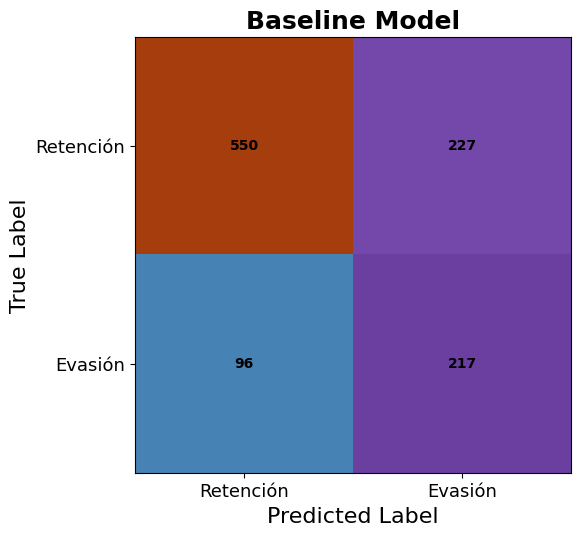

In [125]:
plot_conf_mat(baseline_model, X_test, y_test, 'Baseline Model', 'baseline')

### <font color='#8b5fc4'>**Observaciones Baseline Model: DecisionTreeClassifier - Max Depth = 10**</font>

|              |precision  |  recall|  f1-score |   support|
|--------------|-----------|--------|-----------|----------|
|           0  |   0.84    |  0.75  |    0.79   |    776   |
|           1  |   0.49    |  0.64  |    0.55   |    297   |
|   macro avg  |    0.67   |   0.69 |    0.67   |   1073   |
|--------------|-----------|--------|-----------|----------|
|    accuracy  |           |        |    0.72   |   1073   |


#### **Clase 0 (clientes que no abandonan):**

* **Precisión 0.84:** cuando el modelo predice que un cliente no abandona, **acierta el 84%** de las veces.
* **Recall 0.75:** detecta **correctamente al 75%** de los que realmente **no abandonan**.
* **F1-score 0.79:** buen equilibrio entre precisión y recall.
* **Support: 776** clientes realmente no abandonaron (mayoría).

#### **Clase 1 (clientes que sí abandonan):**

* **Precisión 0.49:** cuando el modelo predice que un cliente abandonará, acierta solo el 49% de las veces (muchos falsos positivos).
* **Recall 0.64:** logra capturar el 64% de los abandonos reale, lo cual es una métrica relativamente aceptable para el modelo base.
* **F1-score 0.55:** balance moderado entre precisión baja y recall decente.
* **Support: 297** clientes realmente abandonaron.


#### **Accuracy: 0.72**

El modelo acierta en el 72% de los casos.
Pero, debido a que las clases estan desbalanceadas, esta métrica puede estar influenciada por la clase mayoritaria (clase 0), es por eso que resulta relevante observar otras métricas para obtener una evaluación confiable del modelo.

In [126]:
baseline_results = metricas_evaluacion(modelo=baseline_model,
                                       x_test= X_test,
                                       y_test=y_test,
                                       nombre='Baseline Model',
                                       conjunto='X')

El **modelo base** fue entrenado sin ajuste de hiperparámetros ni técnicas de preprocesamiento avanzadas, con el objetivo de servir como punto de comparación para modelos posteriores.

| Modelo         | Accuracy  |Precision | Recall   | F1-score | AUC    |
|----------------|-----------|----------|----------|----------|--------|
| Baseline Model |  0.7158	 | 0.4896   | 0.6364   | 0.5534   | 0.7418 |

* **Exactitud (Accuracy)** del modelo: **0.7158**
  
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

* **Recall (Sensibilidad):** el modelo es capaz de identificar correctamente al **0.6364** de los clientes que efectivamente abandonan:

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

* **Precisión (Precision):** el **0.4896** de las veces que el modelo predice que un cliente abandonará, está en lo correcto:

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

* **F1-score:** dado que la precisión y la sensibilidad tienen el mismo valor, el F1-score también es **0.5534**:

$$
\text{F1-score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

* **AUC (Área bajo la curva ROC)**: el valor obtenido de **0.7418** indica que el modelo tiene una capacidad aceptable para discriminar entre clientes que abandonan y los que no, evaluando su rendimiento a lo largo de todos los umbrales posibles.
Esto significa que si se selecciona aleatoriamente un cliente que abandonó y uno que no, el modelo tiene aproximadamente un 74,18% de probabilidad de asignar una mayor probabilidad de abandono al cliente que efectivamente se fue.

---

**Objetivo**: A partir de este modelo base, se buscará **mejorar principalmente la sensibilidad (Recall)** —clave para detectar clientes en riesgo de abandono—, sin sacrificar excesivamente la precisión, la cual es importante mejorar ya que demasiados errores de Precisión pueden llevar a campañas de retención ineficientes en costos, lo cual se traduce intervenciones innecesarias sobre clientes que continuarían utilizando el servicio.

### <font color='#f07c3e'>**ROC Curve**</font>

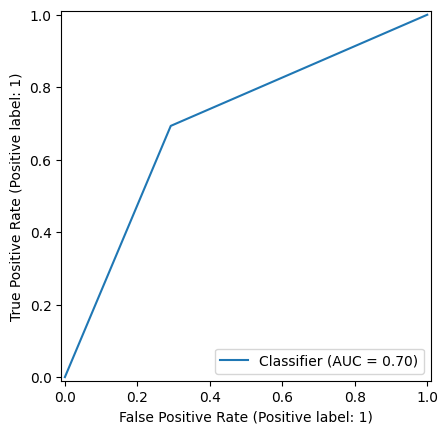

In [127]:
RocCurveDisplay.from_predictions(y_test, baseline_pred);

El **AUC-ROC** se calcula variando el **umbral de decisión sobre la probabilidad de la clase positiva**.

- Al usar `predict_proba(x_test)[:, 1]`, el AUC se evalúa considerando **todos los posibles umbrales (de 0 a 1)**, lo que permite medir adecuadamente el área bajo la curva ROC.
- En cambio, al usar `predict(x_test)`, se evalúa el rendimiento solo en un **único punto** (umbral fijo = 0.5), por lo tanto el cálculo del AUC **pierde resolución y subestima la verdadera capacidad de discriminación del modelo**.

Por eso, en el gráfico se observa un **AUC = 0.69**, mientras que al usar probabilidades se obtiene un valor de **0.7418**. Esta diferencia de casi **5%** sugiere que el modelo podría alcanzar **una mejor performance si se ajusta el umbral de decisión**, en lugar de utilizar el valor por defecto de 0.5.

### <font color='#f07c3e'>**Baseline Model: Umbral de decisión**</font>

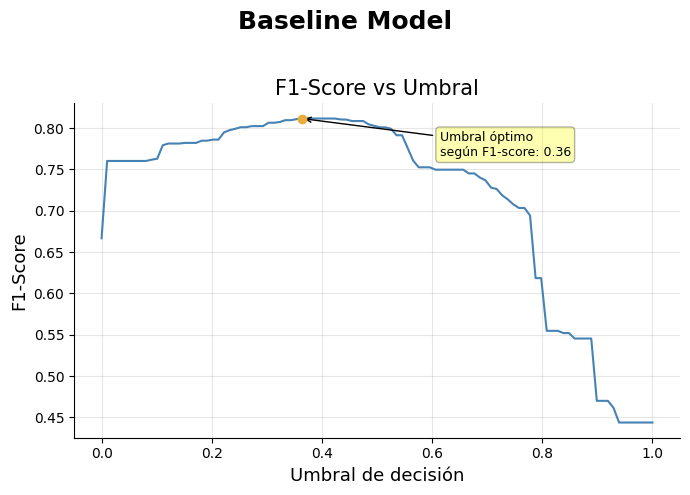

In [128]:
umbral_baseline = plot_umbrales(modelo=baseline_model,
                                score='F1-Score',
                                x=X_cv,
                                y=y_cv,
                                caja_x=0.25,
                                caja_y=0.045,
                                nombre='Baseline Model')

### <font color='#8b5fc4'>**Observaciones: Baseline Model - Umbral de decisión**</font>

A partir del análisis del **F1-score** —métrica que balancea *precisión* y *recall*—, se determinó que el mejor desempeño del modelo se alcanza con un umbral de decisión de **0.4**.

Esto significa que todas aquellas observaciones cuya probabilidad de abandono sea **mayor o igual a 0.4** serán clasificadas como positivas (`Churn = 1`).

Este ajuste en el umbral permite mejorar la capacidad del modelo para separar correctamente las clases, y será clave para conservar la versión que logre la mejor discriminación entre clientes que abandonan y los que no.
Se utiliza F1-score, ya que las métricas de *precisión* y *recall* por separado, presentan umbrales extremos (0 y 1), lo cual no aporta información útil para la clasificación.  
Esto reforzó la elección del **F1-score** como métrica principal, ya que proporciona un equilibrio más realista entre ambas medidas y permite identificar un umbral intermedio verdaderamente informativo.

<font color='#f07c3e'>**Baseline Model: Precision vs Recall Curve**</font>

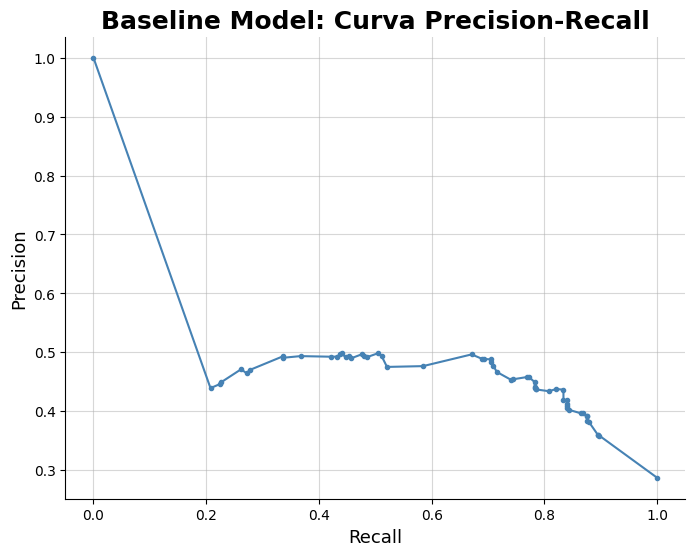

In [129]:
plot_precision_recall_curve(modelo=baseline_model,
                            x=X_test,
                            y=y_test,
                            nombre='Baseline Model')

### <font color='#8b5fc4'>**Observaciones: Baseline Model - Precision vs Recall Curve**</font>

A partir del gráfico generado se observa el trade-off entre **Precision** y **Recall** para distintos umbrales de decisión.

Por ejemplo, si se desea alcanzar un **Recall cercano a 0.80**, se debe aceptar una **caída en la Precision hasta aproximadamente 0.47**.

Dado que el objetivo principal es priorizar la **Sensibilidad *(Recall)*** sin sacrificar en exceso la **Precisión *(Precision)***, será necesario encontrar un modelo que, mediante una combinación adecuada de hiperparámetros y umbral de decisión, permita clasificar correctamente la mayor cantidad posible de verdaderos abandonos, minimizando al mismo tiempo la cantidad de falsos positivos.

In [130]:
baseline_results_umbral = metricas_evaluacion(modelo=baseline_model,
                                               x_test= X_test,
                                               y_test=y_test,
                                               nombre='Baseline Model',
                                               conjunto='X',
                                               umbral=0.41)

pd.DataFrame([baseline_results_umbral])

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Baseline Model,X,0.6523,0.4406,0.7827,0.5639,0.7238,0.41


In [131]:
# Crear una lista para almacenar los resultados del mejor modelo de cada familia y poder realizar comparaciones.
best_models = []

In [132]:
best_models.append(baseline_results_umbral)
pd.DataFrame(best_models)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Baseline Model,X,0.6523,0.4406,0.7827,0.5639,0.7238,0.41


## <font color='#ebac3a'>**Random Forest Classifier**</font>

In [133]:
# Lista para registrar los resultados de los modelos dentro de la familia Random Forest
rf_results_tracking = []

### <font color='#f07c3e'>**RandomForest 1 - MaxDepth = 10 - Conjunto X**</font>

In [134]:
rf_1 = RandomForestClassifier(max_depth=10, random_state=42)

rf_1_cv_results = cross_validate(rf_1, X_cv, y_cv, cv=skf, scoring='recall')

In [135]:
cv_score_interval(results=rf_1_cv_results,
                  nombre='RandomForest 1',
                  score='Recall')

Recall promedio de RandomForest 1: 0.7153
Desviación estándar del Recall de RandomForest 1: 0.0225
El Recall de RandomForest 1 estará entre [0.6703,0.7603] con un 95% de confianza


In [136]:
rf_1.fit(X_cv, y_cv)

RandomForestClassifier(max_depth=10, random_state=42)

In [137]:
rf_1_results = metricas_evaluacion(modelo=rf_1,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 1',
                                   conjunto='X')

rf_results_tracking.append(rf_1_results)
pd.DataFrame(rf_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,RandomForest 1,X,0.7862,0.6081,0.7188,0.6589,0.8295,0.5


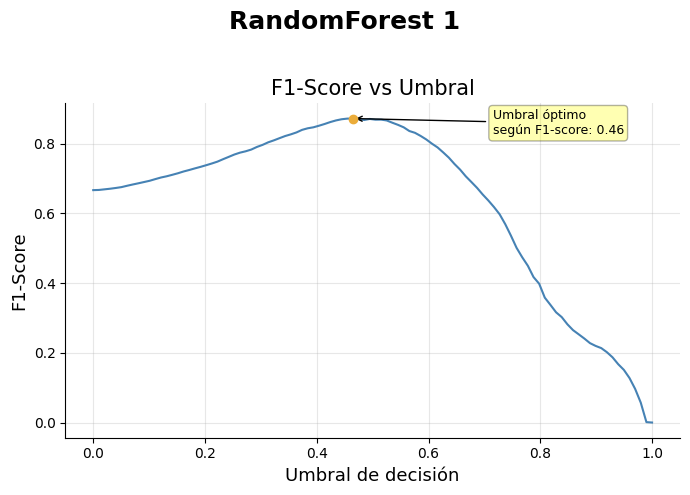

In [138]:
umbral_rf_1 = plot_umbrales(modelo=rf_1,
                                score='F1-Score',
                                x=X_cv,
                                y=y_cv,
                                caja_x=0.25,
                                caja_y=0.045,
                                nombre='RandomForest 1')

In [139]:
rf_1_results_umbral = metricas_evaluacion(modelo=rf_1,
                                           x_test=X_test,
                                           y_test=y_test,
                                           nombre='RandomForest 1',
                                           conjunto='X',
                                           umbral=0.46,)

rf_results_tracking.append(rf_1_results_umbral)

In [140]:
pd.DataFrame(rf_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,RandomForest 1,X,0.7862,0.6081,0.7188,0.6589,0.8295,0.50
1,RandomForest 1,X,0.7633,0.5644,0.7700,0.6514,0.8295,0.46


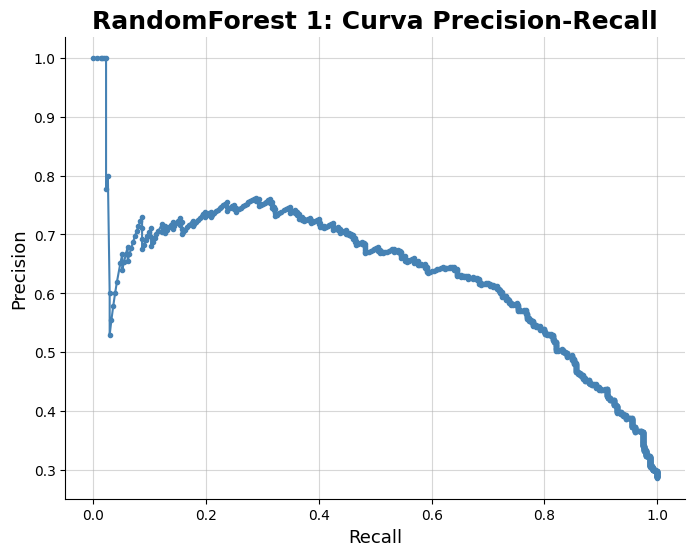

In [141]:
plot_precision_recall_curve(modelo=rf_1,
                            x=X_test,
                            y=y_test,
                            nombre='RandomForest 1')

### <font color='#8b5fc4'>**Observaciones: RandomForest 1 - MaxDepth = 10 - Conjunto X**</font>

Este modelo consigue superar significativamente a `BaselineModel`:

| Modelo           | Conjunto | Accuracy | Precision | Recall | F1-Score | AUC    | Umbral |
|------------------|----------|----------|-----------|--------|----------|--------|--------|
| Baseline Model   | X        | 0.7158   | 0.4896    | 0.6364 | 0.5534   | 0.7418 | 0.50   |
| RandomForest 1   | X        | 0.7745   | 0.5729    | 0.7273 | 0.6409   | 0.8295 | 0.50   |

Inicialmente el modelo `RandomForest 1`, con el umbral por defecto en 0.5, consigue los siguientes aumentos en las métricas:

- **Accuracy**: 0.7158 → 0.7745 = +0.0587 **(+5.87%)**
- **Precision**: 0.4896 → 0.5729 = +0.0833 **(+8.33%)**
- **Recall**: 0.6364 → 0.7273 = +0.0909 **(+9.09%)**
- **F1-Score**: 0.5534 → 0.6409 = +0.0875 **(+8.75%)**

Luego, al ajustar el **umbral según el valor óptimo determinado por la métrica F1-score (0.46)**, se incrementa significativamente el Recall, con un sacrificio leve en Precision:

| Modelo           | Conjunto | Accuracy | Precision | Recall | F1-Score | AUC    | Umbral |
|------------------|----------|----------|-----------|--------|----------|--------|--------|
| RandomForest 1   | X        | 0.7596   | 0.5465    | 0.7710 | 0.6397   | 0.8295 | 0.46   |

Con esta configuración se logra:

* Un aumento adicional del **Recall** de **+4.37%**
* Una pérdida de solo **2.64%** en **Precision**


### <font color='#f07c3e'>**RandomForest 2 - MaxDepth = 10 - Conjunto X_scaled**</font>

Si bien el algoritmo Random Forest es robusto frente a la escala de variables, se ejecutará `Cross Validate` sobre el conjunto `X_scaled`, para ver si el modelo consigue aprender mejor el patrón presente en los datos al tener las variables numéricas transformadas con `RobustScaler`

In [142]:
rf_2 = RandomForestClassifier(max_depth=10, random_state=42)

rf_2_cv_results = cross_validate(rf_2, X_scaled_cv, y_scaled_cv, cv=skf, scoring='recall')

In [143]:
cv_score_interval(results=rf_2_cv_results,
                  nombre='RandomForest 2',
                  score='Recall')

Recall promedio de RandomForest 2: 0.6026
Desviación estándar del Recall de RandomForest 2: 0.0371
El Recall de RandomForest 2 estará entre [0.5284,0.6768] con un 95% de confianza


In [144]:
rf_2.fit(X_scaled_cv, y_scaled_cv)

RandomForestClassifier(max_depth=10, random_state=42)

In [145]:
rf_2_results = metricas_evaluacion(modelo=rf_2,
                                   x_test=X_scaled_test,
                                   y_test=y_scaled_test,
                                   nombre='RandomForest 2',
                                   conjunto='X_scaled')

rf_results_tracking.append(rf_2_results)
pd.DataFrame(rf_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,RandomForest 1,X,0.7862,0.6081,0.7188,0.6589,0.8295,0.50
1,RandomForest 1,X,0.7633,0.5644,0.7700,0.6514,0.8295,0.46
2,RandomForest 2,X_scaled,0.7578,0.5671,0.6613,0.6106,0.8043,0.50


### <font color='#8b5fc4'>**Observaciones: RandomForest 2 - MaxDepth = 10 - Conjunto X_scaled**</font>

Solo con analizar el resultado de `Cross Validate`, es posible observar que la métricas prioritaria (**Recall**) del modelo cae severamente al utilizar el conjunto `X_scaled`, aunque muestra una mayor estabilidad en **Precisión**.

Sin embargo, dado que lo que se busca maximizar es la **Sensibilidad** del modelo, una diferencia de casi 17% es excesivamente alta. Por lo que este modelo no se postula como candidato a entorno productivo.

### <font color='#f07c3e'>**RandomForest 3 - MaxDepth = 10 - Conjunto X - Corr_selected Features**</font>

Se llevará a cabo un expermiento, entrenando un Random Forest utilizando las variables seleccionadas con mayor correlatividad en cuanto a la variable respuesta (`Churn`).

In [146]:
rf_3 = RandomForestClassifier(max_depth=10, random_state=42)

In [147]:
rf_3_columns = corr_selected.columns
rf_3_columns = rf_3_columns[:-1]
rf_3_columns

Index(['SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'NoInternetService', 'OnlineSecurity_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure', 'ChargesMonthly', 'ChargesTotal'],
      dtype='object')

In [148]:
rf_3_cv_results = cross_validate(rf_3, X_cv[rf_3_columns], y_cv, cv=skf, scoring='recall')

cv_score_interval(results=rf_3_cv_results,
                  nombre='RandomForest 3',
                  score='Recall')

Recall promedio de RandomForest 3: 0.7074
Desviación estándar del Recall de RandomForest 3: 0.0226
El Recall de RandomForest 3 estará entre [0.6622,0.7526] con un 95% de confianza


In [149]:
rf_3.fit(X_cv[rf_3_columns], y_cv)

RandomForestClassifier(max_depth=10, random_state=42)

In [150]:
rf_3_results = metricas_evaluacion(modelo=rf_3,
                                   x_test=X_test[rf_3_columns],
                                   y_test=y_test,
                                   nombre='RandomForest 3',
                                   conjunto='X[corr_features]')

rf_results_tracking.append(rf_3_results)
pd.DataFrame(rf_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,RandomForest 1,X,0.7862,0.6081,0.7188,0.6589,0.8295,0.50
1,RandomForest 1,X,0.7633,0.5644,0.7700,0.6514,0.8295,0.46
2,RandomForest 2,X_scaled,0.7578,0.5671,0.6613,0.6106,0.8043,0.50
3,RandomForest 3,X[corr_features],0.7771,0.5941,0.7061,0.6453,0.8233,0.50


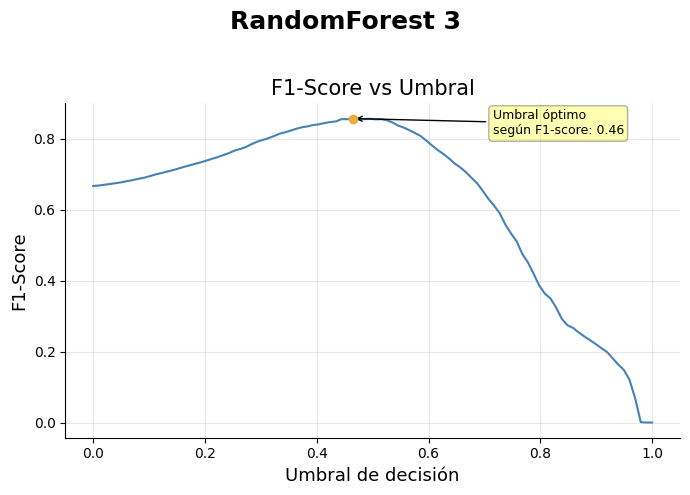

In [151]:
umbral_rf_3 = plot_umbrales(modelo=rf_3,
                                score='F1-Score',
                                x=X_cv[rf_3_columns],
                                y=y_cv,
                                caja_x=0.25,
                                caja_y=0.045,
                                nombre='RandomForest 3')

In [152]:
rf_3_results_umbral = metricas_evaluacion(modelo=rf_3,
                                           x_test=X_test[rf_3_columns],
                                           y_test=y_test,
                                           nombre='RandomForest 3',
                                           conjunto='X[corr_features]',
                                           umbral=0.45)

rf_results_tracking.append(rf_3_results_umbral)
pd.DataFrame(rf_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,RandomForest 1,X,0.7862,0.6081,0.7188,0.6589,0.8295,0.50
1,RandomForest 1,X,0.7633,0.5644,0.7700,0.6514,0.8295,0.46
2,RandomForest 2,X_scaled,0.7578,0.5671,0.6613,0.6106,0.8043,0.50
3,RandomForest 3,X[corr_features],0.7771,0.5941,0.7061,0.6453,0.8233,0.50
4,RandomForest 3,X[corr_features],0.7550,0.5516,0.7859,0.6482,0.8233,0.45


### <font color='#8b5fc4'>**Observaciones: RandomForest 3 - MaxDepth = 10 - Conjunto X - Corr_selected Features**</font>

El modelo entrenado con las variables seleccionadas de manera arbitraria al tener un valor absoluto de correlación mayor a 0.7 respecto a la variable de respuesta, consigue superar en la métrica prioritaria `RandomForest 1`.

Sin embargo, la diferencia en **Recall**, es de 0.68%, mientras que la caída en precisión es de 2.03%, por lo que esta leve mejora no justifica el sacrificio en **Precisión**.

Aún así, debido a que una reducción arbitraria en la dimensionalidad mostró que el modelo podría beneficiarse de trabajar con menos variables, se realizará una experimento para determinar la cantidad óptima de variables a partir de las importancias determinadas por `RandomForest 1`

### <font color='#f07c3e'>**Feature Selection**</font>

In [153]:
features = X_cv.columns
rf_1_importances = rf_1.feature_importances_
rf_1_importances = pd.DataFrame({'Feature': features, 'Importancia': rf_1_importances})
rf_1_importances = rf_1_importances.sort_values('Importancia', ascending=False)
rf_1_importances

,Feature,Importancia
25,ChargesTotal,0.175341
23,Tenure,0.166627
24,ChargesMonthly,0.159664
15,Contract_Month-to-month,0.044024
7,InternetService_Fiber optic,0.035847
21,PaymentMethod_Electronic check,0.034689
12,TechSupport_Yes,0.030531
18,PaperlessBilling_Yes,0.029771
9,OnlineSecurity_Yes,0.027886
0,Gender_Male,0.023094


In [133]:
len(rf_1_importances)

26

In [154]:
feature_selection = []

ct_features = [i if i != 0 else 1 for i in range(0, len(rf_1_importances), 5)]

for i in ct_features:
    model_features = RandomForestClassifier(max_depth=10, random_state=42)
    selected_features = rf_1_importances['Feature'].values[:i]
    X_train_sel = X_cv[selected_features]
    X_test_sel = X_test[selected_features]
    model_features.fit(X_train_sel, y_cv)
    metricas = metricas_evaluacion(model_features, X_test_sel, y_test, f'Features: {i}', 'X')
    feature_selection.append(metricas)

pd.DataFrame(feature_selection)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Features: 1,X,0.6349,0.3885,0.4728,0.4265,0.6059,0.5
1,Features: 5,X,0.7349,0.5326,0.6262,0.5756,0.7963,0.5
2,Features: 10,X,0.7624,0.5718,0.6869,0.6241,0.8141,0.5
3,Features: 15,X,0.7752,0.5939,0.6869,0.6370,0.8245,0.5
4,Features: 20,X,0.7789,0.5989,0.6965,0.6440,0.8254,0.5
5,Features: 25,X,0.7890,0.6143,0.7125,0.6598,0.8287,0.5


### <font color='#8b5fc4'>**Observaciones: Feature Selection**</font>

El modelo que consigue mejor **Recall** es aquel entrenado con las 15 variables más importantes según `RandomForest 1`:

* `Tenure`
* `ChargesTotal`
* `ChargesMonthly`
* `Contract_Month-to-month`
* `TechSupport_Yes`
* `PaymentMethod_Electronic check`
* `OnlineSecurity_Yes`
* `Contract_Two year`
* `PaperlessBilling_Yes`
* `InternetService_Fiber optic`
* `Gender_Male`
* `Contract_One year`
* `StreamingMovies_Yes`
* `MultipleLines_Yes`
* `OnlineBackup_Yes`

Por lo que, se entrenará un modelo que permita controlar el umbral de decisión con la intención de superar las mejores métricas obtenidas hasta el momento.

### <font color='#f07c3e'>**RandomForest 4 - Max depth = 10 - Feature Selection**</font>

In [155]:
selected_cols = rf_1_importances['Feature'][:15].values
selected_cols

array(['ChargesTotal', 'Tenure', 'ChargesMonthly',
       'Contract_Month-to-month', 'InternetService_Fiber optic',
       'PaymentMethod_Electronic check', 'TechSupport_Yes',
       'PaperlessBilling_Yes', 'OnlineSecurity_Yes', 'Gender_Male',
       'StreamingTV_Yes', 'MultipleLines_Yes', 'OnlineBackup_Yes',
       'Dependents_Yes', 'SeniorCitizen_Yes'], dtype=object)

In [156]:
rf_4 = RandomForestClassifier(max_depth=10, random_state=42)

rf_4_cv_results = cross_validate(rf_4, X_cv[selected_cols], y_cv, cv=skf, scoring='recall')

cv_score_interval(results=rf_4_cv_results,
                  nombre='RandomForest 4',
                  score='Recall')

Recall promedio de RandomForest 4: 0.7018
Desviación estándar del Recall de RandomForest 4: 0.0176
El Recall de RandomForest 4 estará entre [0.6666,0.7370] con un 95% de confianza


In [157]:
rf_4.fit(X_cv[selected_cols], y_cv)

RandomForestClassifier(max_depth=10, random_state=42)

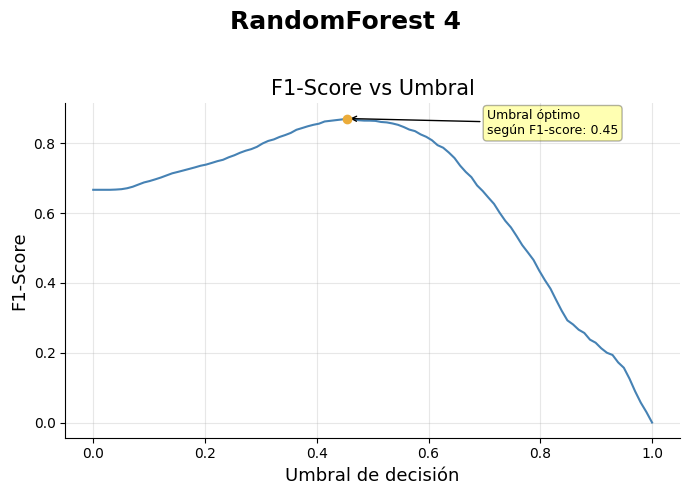

In [158]:
umbral_rf_4 = plot_umbrales(modelo=rf_4,
                                score='F1-Score',
                                x=X_cv[selected_cols],
                                y=y_cv,
                                caja_x=0.25,
                                caja_y=0.045,
                                nombre='RandomForest 4')

In [159]:
rf_4_results = metricas_evaluacion(modelo=rf_4,
                                   x_test=X_test[selected_cols],
                                   y_test=y_test,
                                   nombre='RandomForest 4',
                                   conjunto='X[selected_cols]',
                                   umbral=0.47)

rf_results_tracking.append(rf_4_results)
pd.DataFrame(rf_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,RandomForest 1,X,0.7862,0.6081,0.7188,0.6589,0.8295,0.50
1,RandomForest 1,X,0.7633,0.5644,0.7700,0.6514,0.8295,0.46
2,RandomForest 2,X_scaled,0.7578,0.5671,0.6613,0.6106,0.8043,0.50
3,RandomForest 3,X[corr_features],0.7771,0.5941,0.7061,0.6453,0.8233,0.50
4,RandomForest 3,X[corr_features],0.7550,0.5516,0.7859,0.6482,0.8233,0.45
5,RandomForest 4,X[selected_cols],0.7633,0.5686,0.7284,0.6387,0.8245,0.47


### <font color='#8b5fc4'>**Observaciones: RandomForest 4 - Max depth = 10 - Feature Selection**</font>

El modelo entrenado con las variables que se determinaron óptimas para el mismo, no consigue superar al primer modelo entrenado, incluso modificando el umbral de decisión determinado por **F1-score**.

Esto puede ser un indicador que los modelos basados en árboles se benefician de una mayor cantidad de información para tomar decisiones a la hora de separar las clases.

### <font color='#f07c3e'>**RandomForest 5 - GridSearchCV**</font>

Se ejecutará un GridSearchCV para determinar los hiperparámetros que mejor se ajusten al conjunto de datos disponible

In [140]:
warnings.filterwarnings('error')

param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [100, 150, 200, 250]
}

rf_5 = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid=param_grid, scoring='recall',
                    cv=skf)

rf_5.fit(X_cv, y_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='recall')

In [160]:
rf_5.best_params_

NameError: name 'rf_5' is not defined

In [145]:
rf_5_results = metricas_evaluacion(modelo=rf_5.best_estimator_,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 5',
                                   conjunto='X')

rf_results_tracking.append(rf_5_results)
pd.DataFrame(rf_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,RandomForest 1,X,0.7745,0.5729,0.7273,0.6409,0.8295,0.50
1,RandomForest 1,X,0.7596,0.5465,0.7710,0.6397,0.8295,0.46
2,RandomForest 2,X_scaled,0.7801,0.5981,0.6263,0.6118,0.8258,0.50
3,RandomForest 3,X[corr_features],0.7568,0.5471,0.7037,0.6156,0.8239,0.50
4,RandomForest 3,X[corr_features],0.7446,0.5262,0.7778,0.6277,0.8239,0.45
5,RandomForest 4,X[selected_cols],0.7586,0.5455,0.7677,0.6378,0.8228,0.47
6,RandomForest 5,X,0.7698,0.5654,0.7273,0.6362,0.8326,0.50


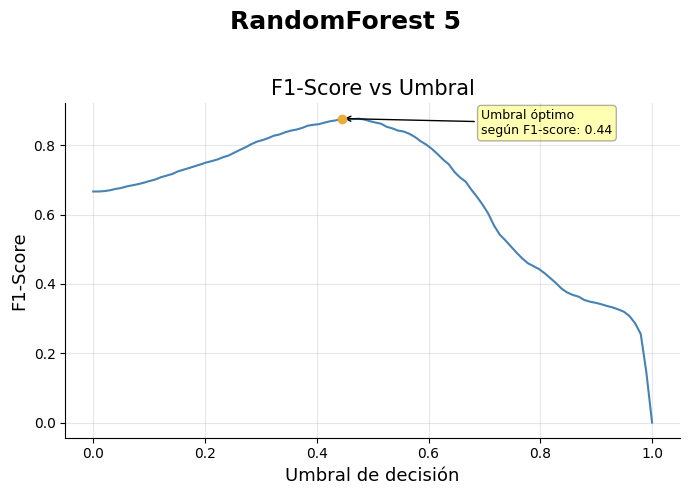

In [146]:
umbral_rf_5 = plot_umbrales(modelo=rf_5.best_estimator_,
                                score='F1-Score',
                                x=X_cv,
                                y=y_cv,
                                caja_x=0.25,
                                caja_y=0.045,
                                nombre='RandomForest 5')

In [147]:
rf_5_results_umbral = metricas_evaluacion(modelo=rf_5.best_estimator_,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 5',
                                   conjunto='X',
                                   umbral=0.44)

rf_results_tracking.append(rf_5_results_umbral)
pd.DataFrame(rf_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,RandomForest 1,X,0.7745,0.5729,0.7273,0.6409,0.8295,0.50
1,RandomForest 1,X,0.7596,0.5465,0.7710,0.6397,0.8295,0.46
2,RandomForest 2,X_scaled,0.7801,0.5981,0.6263,0.6118,0.8258,0.50
3,RandomForest 3,X[corr_features],0.7568,0.5471,0.7037,0.6156,0.8239,0.50
4,RandomForest 3,X[corr_features],0.7446,0.5262,0.7778,0.6277,0.8239,0.45
5,RandomForest 4,X[selected_cols],0.7586,0.5455,0.7677,0.6378,0.8228,0.47
6,RandomForest 5,X,0.7698,0.5654,0.7273,0.6362,0.8326,0.50
7,RandomForest 5,X,0.7409,0.5208,0.8013,0.6313,0.8326,0.44


### <font color='#8b5fc4'>**Observaciones: RandomForest 5 - GridSearchCV**</font>

Los hiperparámetros determinados por GridSearchCV para el modelo RandomForest que mejor se ajustan al conjunto de datos son:

* `max_depth=10`
* `min_samples_split=3`
* `min_samples_leaf=1`
* `n_estimators=250`

Con estas configuraciones, y ajustando el umbral de decisión a 0.44, el modelo `RandomForest 5` consigue superar a `RandomForest 1`.

### <font color='#f07c3e'>**RandomForest 6 - GridSearchCV - Más estimadores**</font>

Por último, debido a que el hiperparámetro `n_estimators` utilizado fue el máximo provisto en el `param_grid`. Se hará un ultimo experimento para explorar si el modelo podría beneficiarse de utilizar mayor cantidad de estimadores.

In [148]:
warnings.filterwarnings('error')

param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [200, 250, 300, 500]
}

rf_6 = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid=param_grid, scoring='recall',
                    cv=skf)

rf_6.fit(X_cv, y_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [200, 250, 300, 500]},
             scoring='recall')

In [150]:
rf_6.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [151]:
rf_6_results = metricas_evaluacion(modelo=rf_6.best_estimator_,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 6',
                                   conjunto='X')

rf_results_tracking.append(rf_6_results)
pd.DataFrame(rf_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,RandomForest 1,X,0.7745,0.5729,0.7273,0.6409,0.8295,0.50
1,RandomForest 1,X,0.7596,0.5465,0.7710,0.6397,0.8295,0.46
2,RandomForest 2,X_scaled,0.7801,0.5981,0.6263,0.6118,0.8258,0.50
3,RandomForest 3,X[corr_features],0.7568,0.5471,0.7037,0.6156,0.8239,0.50
4,RandomForest 3,X[corr_features],0.7446,0.5262,0.7778,0.6277,0.8239,0.45
5,RandomForest 4,X[selected_cols],0.7586,0.5455,0.7677,0.6378,0.8228,0.47
6,RandomForest 5,X,0.7698,0.5654,0.7273,0.6362,0.8326,0.50
7,RandomForest 5,X,0.7409,0.5208,0.8013,0.6313,0.8326,0.44
8,RandomForest 6,X,0.7689,0.5646,0.7205,0.6331,0.8319,0.50


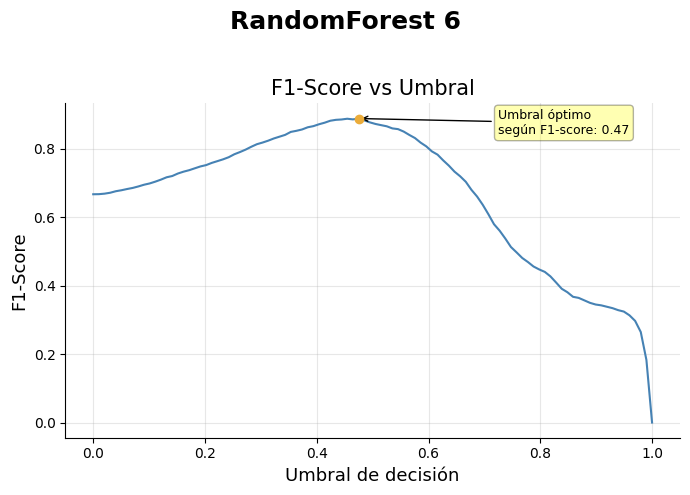

In [152]:
umbral_rf_6 = plot_umbrales(modelo=rf_6.best_estimator_,
                                score='F1-Score',
                                x=X_cv,
                                y=y_cv,
                                caja_x=0.25,
                                caja_y=0.045,
                                nombre='RandomForest 6')

In [153]:
rf_6_results_umbral = metricas_evaluacion(modelo=rf_6.best_estimator_,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 6',
                                   conjunto='X',
                                   umbral=0.47)

rf_results_tracking.append(rf_6_results_umbral)
pd.DataFrame(rf_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,RandomForest 1,X,0.7745,0.5729,0.7273,0.6409,0.8295,0.50
1,RandomForest 1,X,0.7596,0.5465,0.7710,0.6397,0.8295,0.46
2,RandomForest 2,X_scaled,0.7801,0.5981,0.6263,0.6118,0.8258,0.50
3,RandomForest 3,X[corr_features],0.7568,0.5471,0.7037,0.6156,0.8239,0.50
4,RandomForest 3,X[corr_features],0.7446,0.5262,0.7778,0.6277,0.8239,0.45
5,RandomForest 4,X[selected_cols],0.7586,0.5455,0.7677,0.6378,0.8228,0.47
6,RandomForest 5,X,0.7698,0.5654,0.7273,0.6362,0.8326,0.50
7,RandomForest 5,X,0.7409,0.5208,0.8013,0.6313,0.8326,0.44
8,RandomForest 6,X,0.7689,0.5646,0.7205,0.6331,0.8319,0.50
9,RandomForest 6,X,0.7614,0.5494,0.7677,0.6404,0.8319,0.47


### <font color='#8b5fc4'>**Observaciones: RandomForest 6: GridSearchCV - Más estimadores**</font>

Aún utilizando el doble de `n_estimators` y ajustando su umbral de decisión a su punto óptimo *(determinado por la métrica F1-score)* en **0.47**, este modelo no consigue superar a los líderes dentro de la familia Random Forest Classifier.

### <font color='#f07c3e'>**Comparación RandomForest 1 vs RandomForest 5: Umbrales de decisión**</font>

Si bien `RandomForest 5` consigue superar a `RandomForest 1` en la métrica prioritaria, el umbral definido para este último fue 0.46:

| Modelo        | Conjunto | Accuracy  | Precision| Recall   | F1-score | AUC       | Umbral|
|---------------|----------|-----------|----------|----------|----------|-----------|-------|
|RandomForest 1	| X	       | 0.7596	   | 0.5465	  | 0.7710	 | 0.6397	| 0.8295	| 0.46  |
|RandomForest 5	| X	       | 0.7409	   | 0.5208	  | 0.8013	 | 0.6313	| 0.8326	| 0.44  |

Por lo que, para comprar ambos modelos de manera "justa". Se establecerá el umbral de `RandomForest 1` en 0.44 para ver las variaciones en sus métricas.

In [154]:
best_rfs = []
rf_1_results_umbral2 = metricas_evaluacion(modelo=rf_1,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 1',
                                   conjunto='X',
                                   umbral=0.44)

rf_5_results_umbral2 = metricas_evaluacion(modelo=rf_5.best_estimator_,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 5',
                                   conjunto='X',
                                   umbral=0.46)

best_rfs.append(rf_1_results_umbral)
best_rfs.append(rf_5_results_umbral2)
best_rfs.append(rf_1_results_umbral2)
best_rfs.append(rf_5_results_umbral)

pd.DataFrame(best_rfs)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,RandomForest 1,X,0.7596,0.5465,0.7710,0.6397,0.8295,0.46
1,RandomForest 5,X,0.7558,0.5404,0.7879,0.6411,0.8326,0.46
2,RandomForest 1,X,0.7418,0.5220,0.7980,0.6312,0.8295,0.44
3,RandomForest 5,X,0.7409,0.5208,0.8013,0.6313,0.8326,0.44


### <font color='#8b5fc4'>**Observaciones: Comparación RandomForest 1 vs RandomForest 5: Umbrales de decisión**</font>

Aún reduciendo el umbral de decisión de `RandomForest 1` a **0.44**, este no consigue superar el **Recall** de `RandomForest 5`.

Esto demuestra que los hiperparámetros obtenidos por `GridSearchCV` consiguen mejorar la performance del modelo al separar las clases del conjunto de datos.

## <font color='#ebac3a'>**Conclusiones Random Forest Classifier**</font>

Luego de entrenar 6 modelos distintos, el que demostró **mejor desempeño general** fue `RandomForest 5`, el cual **se optimizó mediante `GridSearchCV` para determinar los hiperparámetros que calibraran el modelo al conjunto de datos**, utilizando todas las variables sin filtrado previo. Y utilizando un umbral de decisión de 0.44, determinado por la métrica **F1-score**

Sus métricas de evaluación frente al modelo base (`BaselineModel`):

|Modelo         | Conjunto | Accuracy  | Precision | Recall    | F1-Score  | AUC      | Umbral  |
|---------------|----------|-----------|-----------|-----------|-----------|----------|---------|
|Baseline Model	| X	       | 0.7158	   | 0.4896	   | 0.6364	   | 0.5534	   | 0.7418	  | 0.5     |
|RandomForest 5	| X	       | 0.7409	   | 0.5208	   | 0.8013	   | 0.6313	   | 0.8326	  | 0.44    |

El algoritmo de **Random Forest Classifier** fue capaz de superar en todas sus métricas al modelo base (`Decision Tree Classifier`).

* **Accuracy**: 0.7158 -> 0.7409 = +0.0251 (**+2.51%**)
* **Precision**: 0.4896 -> 0.5208 = +0.0312 (**+3.12%**)
* **Recall**: 0.6364 -> 0.8013 = +0.1649 (**+16.49%**)
* **F1-score**: 0.5534 -> 0.6313 = +0.0778 (**+7.78%**)
* **AUC**: 0.7418 -> 0.8326 = +0.0907 (**+9.07%**)

La mejora más significativa se observa en **Recall**, lo cual respalda los objetivos del proyecto, ya que se prioriza la **correcta identificación de potenciales abandonos**.
Esto refuerza la elección del modelo y demuestra su capacidad para **manejar variables en distintas escalas** y entregar un rendimiento robusto en tareas de clasificación desbalanceada.

Por lo tanto, se conservará `RandomForest 5` como el mejor modelo de esta familia.

In [155]:
best_models.append(rf_5_results_umbral)

In [156]:
pd.DataFrame(best_models)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Baseline Model,X,0.6915,0.4663,0.7912,0.5868,0.7418,0.41
1,RandomForest 5,X,0.7409,0.5208,0.8013,0.6313,0.8326,0.44


In [157]:
with open('best_randomforest.pkl', 'wb') as f:
    pickle.dump(rf_5.best_estimator_, f)

## <font color='#ebac3a'>**Logistic Regresion**</font>

A diferencia del modelo RandomForest, la Regresión Logística es sensible a outliers y a la escala de los datos. Además, a menos que se utilice la regularización Lasso que penaliza la complejidad del modelo, este, también es sensible a la multicolinealidad.

Por esta razón, se iniciará entrenando una **Regresión Logística** básica, utilizando los datos de entrenamiento `X_linear`, el cual fue codificado con `OneHotEncoder(drop='first')` y con las variables numéricas escaladas.

Además, para la regularización Lasso, se utilizará el conjunto `X_scaled`, el cual cuenta con variables categoricas codificadas utilizando `OneHotEncoder(drop='if_binary')` pero con las variables numéricas escaladas.

In [161]:
lr_results_tracking = []

### <font color='#f07c3e'>**LogisticRegression 1**</font>

In [162]:
lr_1 = LogisticRegression(random_state=42)

lr_1_cv_results = cross_validate(lr_1, X_linear_cv, y_linear_cv, cv=skf, scoring='recall')

In [163]:
cv_score_interval(results=lr_1_cv_results,
                  nombre='LogisticRegression 1',
                  score='Recall')

Recall promedio de LogisticRegression 1: 0.5601
Desviación estándar del Recall de LogisticRegression 1: 0.0369
El Recall de LogisticRegression 1 estará entre [0.4863,0.6339] con un 95% de confianza


In [164]:
lr_1.fit(X_linear_cv, y_linear_cv)

LogisticRegression(random_state=42)

In [165]:
lr_1_results = metricas_evaluacion(modelo=lr_1,
                                   x_test=X_linear_test,
                                   y_test=y_linear_test,
                                   nombre='LogisticRegression 1',
                                   conjunto='X_linear')

lr_results_tracking.append(lr_1_results)
pd.DataFrame(lr_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,LogisticRegression 1,X_linear,0.7541,0.568,0.6006,0.5839,0.7976,0.5


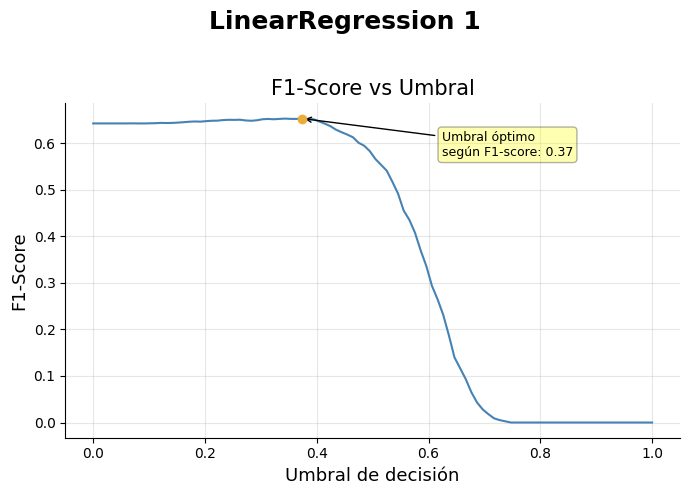

In [166]:
umbral_lr_1 = plot_umbrales(modelo=lr_1,
                            score='F1-Score',
                            x=X_linear_cv,
                            y=y_linear_cv,
                            caja_x=0.25,
                            caja_y=0.08,
                            nombre='LinearRegression 1')

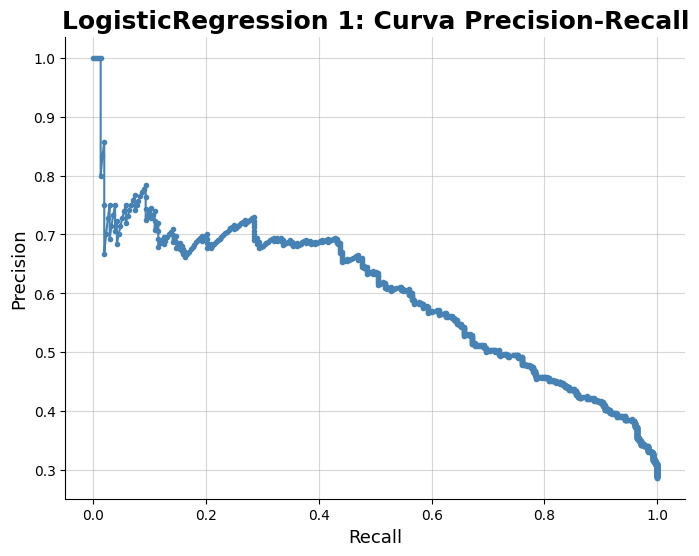

In [167]:
plot_precision_recall_curve(modelo=lr_1,
                            x=X_linear_test,
                            y=y_linear_test,
                            nombre='LogisticRegression 1')

#### <font color='#8b5fc4'>**Observaciones: LogisticRegression 1 - Curva Precision-Recall**</font>

Como puede observarse en la **Curva Precisión-Recall**, el modelo `LogisticRegression 1` para alcanzar 0.8 en **Recall** deberá sacrificar su precisión hasta aproximadamente 0.48.

El umbral de decisión determinado por la métrica **F1-Score**, se corresponde a 0.36. Es decir que aquellos clientes que tengan una **probabilidad de abandono de 36%**, serán clasificados como `Churn=1`.

A simple vista este valor parece ser demasiado bajo, sin embargo, se explorarán las metricas obtenidas según el umbral determinado por la metrica mencionada anteriormente.

In [168]:
lr_1_results_umbral = metricas_evaluacion(modelo=lr_1,
                                   x_test=X_linear_test,
                                   y_test=y_linear_test,
                                   nombre='LogisticRegression 1',
                                   conjunto='X_linear',
                                   umbral=0.36)

lr_results_tracking.append(lr_1_results_umbral)
pd.DataFrame(lr_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,LogisticRegression 1,X_linear,0.7541,0.5680,0.6006,0.5839,0.7976,0.50
1,LogisticRegression 1,X_linear,0.6211,0.4228,0.8754,0.5702,0.7976,0.36


In [169]:
pd.DataFrame({'Features': X_linear_cv.columns.values, 'Coeficiente': lr_1.coef_[0]}).sort_values('Coeficiente', ascending=False)

,Features,Coeficiente
22,ChargesTotal_scaled,0.993463
6,InternetService_Fiber optic,0.264777
21,ChargesMonthly_scaled,0.248573
18,PaymentMethod_Electronic check,0.185787
1,SeniorCitizen_Yes,0.182453
5,MultipleLines_Yes,0.177808
16,PaperlessBilling_Yes,0.174075
15,Contract_Two year,0.157321
12,StreamingTV_Yes,0.133133
13,StreamingMovies_Yes,0.045071


### <font color='#8b5fc4'>**Observaciones: LogisticRegression 1 - Conjunto X_linear**</font>

Este modelo inicial dentro de la familia de **Logistic Regression** consigue un **Recall** muy elevado al utilizar un umbral de decisión de 0.36.
A diferencia del umbral por defecto (0.5), la métrica prioritaria consigue un **amuento de casi 30%**, con un sacrificio en Precision de aproximadamente **12%**.

Si bien el trade-off se justifica, incurrir en demasiados **falsos positivos** puede llevar a la empresa a campañas de retención ineficientes en costos.
Sin embargo, como modelo base dentro de la familia, sus métricas son más que aceptables, por lo que, partiendo de esta base, se realizarán diversos experimentos que permitan al menos mantener el **Recall** obtenido y mejorar la **Precisión** del modelo.

### <font color='#f07c3e'>**LogisticRegression 2 - Feature Selection**</font>

In [170]:
lr_1_coef = pd.DataFrame({'Feature': X_linear_cv.columns.values, 'Coeficiente': np.abs(lr_1.coef_[0])}).sort_values('Coeficiente', ascending=False)
len(lr_1_coef)

23

In [171]:
lr_1_coef

,Feature,Coeficiente
20,Tenure_scaled,1.854028
22,ChargesTotal_scaled,0.993463
4,PhoneService_Yes,0.537102
6,InternetService_Fiber optic,0.264777
21,ChargesMonthly_scaled,0.248573
8,OnlineSecurity_Yes,0.216076
11,TechSupport_Yes,0.187976
18,PaymentMethod_Electronic check,0.185787
1,SeniorCitizen_Yes,0.182453
5,MultipleLines_Yes,0.177808


In [172]:
feature_selection = []

ct_features = [i if i != 0 else 1 for i in range(0, len(lr_1_coef), 3)]

for i in ct_features:
    model_features = LogisticRegression(random_state=42)
    selected_features = lr_1_coef['Feature'].values[:i]
    X_train_sel = X_linear_cv[selected_features]
    X_test_sel = X_linear_test[selected_features]
    model_features.fit(X_train_sel, y_linear_cv)
    metricas = metricas_evaluacion(model_features, X_test_sel, y_linear_test, f'Features: {i}', 'X_linear')
    feature_selection.append(metricas)

pd.DataFrame(feature_selection)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Features: 1,X_linear,0.6982,0.4677,0.3706,0.4135,0.6840,0.5
1,Features: 3,X_linear,0.7037,0.4870,0.6006,0.5379,0.7428,0.5
2,Features: 6,X_linear,0.7450,0.5516,0.5974,0.5736,0.7917,0.5
3,Features: 9,X_linear,0.7661,0.5873,0.6230,0.6047,0.8050,0.5
4,Features: 12,X_linear,0.7624,0.5813,0.6166,0.5984,0.8001,0.5
5,Features: 15,X_linear,0.7541,0.5676,0.6038,0.5851,0.7973,0.5
6,Features: 18,X_linear,0.7587,0.5758,0.6070,0.5910,0.7977,0.5
7,Features: 21,X_linear,0.7560,0.5710,0.6038,0.5870,0.7981,0.5


In [173]:
selected_features = lr_1_coef['Feature'][:6]

In [174]:
lr_2 = LogisticRegression(random_state=42)

lr_2_cv_results = cross_validate(lr_2,
                                 X_linear_cv[selected_features],
                                 y_linear_cv,
                                 scoring='recall',
                                 cv=skf)

In [175]:
cv_score_interval(results=lr_2_cv_results,
                  nombre='LogisticRegression 2',
                  score='Recall')

Recall promedio de LogisticRegression 2: 0.5666
Desviación estándar del Recall de LogisticRegression 2: 0.0277
El Recall de LogisticRegression 2 estará entre [0.5112,0.6220] con un 95% de confianza


In [176]:
lr_2.fit(X_linear_cv[selected_features], y_linear_cv)

LogisticRegression(random_state=42)

In [177]:
lr_2_results = metricas_evaluacion(modelo=lr_2,
                                   x_test=X_linear_test[selected_features],
                                   y_test=y_linear_test,
                                   nombre='LogisticRegression 2',
                                   conjunto='X_linear[selected_features]')

lr_results_tracking.append(lr_2_results)
pd.DataFrame(lr_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,LogisticRegression 1,X_linear,0.7541,0.5680,0.6006,0.5839,0.7976,0.50
1,LogisticRegression 1,X_linear,0.6211,0.4228,0.8754,0.5702,0.7976,0.36
2,LogisticRegression 2,X_linear[selected_features],0.7450,0.5516,0.5974,0.5736,0.7917,0.50


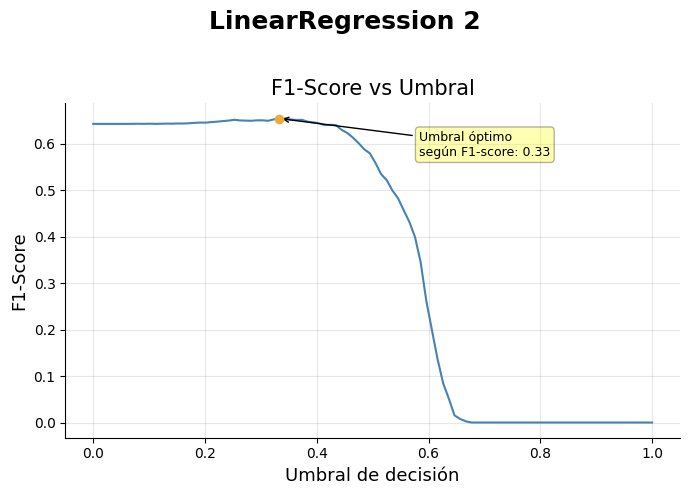

In [178]:
umbral_lr_2 = plot_umbrales(modelo=lr_2,
                            score='F1-Score',
                            x=X_linear_cv[selected_features],
                            y=y_linear_cv,
                            caja_x=0.25,
                            caja_y=0.08,
                            nombre='LinearRegression 2')

In [179]:
lr_2_results_umbral = metricas_evaluacion(modelo=lr_2,
                                   x_test=X_linear_test[selected_features],
                                   y_test=y_linear_test,
                                   nombre='LogisticRegression 2',
                                   conjunto='X_linear[selected_features]',
                                   umbral=0.36)

lr_results_tracking.append(lr_2_results_umbral)
pd.DataFrame(lr_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,LogisticRegression 1,X_linear,0.7541,0.5680,0.6006,0.5839,0.7976,0.50
1,LogisticRegression 1,X_linear,0.6211,0.4228,0.8754,0.5702,0.7976,0.36
2,LogisticRegression 2,X_linear[selected_features],0.7450,0.5516,0.5974,0.5736,0.7917,0.50
3,LogisticRegression 2,X_linear[selected_features],0.6046,0.4127,0.8914,0.5642,0.7917,0.36


### <font color='#8b5fc4'>**Observaciones: LogisticRegression 2: Feature Selection**</font>

La selección manual de features a partir de los coeficientes obtenidos por `LogisticRegression 1` aportan una leve mejora en **Recall** de **1.01%**, con un trade-off de **0.19%** en Precisión. Utilizando el mismo **umbral de decisión en 0.36**.

Si bien esto es una mejora en la métrica prioritaria, lo que se busca mejorar es la precisión de este primer modelo mantieniendo el **Recall** obtenido. Por lo que se seguirán explorando opciones que mejoren el desempeño.

### <font color='#f07c3e'>**LogisticRegression 3: Penalty L1 (Lasso) - Conjunto X_scaled**</font>

In [180]:
lr_3 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)

lr_3_cv_results = cross_validate(lr_3,
                                X_scaled_cv,
                                y_scaled_cv,
                                scoring='recall',
                                cv=skf)

In [181]:
cv_score_interval(results=lr_3_cv_results,
                  nombre='LogisticRegression 3',
                  score='Recall')

Recall promedio de LogisticRegression 3: 0.6467
Desviación estándar del Recall de LogisticRegression 3: 0.0311
El Recall de LogisticRegression 3 estará entre [0.5845,0.7089] con un 95% de confianza


In [182]:
lr_3.fit(X_scaled_cv, y_scaled_cv)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

In [183]:
lr_3_results = metricas_evaluacion(modelo=lr_3,
                                   x_test=X_scaled_test,
                                   y_test=y_scaled_test,
                                   nombre='LogisticRegression 3',
                                   conjunto='X_scaled')

lr_results_tracking.append(lr_3_results)
pd.DataFrame(lr_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,LogisticRegression 1,X_linear,0.7541,0.5680,0.6006,0.5839,0.7976,0.50
1,LogisticRegression 1,X_linear,0.6211,0.4228,0.8754,0.5702,0.7976,0.36
2,LogisticRegression 2,X_linear[selected_features],0.7450,0.5516,0.5974,0.5736,0.7917,0.50
3,LogisticRegression 2,X_linear[selected_features],0.6046,0.4127,0.8914,0.5642,0.7917,0.36
4,LogisticRegression 3,X_scaled,0.7193,0.5081,0.6997,0.5887,0.7816,0.50


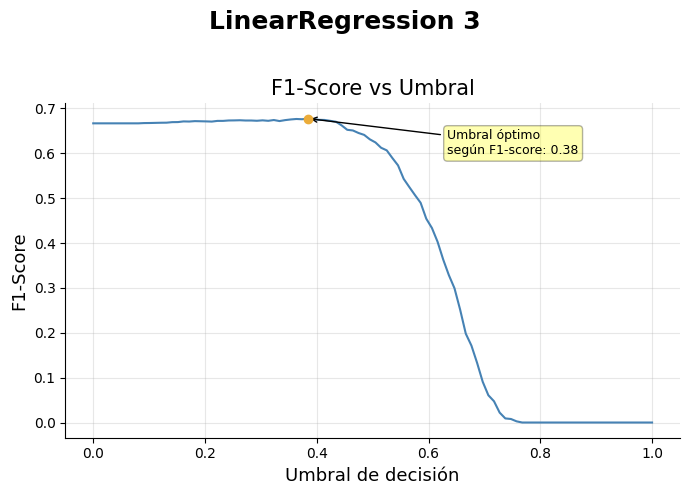

In [184]:
umbral_lr_3 = plot_umbrales(modelo=lr_3,
                            score='F1-Score',
                            x=X_scaled_cv,
                            y=y_scaled_cv,
                            caja_x=0.25,
                            caja_y=0.08,
                            nombre='LinearRegression 3')

In [185]:
lr_3_results_umbral = metricas_evaluacion(modelo=lr_3,
                                   x_test=X_scaled_test,
                                   y_test=y_scaled_test,
                                   nombre='LogisticRegression 3',
                                   conjunto='X_scaled',
                                   umbral=0.34)

lr_results_tracking.append(lr_3_results_umbral)
pd.DataFrame(lr_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,LogisticRegression 1,X_linear,0.7541,0.5680,0.6006,0.5839,0.7976,0.50
1,LogisticRegression 1,X_linear,0.6211,0.4228,0.8754,0.5702,0.7976,0.36
2,LogisticRegression 2,X_linear[selected_features],0.7450,0.5516,0.5974,0.5736,0.7917,0.50
3,LogisticRegression 2,X_linear[selected_features],0.6046,0.4127,0.8914,0.5642,0.7917,0.36
4,LogisticRegression 3,X_scaled,0.7193,0.5081,0.6997,0.5887,0.7816,0.50
5,LogisticRegression 3,X_scaled,0.5468,0.3801,0.9169,0.5375,0.7816,0.34


In [186]:
pd.DataFrame(best_models)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Baseline Model,X,0.6523,0.4406,0.7827,0.5639,0.7238,0.41


In [187]:
X_scaled_cv.columns.values

array(['Gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes',
       'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'NoInternetService', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure_scaled', 'ChargesMonthly_scaled', 'ChargesTotal_scaled'],
      dtype=object)

In [188]:
lr_3.coef_

array([[ 0.00375789,  0.18396821,  0.        , -0.16838128, -0.46266772,
         0.13257815, -0.22338834,  0.1069596 ,  0.        , -0.23928333,
        -0.13135108, -0.08136163, -0.27208291,  0.11111   ,  0.00243393,
        -0.11353446,  0.        ,  0.28630535,  0.17648631, -0.18711524,
        -0.2073966 ,  0.02570178,  0.        , -2.37827246,  0.13746198,
         1.37013397]])

In [189]:
pd.DataFrame({'Features': X_scaled_cv.columns.values, 'Coeficiente': lr_3.coef_[0]}).sort_values('Coeficiente', ascending=False)

,Features,Coeficiente
25,ChargesTotal_scaled,1.370134
17,Contract_Two year,0.286305
1,SeniorCitizen_Yes,0.183968
18,PaperlessBilling_Yes,0.176486
24,ChargesMonthly_scaled,0.137462
5,MultipleLines_Yes,0.132578
13,StreamingTV_Yes,0.111110
7,InternetService_Fiber optic,0.106960
21,PaymentMethod_Electronic check,0.025702
0,Gender_Male,0.003758


In [190]:
pd.DataFrame(lr_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,LogisticRegression 1,X_linear,0.7541,0.5680,0.6006,0.5839,0.7976,0.50
1,LogisticRegression 1,X_linear,0.6211,0.4228,0.8754,0.5702,0.7976,0.36
2,LogisticRegression 2,X_linear[selected_features],0.7450,0.5516,0.5974,0.5736,0.7917,0.50
3,LogisticRegression 2,X_linear[selected_features],0.6046,0.4127,0.8914,0.5642,0.7917,0.36
4,LogisticRegression 3,X_scaled,0.7193,0.5081,0.6997,0.5887,0.7816,0.50
5,LogisticRegression 3,X_scaled,0.5468,0.3801,0.9169,0.5375,0.7816,0.34


### <font color='#8b5fc4'>**Observaciones: LogisticRegression 3: Penalty L1 (Lasso) - Conjunto X_scaled**</font>

Al comparar el modelo inicial de esta familia con el modelo entrenado utilizando penalización Lasso (`LogisticRegression 2`), se observa que consigue mejorar el **Recall** con su correspondiente trade-off en **Precisión**. Utilizando un **umbral de decisión de 0.34**.

La regularización L1 **automatizó la selección de variables**, reduciendo a cero los coeficientes de aquellas consideradas poco relevantes por el modelo:

- `OnlineBackup_Yes`
- `Contract_One year`
- `PaymentMethod_Mailed check`

Su desempeño global es levemente inferior, mostrando un **F1-score 1.38% más bajo** en comparación a `LogisticRegression 1`.

La métrica prioritaria (**Recall**) obtiene una mejora de **+2.36%**, pero tanto **Precision como F1-score** fueron inferiores en el modelo con penalización L1.

* **Precision: -1.95%**
* **F1-score: -1.38%**

Este modelo puede postularse como buen candidato de la familia ya que el **Recall** obtenido es elevado.

### <font color='#f07c3e'>**LogisticRegression 4 - GridSearchCV - Conjunto X_linear**</font>

In [192]:
warnings.filterwarnings('error')

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs'],
    'max_iter': [100, 200, 500]
}

lr_4 = GridSearchCV(LogisticRegression(random_state=42),
                    param_grid=param_grid,
                    scoring='recall',
                    cv=skf)

lr_4.fit(X_linear_cv, y_linear_cv)

ValueError: 
All the 108 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1350, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py", line 77, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/joblib/parallel.py", line 1986, in __call__
    return output if self.return_generator else list(output)
                                                ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/joblib/parallel.py", line 1914, in _get_sequential_output
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py", line 139, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 451, in _logistic_regression_path
    opt_res = optimize.minimize(
              ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/scipy/optimize/_minimize.py", line 784, in minimize
    res = _minimize_lbfgsb(fun, x0, args, jac, bounds,
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/scipy/optimize/_lbfgsb_py.py", line 387, in _minimize_lbfgsb
    warnings.warn("scipy.optimize: The `disp` and `iprint` options of the "
DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.


In [ ]:
lr_4.best_params_

In [ ]:
lr_4_results = metricas_evaluacion(modelo=lr_4.best_estimator_,
                                   x_test=X_linear_test,
                                   y_test=y_linear_test,
                                   nombre='LogisticRegression 4',
                                   conjunto='X_linear')

lr_results_tracking.append(lr_4_results)
pd.DataFrame(lr_results_tracking)

In [ ]:
umbral_lr_4 = plot_umbrales(modelo=lr_4.best_estimator_,
                            score='F1-Score',
                            x=X_linear_cv,
                            y=y_linear_cv,
                            caja_x=0.25,
                            caja_y=0.08,
                            nombre='LinearRegression 4')

In [ ]:
lr_4_results_umbral = metricas_evaluacion(modelo=lr_4,
                                   x_test=X_linear_test,
                                   y_test=y_linear_test,
                                   nombre='LogisticRegression 4',
                                   conjunto='X_linear',
                                   umbral=0.43)

lr_results_tracking.append(lr_4_results_umbral)
pd.DataFrame(lr_results_tracking)

### <font color='#8b5fc4'>**Observaciones: LogisticRegression 4 - GridSearchCV - Conjunto X_linear**</font>

El ajuste de hiperparámetros sobre LogisticRegression 1, consigue un recall elevado al utilizar un umbral de decisión de 0.43, sin embargo, el trade-off con **Precisión** es demasiado elevado, dejando 33% de casos donde el modelo predice correctamente clientes que no tienden a abandonar el servicio.

Esto implica que 2 de cada 3 clientes que no tienen probabilidades de abandonar, serán intervenidos en campañas de retención, lo que podría elevar desmesuradamente los costos de dichas campañas.

Por lo que, debido a su **Precisión**, este modelo se descarta como representante de su familia.

### <font color='#f07c3e'>**LogisticRegression 5 - GridSearchCV - Selected Features - Conjunto X_linear**</font>

In [ ]:
lr_4_coef = pd.DataFrame({'Feature': X_linear_cv.columns.values, 'Coeficiente': np.abs(lr_4.best_estimator_.coef_[0])}).sort_values('Coeficiente', ascending=False)
len(lr_4_coef)

In [ ]:
feature_selection = []

ct_features = [i if i != 0 else 1 for i in range(0, len(lr_4_coef), 3)]

for i in ct_features:
    model_features = LogisticRegression(random_state=42)
    selected_features = lr_4_coef['Feature'].values[:i]
    X_train_sel = X_linear_cv[selected_features]
    X_test_sel = X_linear_test[selected_features]
    model_features.fit(X_train_sel, y_linear_cv)
    metricas = metricas_evaluacion(model_features, X_test_sel, y_linear_test, f'Features: {i}', 'X_linear')
    feature_selection.append(metricas)

pd.DataFrame(feature_selection)

In [ ]:
selected_features = lr_4_coef['Feature'][:12].values
selected_features

In [ ]:
warnings.filterwarnings('error')

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs'],
    'max_iter': [100, 200, 500]
}

lr_5 = GridSearchCV(LogisticRegression(random_state=42),
                    param_grid=param_grid,
                    scoring='recall',
                    cv=skf)

lr_5.fit(X_linear_cv[selected_features], y_linear_cv)

In [ ]:
lr_5.best_params_

In [ ]:
lr_5_results = metricas_evaluacion(modelo=lr_5.best_estimator_,
                                   x_test=X_linear_test[selected_features],
                                   y_test=y_linear_test,
                                   nombre='LogisticRegression 5',
                                   conjunto='X_linear[selected_features]')

lr_results_tracking.append(lr_5_results)
pd.DataFrame(lr_results_tracking)

In [ ]:
umbral_lr_5 = plot_umbrales(modelo=lr_5.best_estimator_,
                            score='F1-Score',
                            x=X_linear_cv[selected_features],
                            y=y_linear_cv,
                            caja_x=0.25,
                            caja_y=0.08,
                            nombre='LinearRegression 5')

In [ ]:
lr_5_results_umbral = metricas_evaluacion(modelo=lr_5.best_estimator_,
                                           x_test=X_linear_test[selected_features],
                                           y_test=y_linear_test,
                                           nombre='LogisticRegression 5',
                                           conjunto='X_linear[selected_features]',
                                           umbral=0.34)

lr_results_tracking.append(lr_5_results_umbral)
pd.DataFrame(lr_results_tracking)

### <font color='#8b5fc4'>**Observaciones: LogisticRegression 5 - GridSearchCV - Selected Features - Conjunto X_linear**</font>

Se seleccionaron las 12 variables con mayor impacto *(mayores coeficientes absolutos)* determinadas por `LogisticRegression 4` para simplificar el modelo:

* `Tenure`
* `InternetService_Fiber optic`
* `ChargesTotal`
* `PaymentMethod_Electronic check`
* `ChargesMonthly`
* `PaperlessBilling_Yes`
* `OnlineSecurity_Yes`
* `TechSupport_Yes`
* `Contract_One year`
* `SeniorCitizen_Yes`
* `Dependents_Yes`
* `Partner_Yes`

Esto, permitió que el modelo `LinearRegression 5` métricas superiores a las presentadas por el modelo que se consideró anteriormente como candidato a representate de la familia `LogisticRegression 3` ambos utilizando el mismo umbral:

|Modelo               | Conjunto                    | Accuracy  | Precision | Recall    | F1-Score  | AUC      | Umbral  |
|---------------------|-----------------------------|-----------|-----------|-----------|-----------|----------|---------|
|LogisticRegression 1 |	X_linear	                | 0.6300	| 0.4204	| 0.8889	| 0.5708	| 0.8052   | 0.36    |
|LogisticRegression 3 |	X_scaled                    | 0.5983	| 0.4009	| 0.9125	| 0.5570	| 0.7974   | 0.34    |
|LogisticRegression 5 |	X_linear[selected_features]	| 0.6207	| 0.4164	| 0.9226	| 0.5738	| 0.8137   | 0.34    |


En todos los casos en los que se modificó el umbral de decisión para mejorar el **Recall**, se produce inevitablemente una disminución en la Precisión, sin embargo, el modelo `LogisticRegression 5` obtiene el **uno de los valores de Recall más altos hasta el momento**, con una precisión levemente más baja (**-0.4%**) en relación al modelo *(con umbral de decisión modificado)* con mejor **Precisión** `Logistic Regression 1`

La capacidad de este de **identificar el 92.26% de los casos reales de abandono**, lo posiciona como una muy buena opción para representar esta familia.

Además, los modelos lineales como `Logistic Regression` son interpretables a partir de sus coeficientes, lo que permite evaluar cuál es el impacto de cada variable independiente en la variable dependiente.

### <font color='#f07c3e'>**LogisticRegression 6 - GridSearchCV: Penalty L1 (Lasso) - Conjunto X_scaled**</font>

In [ ]:
warnings.filterwarnings('error')

param_grid = {
    'C': [0.1, 0.5, 1, 1.5, 2],
    'max_iter': [100, 200, 500]
}

lr_6 = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear', random_state=42),
                    param_grid=param_grid,
                    scoring='recall',
                    cv=skf)

lr_6.fit(X_scaled_cv, y_scaled_cv)

In [ ]:
lr_6.best_params_

In [ ]:
lr_6_results = metricas_evaluacion(modelo=lr_6.best_estimator_,
                                   x_test=X_scaled_test,
                                   y_test=y_linear_test,
                                   nombre='LogisticRegression 6',
                                   conjunto='X_scaled')

lr_results_tracking.append(lr_6_results)
pd.DataFrame(lr_results_tracking)

In [ ]:
umbral_lr_6 = plot_umbrales(modelo=lr_6.best_estimator_,
                            score='F1-Score',
                            x=X_scaled_cv,
                            y=y_scaled_cv,
                            caja_x=0.25,
                            caja_y=0.08,
                            nombre='LinearRegression 6')

In [ ]:
lr_6_results_umbral = metricas_evaluacion(modelo=lr_6.best_estimator_,
                                           x_test=X_scaled_test,
                                           y_test=y_scaled_test,
                                           nombre='LogisticRegression 6',
                                           conjunto='X_scaled',
                                           umbral=0.27)

lr_results_tracking.append(lr_6_results_umbral)
pd.DataFrame(lr_results_tracking)

In [ ]:
lr_6_coef = pd.DataFrame({'Feature': X_scaled_cv.columns.values, 'Coeficiente': lr_6.best_estimator_.coef_[0]}).sort_values('Coeficiente', ascending=False)
lr_6_coef

### <font color='#8b5fc4'>**Observaciones: LogisticRegression 6 - GridSearchCV: Penalty L1 (Lasso) - Conjunto X_scaled**</font>

El modelo `LogisticRegression 6` con penalidad L1 (Lasso), penaliza la excesiva complejidad del modelo, reduciendo a 0 los coeficientes de variables que considera tienen poco impacto en la predicción de la variable respuesta.
Las variables descartadas fueron:

* `PaymentMethod_Mailed check`
* `DeviceProtection_Yes`
* `Contract_One year`

Al modificar el umbral de decisión, obtiene el mismo **Recall** que `LogisticRegression 4` (**0.9596**), con una leve mejora en su **Precisión**, sin embargo, esta última sigue siendo demasiado baja, lo que se traduce, como se observó en dicho análisis, en costos innecesarios para la empresa.

In [ ]:
pd.DataFrame(lr_results_tracking)

## <font color='#ebac3a'>**Conclusiones Logistic Regresion**</font>

Los mejores candidatos de esta familia fueron:

|Modelo               | Conjunto                    | Accuracy  | Precision | Recall    | F1-Score  | AUC      | Umbral  |
|---------------------|-----------------------------|-----------|-----------|-----------|-----------|----------|---------|
|LogisticRegression 1 |	X_linear	                | 0.6300	| 0.4204	| 0.8889	| 0.5708	| 0.8052   | 0.36    |
|LogisticRegression 3 |	X_scaled                    | 0.5983	| 0.4009	| 0.9125	| 0.5570	| 0.7974   | 0.34    |
|LogisticRegression 5 |	X_linear[selected_features]	| 0.6207	| 0.4164	| 0.9226	| 0.5738	| 0.8137   | 0.34    |

Entre ellos, se selecciona a `LogisticRegression 5` como el mejor representante de esta familia, debido a su elevado **Recall** *(métrica prioritaria)*. Además presenta el mejor valor de **AUC** *(área bajo la curva)* y **F1-score**.
Este, fue entrenado utilizando 12 features, que tambien se guardarán para las comparaciones finales entre modelos representantes de cada familia, con el objetivo de evaluar el mejor candidato para entornos productivos.

In [ ]:
best_models.append(lr_5_results_umbral)
pd.DataFrame(best_models)

In [ ]:
with open('best_logreg.pkl', 'wb') as f:
    pickle.dump(lr_5.best_estimator_, f)

In [ ]:
with open('features_best_logreg.pkl', 'wb') as f:
    pickle.dump(selected_features, f)

## <font color='#ebac3a'>**K-Nearest Neighbors (KNN)**</font>

El modelo K-Nearest Neighbors (KNN) es un clasificador basado en la proximidad entre observaciones, utilizando por defecto la distancia euclídea como métrica.
Esto lo hace particularmente **sensible a la escala de las variables y a la presencia de outliers**, ya que estos pueden influir fuertemente en el cálculo de las distancias.

Además, el desempeño del modelo **depende fuertemente del parámetro k**, que define cuántos "vecinos" se consideran para determinar la clase de una nueva observación. Valores de k muy bajos pueden llevar a sobreajuste, mientras que valores demasiado altos pueden suavizar excesivamente las fronteras de decisión.

Debido a que KNN no aprende una función explícita durante el entrenamiento, sino que **realiza los cálculos de distancia** durante la predicción, se considera un modelo perezoso y relativamente costoso computacionalmente en grandes conjuntos de datos (si bien no es el caso ya que el conjunto de datos balanceado cuenta con aproximadamente 3300 observaciones).

Por estas razones, se realizará inicialmente una búsqueda de hiperparámetros mediante `GridSearchCV` para determinar el valor óptimo de k.

En cuanto al conjunto de datos, se utilizará `X_linear`, ya que además de ser sensible a escalas, este modelo no maneja bien la multicolinealidad.

In [193]:
knn_results_tracking = []

### <font color='#f07c3e'>**KNN 1: GridSearchCV - Conjunto X_linear**</font>

In [194]:
param_grid = {'n_neighbors': [3, 4, 5, 6, 7],
              'leaf_size': [5, 10, 15, 20]}

knn_1 = GridSearchCV(knn(), param_grid=param_grid, scoring='recall', cv=skf)

knn_1.fit(X_linear_cv, y_linear_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [5, 10, 15, 20],
                         'n_neighbors': [3, 4, 5, 6, 7]},
             scoring='recall')

In [195]:
knn_1.best_params_

{'leaf_size': 5, 'n_neighbors': 7}

In [196]:
knn_1_results = metricas_evaluacion(modelo=knn_1.best_estimator_,
                                    x_test=X_linear_test,
                                    y_test=y_linear_test,
                                    nombre='KNN 1',
                                    conjunto='X_linear')

knn_results_tracking.append(knn_1_results)
pd.DataFrame(knn_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,KNN 1,X_linear,0.6881,0.4642,0.5591,0.5072,0.7064,0.5


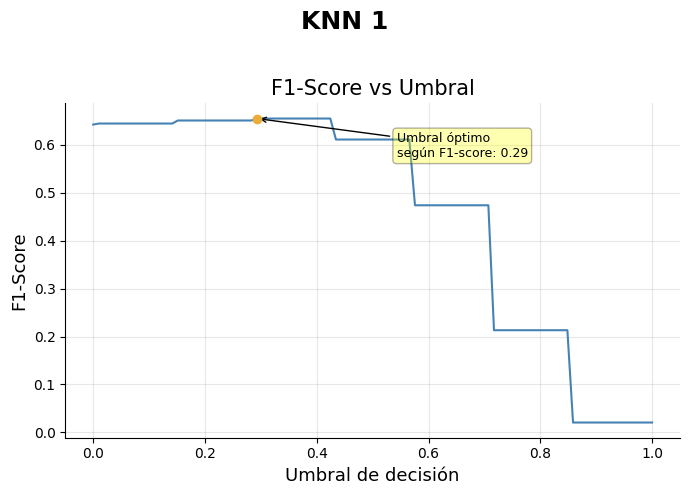

In [197]:
umbral_knn_1 = plot_umbrales(modelo=knn_1.best_estimator_,
                             score='F1-Score',
                             x=X_linear_cv,
                             y=y_linear_cv,
                             caja_x=0.25,
                             caja_y=0.08,
                             nombre='KNN 1')

In [198]:
knn_1_results_umbral = metricas_evaluacion(modelo=knn_1.best_estimator_,
                                    x_test=X_linear_test,
                                    y_test=y_linear_test,
                                    nombre='KNN 1',
                                    conjunto='X_linear',
                                    umbral=0.29)

knn_results_tracking.append(knn_1_results_umbral)
pd.DataFrame(knn_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,KNN 1,X_linear,0.6881,0.4642,0.5591,0.5072,0.7064,0.50
1,KNN 1,X_linear,0.5853,0.3922,0.8083,0.5282,0.7064,0.29


In [199]:
pd.DataFrame(best_models)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Baseline Model,X,0.6523,0.4406,0.7827,0.5639,0.7238,0.41


### <font color='#8b5fc4'>**Observaciones: KNN 1 - GridSearchCV - Conjunto X_linear**</font>

El GridSearch determinó que los hiperparámetros óptimos para el modelo son:

* `leaf_size = 5`
* `n_neighbors = 7`

Este modelo consigue superar levemente el **Recall** de `RandomForest 5` (modelo seleccionado para representar dicha familia), pero con un **trade-off desfavorable**, ya que si bien se logra identificar más clientes que efectivamente abandonan (TP), la Precisión del modelo es aproximadamente **9%** más baja, muy similar a `LogisticRegression 5`, la cual cuenta con un **Recall aproximadamente 9% más elevado**.

Además, dado que **KNN realiza los cálculos de distancia en tiempo de predicción,** no es el modelo más adecuado para un entorno de producción donde se requiera velocidad de respuesta. Por lo que se realizará un último experimento con `K-Nearest Neighbors`, utilizando los hiperparámetros encontrados con `GridSearchCV`, esta vez utilizando **solo las variables seleccionadas por** `LogisticRegression 5`, que fueron determinadas como relevantes a través de sus coeficientes y utilizando un `GridSearchCV` más amplio. Esto permitirá evaluar si un conjunto reducido de variables mejora el desempeño general.

### <font color='#f07c3e'>**KNN 2: GridSearchCV - Conjunto X_linear - Selected Features**</font>

In [200]:
param_grid = {'n_neighbors': [3, 4, 5, 6, 7],
              'leaf_size': [10, 15, 20, 25, 30]}

knn_2 = GridSearchCV(knn(), param_grid=param_grid, scoring='recall', cv=skf)

knn_2.fit(X_linear_cv[selected_features], y_linear_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [10, 15, 20, 25, 30],
                         'n_neighbors': [3, 4, 5, 6, 7]},
             scoring='recall')

In [201]:
knn_2_results = metricas_evaluacion(modelo=knn_2.best_estimator_,
                                    x_test=X_linear_test[selected_features],
                                    y_test=y_linear_test,
                                    nombre='KNN 2',
                                    conjunto='X_linear[selected_features]')

knn_results_tracking.append(knn_2_results)
pd.DataFrame(knn_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,KNN 1,X_linear,0.6881,0.4642,0.5591,0.5072,0.7064,0.50
1,KNN 1,X_linear,0.5853,0.3922,0.8083,0.5282,0.7064,0.29
2,KNN 2,X_linear[selected_features],0.6752,0.4508,0.6006,0.5151,0.6728,0.50


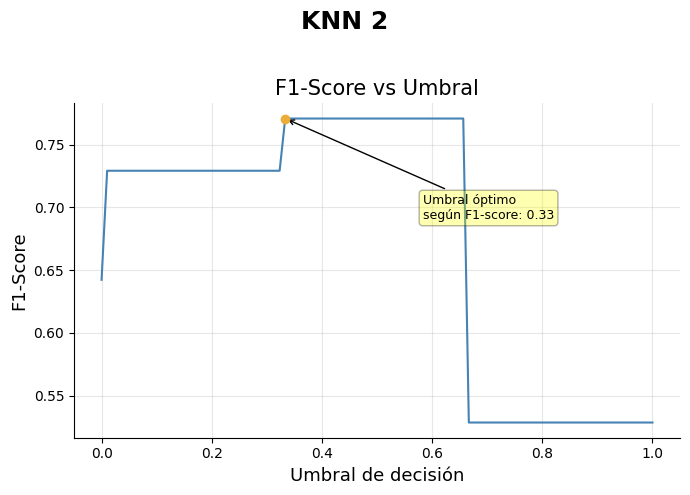

In [202]:
umbral_knn_1 = plot_umbrales(modelo=knn_2.best_estimator_,
                             score='F1-Score',
                             x=X_linear_cv[selected_features],
                             y=y_linear_cv,
                             caja_x=0.25,
                             caja_y=0.08,
                             nombre='KNN 2')

In [203]:
knn_2_results_umbral = metricas_evaluacion(modelo=knn_2.best_estimator_,
                                    x_test=X_linear_test[selected_features],
                                    y_test=y_linear_test,
                                    nombre='KNN 2',
                                    conjunto='X_linear[selected_features]',
                                    umbral=0.33)

knn_results_tracking.append(knn_2_results_umbral)
pd.DataFrame(knn_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,KNN 1,X_linear,0.6881,0.4642,0.5591,0.5072,0.7064,0.50
1,KNN 1,X_linear,0.5853,0.3922,0.8083,0.5282,0.7064,0.29
2,KNN 2,X_linear[selected_features],0.6752,0.4508,0.6006,0.5151,0.6728,0.50
3,KNN 2,X_linear[selected_features],0.4991,0.3469,0.8435,0.4916,0.6728,0.33


El modelo `KNN 2`, entrenado únicamente con las variables seleccionadas `por LogisticRegression 5`, presentó un desempeño inferior al anterior, ya que, si bien su **Recall** aumenta al modificar el umbral de decisión, el resto de métricas cae drásticamente.

Esto indica que reducir la dimensionalidad en el caso de KNN perjudica significativamente su desempeño, probablemente porque este tipo de modelo se beneficia de tener más dimensiones para calcular la distancia entre observaciones.

Sin embargo, `K-Nearest Neighbors` **no logró un rendimiento general competitivo**, pero aún así se lo conservará como el modelo representativo de esta familia para las comparaciones finales.

## <font color='#ebac3a'>**Conclusiones K-Nearest Neighbors (KNN)**</font>

El modelo **K-Nearest Neighbors** no consigue mejorar en las métricas de las familias anteriores. Especialmente en **Recall**, con aproximadamente 9% menor a la **Regresión Logística** seleccionada, con una **Precisión** similar


Dado que este modelo no consigue un buen desempeño y que también presenta desventajas computacionales para su implementación en producción, se concluye que no resulta ser una alternativa superadora frente a otras arquitecturas evaluadas.

Aún así, se conservará `KNN 1` para las evaluaciones finales.

In [204]:
best_models.append(knn_1_results_umbral)
pd.DataFrame(best_models)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Baseline Model,X,0.6523,0.4406,0.7827,0.5639,0.7238,0.41
1,KNN 1,X_linear,0.5853,0.3922,0.8083,0.5282,0.7064,0.29


In [205]:
with open('best_knn.pkl', 'wb') as f:
    pickle.dump(knn_1.best_estimator_, f)

## <font color='#ebac3a'>**XGBoost Classifier**</font>

**XGBoost** es un algoritmo de machine learning basado en **árboles de decisión**. Construye múltiples árboles simples de forma **secuencial**, donde cada nuevo árbol intenta **corregir los errores** cometidos por los anteriores. De esta manera, cada iteración mejora progresivamente el desempeño del modelo.

Una de las razones por las que XGBoost es tan utilizado es que es **rápido**, **eficiente**, **maneja distintos tipos de datos** (incluyendo transformaciones automáticas mediante hiperparámetros), y suele lograr **muy buenos resultados**. Además, incluye múltiples mecanismos para **controlar el sobreajuste**, entre los cuales se destacan:

* **`max_depth`**: Limita la profundidad de los árboles, ayudando a evitar modelos demasiado complejos.
* **`min_child_weight`**: Controla la cantidad mínima de observaciones necesarias para dividir una hoja; al aumentarlo, se evita que el modelo haga divisiones poco significativas.
* **`reg_alpha` (L1 regularization)**: Penaliza el uso excesivo de variables, ayudando a simplificar el modelo.
* **`early_stopping`**: Detiene el entrenamiento si la métrica de evaluación (como **binary log loss**) no mejora luego de un número determinado de iteraciones.
* **`learning_rate`** (también `eta`): Controla el tamaño del paso de actualización. Un valor más bajo hace que el modelo aprenda más lentamente, pero reduce el riesgo de sobreajuste.

Además, este modelo es robusto frente al manejo de escalas y outliers, por lo que no es necesario reescalar las variables.

In [206]:
xgb_results_tracking = []

### <font color='#f07c3e'>**XGB Classifier 1 - Max Depth = 10 - Conjunto X**</font>

### ***Nota:***

Dado que XGBoost ofrece una gran cantidad de hiperparámetros que pueden ajustarse, se comenzará con un modelo base utilizando algunos valores por defecto (exceptuando max_depth, que se establece en 10). Luego, se aplicará GridSearchCV para optimizar algunos de los hiperparámetros más relevantes en función del problema y la métrica prioritaria (recall).

In [207]:
xgb_1 = XGBClassifier(max_depth=10, random_state=42, early_stopping_rounds=5, eval_metric='logloss')

xgb_1.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [208]:
xgb_1_results = metricas_evaluacion(modelo=xgb_1,
                                    x_test=X_test,
                                    y_test=y_test,
                                    nombre='XGB Classifier 1',
                                    conjunto='X')




xgb_results_tracking.append(xgb_1_results)
pd.DataFrame(xgb_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,XGB Classifier 1,X,0.7505,0.5541,0.6709,0.6069,0.7917,0.5


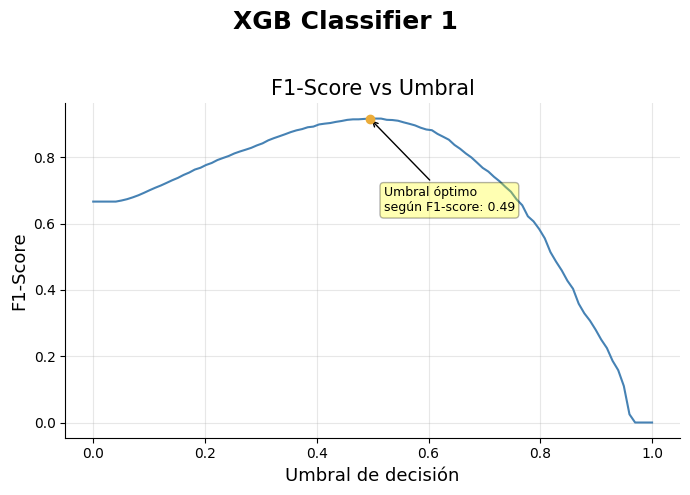

In [209]:
umbral_xgb_1 = plot_umbrales(modelo=xgb_1,
                             score='F1-Score',
                             x=X_train,
                             y=y_train,
                             caja_x=0.025,
                             caja_y=0.28,
                             nombre='XGB Classifier 1')

In [210]:
xgb_1_results_umbral = metricas_evaluacion(modelo=xgb_1,
                                            x_test=X_test,
                                            y_test=y_test,
                                            nombre='XGB Classifier 1',
                                            conjunto='X',
                                            umbral=0.46)




xgb_results_tracking.append(xgb_1_results_umbral)
pd.DataFrame(xgb_results_tracking)

,Model,Dataset,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,XGB Classifier 1,X,0.7505,0.5541,0.6709,0.6069,0.7917,0.50
1,XGB Classifier 1,X,0.7367,0.5308,0.7157,0.6095,0.7917,0.46


### <font color='#8b5fc4'>**Observaciones: XGB Classifier 1 - Max depth = 10 - Conjunto X**</font>

El modelo `XGB Classifier 1` (base de esta familia) muestra una estabilidad similar a la familia de **Random Forest**, donde los valores de **Recall** no son tan elevados, pero la precisión se mantiene por encima de **0.5**.

Al modificar el umbral de decisión, se obtiene una mejora de aproximadamente **5.4%** con un trade-off en **Precisión** de **2.09%**, lo cual resulta aceptable ya que la mejora en sensibilidad rempresenta más del doble de la caida en precisión.

A continuación se realizará un `GridSearchCV` con el objetivo de optimizar los hiperparámetros del modelo, en busca de mejorar sus métricas.

### <font color='#f07c3e'>**XGB Classifier 2 - GridSearchCV - Conjunto X**</font>

In [211]:
param_grid = {
    'max_depth': [10, 15, 20],
    'min_child_weight': [2, 5],
    'reg_alpha': [0.8, 1.0, 1.2],
    'gamma': [0, 0.1, 0.2, 0.5],
    'learning_rate': [0.001, 0.01, 0.1]
}


xgb_gs = XGBClassifier(random_state=42, early_stopping_rounds=5, eval_metric='logloss', n_estimators=1000)

xgb_2 = GridSearchCV(xgb_gs, param_grid=param_grid, scoring='recall', cv=skf)

fit_params =  {'eval_set': [(X_val, y_val)], 'verbose': False}

xgb_2.fit(X_train, y_train, **fit_params)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=5,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_pol...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=1000,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'gamma': [0, 0.1, 0.2, 0.5],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [10, 15, 20], 'min_child_weight': [2, 5],
                         'reg_alpha': [0.8, 1.0, 1.2]},
             scoring='recall')

In [ ]:
xgb_2.best_params_

In [ ]:
xgb_2_results = metricas_evaluacion(modelo=xgb_2.best_estimator_,
                                    x_test=X_test,
                                    y_test=y_test,
                                    nombre='XGB Classifier 2',
                                    conjunto='X')

xgb_results_tracking.append(xgb_2_results)
pd.DataFrame(xgb_results_tracking)

In [ ]:
umbral_xgb_2 = plot_umbrales(modelo=xgb_2.best_estimator_,
                             score='F1-Score',
                             x=X_train,
                             y=y_train,
                             caja_x=-0.1,
                             caja_y=0.28,
                             nombre='XGB Classifier 2')

In [ ]:
xgb_2_results_umbral = metricas_evaluacion(modelo=xgb_2.best_estimator_,
                                    x_test=X_test,
                                    y_test=y_test,
                                    nombre='XGB Classifier 2',
                                    conjunto='X',
                                    umbral=0.45)




xgb_results_tracking.append(xgb_2_results_umbral)
pd.DataFrame(xgb_results_tracking)

### <font color='#8b5fc4'>**Observaciones: XGB Classifier 2 - GridSearchCV - n_estimators=1000, early_stopping=5**</font>

El ajuste de los hiperparámetros inicialmente produce una leve mejora en todas las métricas del modelo:

|Modelo               | Conjunto    | Accuracy  | Precision | Recall    | F1-Score  | AUC      | Umbral  |
|---------------------|-------------|-----------|-----------|-----------|-----------|----------|---------|
|XGB Classifier 1	  | X	        | 0.7400	| 0.5232	| 0.6835	| 0.5927	| 0.7923   | 0.50    |
|XGB Classifier 2	  | X	        | 0.7549	| 0.5455	| 0.6869	| 0.6080	| 0.8054   | 0.50    |


Utilizado el umbral de decisión óptimo determinado por la métrica F1-Score, esta diferencia se hace más notable:


|Modelo               | Conjunto    | Accuracy  | Precision | Recall    | F1-Score  | AUC      | Umbral  |
|---------------------|-------------|-----------|-----------|-----------|-----------|----------|---------|
|XGB Classifier 1	  | X	        | 0.7251	| 0.5023	| 0.7475	| 0.6008	| 0.7923   | 0.46    |
|XGB Classifier 2	  | X	        | 0.7288	| 0.5066	| 0.7744	| 0.6125	| 0.8054   | 0.45    |

Se sigue observando la estabilidad que presentan los modelos con arquitecturas de árbol. Los valores observados en **Recall** no alcanzan los niveles obtenidos por el modelo de **Regresión Logística**, sin embargo, este tipo de arquitectura incurre en menor cantidad de errores positivos, es decir, clasifica menos cantida de clientes que no abandonan como evasión (`Churn=1`).

Sin embargo, a pesar de ser un modelo que suele mostrar muy buen desempeño, el ajuste de hiperparámetros de `XGB Classifier 2` no consigue superar al modelo representativo de la anterior familia con arquitectura de árboles.

|Modelo               | Conjunto    | Accuracy  | Precision | Recall    | F1-Score  | AUC      | Umbral  |
|---------------------|-------------|-----------|-----------|-----------|-----------|----------|---------|
|RandomForest 5	      | X	        | 0.7409	| 0.5208	| 0.8013	| 0.6313	| 0.8326   | 0.44    |
|XGB Classifier 2	  | X	        | 0.7288	| 0.5066	| 0.7744	| 0.6125	| 0.8054   | 0.45    |

### <font color='#f07c3e'>**XGB Classifier 3 - GridSearchCV - n_estimators=2000, early_stopping=10**</font>

In [ ]:
param_grid = {
    'max_depth': [6, 10, 15],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'learning_rate': [0.01, 0.05, 0.1]
}



xgb_gs = XGBClassifier(n_estimators=2000, early_stopping_rounds=10, eval_metric='logloss', random_state=42)

fit_params = {"eval_set": [(X_val, y_val)], "verbose": False}

xgb_3 = GridSearchCV(estimator=xgb_gs, param_grid=param_grid, scoring='recall', cv=skf)

xgb_3.fit(X_train, y_train, **fit_params)

In [ ]:
xgb_3.best_params_

In [ ]:
xgb_3_results = metricas_evaluacion(modelo=xgb_3.best_estimator_,
                                    x_test=X_test,
                                    y_test=y_test,
                                    nombre='XGB Classifier 3',
                                    conjunto='X')

xgb_results_tracking.append(xgb_3_results)
pd.DataFrame(xgb_results_tracking)

In [ ]:
umbral_xgb_3 = plot_umbrales(modelo=xgb_3.best_estimator_,
                             score='F1-Score',
                             x=X_train,
                             y=y_train,
                             caja_x=-0.1,
                             caja_y=0.28,
                             nombre='XGB Classifier 3')

In [ ]:
xgb_3_results_umbral = metricas_evaluacion(modelo=xgb_3.best_estimator_,
                                            x_test=X_test,
                                            y_test=y_test,
                                            nombre='XGB Classifier 3',
                                            conjunto='X',
                                            umbral=0.43)

xgb_results_tracking.append(xgb_3_results_umbral)
pd.DataFrame(xgb_results_tracking)

In [ ]:
pd.DataFrame(best_models)

Esta segunda exploración con GridSearchCV, presentó mejoras en todas las métricas, especialmente en la métrica prioritaria (**Recall**)

```
param_grid = {
    'max_depth': [6, 10, 15],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'learning_rate': [0.01, 0.05, 0.1]
}
```
Los hiperparámetros seleccionados como óptimos fueron:

* `max_depth=6`: controla la profundidad de los árboles
* `min_child_weight=1`: cantidad mínima de peso necesaria para dividir un nodo. Mientras más alto, más complejo es el modelo y menos sobreajuste. Sin embargo, GridSearch utilizó el valor mínimo ofrecido.
* `gamma=0.1`: ganancia mínima para hacer una división (reducción de la función objetivo, en este caso, `logloss`
* `subsample=0.8`: porcentaje de muestras de entrenamiento usadas por cada arbol. Esto ayuda a introducir aleatoriedad, ya que el modelo selecciona al azar, para este caso, 80% de las observaciones del conjunto de entrenamiento.
* `colsample_bytree=0.6`: porcentaje de columnas utilizadas por cada arbol. `XGB Classifier 3` al entrenar utilizó el 60% de las columnas presentes en el conjunto X_train.
* `reg_alpha=0`: penaliza el uso excesivo de variables, llevando los coeficientes de aquellas que considera irrelevantes a 0.
* `learning_rate=0.1`: variación en los parámetros del modelo por cada iteración de entrenamiento.

Esta configuración, permitió al modelo `XGB Classifier 3` obtener un resultado similar a `RandomForest 5`:

|Modelo               | Conjunto    | Accuracy  | Precision | Recall    | F1-Score  | AUC      | Umbral  |
|---------------------|-------------|-----------|-----------|-----------|-----------|----------|---------|
|RandomForest 5	      | X	        | 0.7409	| 0.5208	| 0.8013	| 0.6313	| 0.8326   | 0.44    |
|XGB Classifier 3	  | X	        | 0.7307	| 0.5085	| 0.8047	| 0.6232	| 0.8188   | 0.43    |

Por lo que este se conservará como representante de esta familia.

## <font color='#ebac3a'>**Conclusiones XGBoost Classifier**</font>

A pesar de su complejidad y buen rendimiento en otros contextos, el modelo `XGBoost Classifier` **no demostró un desempeño superior** en el problema en cuestión en relación a los otros modelos.

Si bien en esencia opera mediante **árboles de decisión**, por lo que su comportamiento fue similar al de `Random Forest Classifier`, se observó que la **complejidad agregada no aporta mejoras significativas en la capacidad del modelo para separar las clases** de manera efectiva.

Una posible razón puede ser la limitada cantidad de datos disponibles, lo que dificulta al modelo para aprender patrones complejos en los datos.

Como se mencionó anteriormente: cuando no es necesario agregar complejidad, **no debemos hacerlo**.  

In [ ]:
best_models.append(xgb_3_results_umbral)
pd.DataFrame(best_models)

In [ ]:
try:
    with open('best_xgb.pkl', 'wb') as f:
        pickle.dump(xgb_3.best_estimator_, f)
except Exception as e:
    with open('best_xgb.pkl', 'wb') as f:
        pickle.dump(xgb_3, f)

## <font color='#ebac3a'>**Support Vector Machine**</font>

**Support Vector Machine (SVM)** es un algoritmo supervisado que busca encontrar la **frontera de decisión óptima** que **separe las clases** de un conjunto de datos, maximizando la **distancia (margen)** entre dicha frontera y los puntos más cercanos de cada clase, llamados **vectores de soporte**.

Aunque se basa en distancias, **la frontera de decisión no depende de todos los puntos**, sino **solo de aquellos vectores de soporte**. Cuanto **más amplio sea el margen**, mejor será la capacidad de **generalización** del modelo; sin embargo, esto puede generar **errores de clasificación**. Por el contrario, **márgenes más estrechos** pueden sobreajustarse al conjunto de entrenamiento.

El **parámetro `C`** controla este equilibrio:
* Un `C` **alto** penaliza fuertemente los errores → modelo más estricto, menor margen, mayor riesgo de sobreajuste.
* Un `C` **bajo** permite más errores → modelo más permisivo, mayor margen, posible subajuste.

Además, **SVM permite transformar los datos automáticamente** mediante el uso de **funciones kernel**, con el objetivo de encontrar **una frontera lineal en un espacio transformado**, incluso si los datos no son separables linealmente en su espacio original.

In [ ]:
svm_results_tracking = []

In [ ]:

svm_1 = SVC(kernel='sigmoid', gamma='auto', C=1.0, random_state=42, probability=True)

svm_1_cv_results = cross_validate(svm_1, X_scaled_cv, y_scaled_cv, cv=skf)

In [ ]:
cv_score_interval(svm_1_cv_results, nombre='SVM 1', score='Recall')

In [ ]:
svm_1.fit(X_scaled_cv, y_scaled_cv)

In [ ]:
svm_1_results = metricas_evaluacion(modelo=svm_1,
                                    x_test=X_scaled_test,
                                    y_test=y_scaled_test,
                                    nombre='SVM 1',
                                    conjunto='X_scaled')

svm_results_tracking.append(svm_1_results)
pd.DataFrame(svm_results_tracking)

In [ ]:
umbral_svm_1 = plot_umbrales(modelo=svm_1,
                             score='F1-Score',
                             x=X_scaled_cv,
                             y=y_scaled_cv,
                             caja_x=0.25,
                             caja_y=0.08,
                             nombre='SVM 1')

In [ ]:
svm_1_results_umbral = metricas_evaluacion(modelo=svm_1,
                                            x_test=X_scaled_test,
                                            y_test=y_scaled_test,
                                            nombre='SVM 1',
                                            conjunto='X_scaled',
                                            umbral=0.31)

svm_results_tracking.append(svm_1_results_umbral)
pd.DataFrame(svm_results_tracking)

### <font color='#8b5fc4'>**Observaciones: SVM 1 - kernel=sigmoid**</font>

El primer modelo `Support Vector Machine` fue entrenado utilizando el **kernel de tipo `sigmoid`**, obteniendo los siguientes resultados:


| Modelo     | Conjunto    | Accuracy | Precision  | Recall   |F1-score   | AUC    | Umbral |
|------------|-------------|----------|------------|----------|-----------|--------|--------|
| SVM 1	     | X_scaled	   | 0.7530	  | 0.5530	   | 0.5623	  | 0.5576	  | 0.7918 | 0.50   |

Al modificar su umbral de decisión en el punto óptimo determinado por la métrica **F1-Score** sobre los datos de entrenamiento, se obtiene:

| Modelo     | Conjunto    | Accuracy | Precision  | Recall   |F1-score   | AUC    | Umbral |
|------------|-------------|----------|------------|----------|-----------|--------|--------|
| SVM 1      | X_scaled	   | 0.5098	  | 0.3563	   | 0.9562	  | 0.5192	  | 0.7918 | 0.31   |

Si bien la métrica prioritaria (**Recall**) resulta altamente competitiva, se observa una fuerte disminución en Accuracy y Precision, esto indica que el modelo alcanza un desempeño óptimo para su consideración como representante de la familia.
A continuación se llevará a cabo una búsqueda de hiperparámetros (`GridSearchCV`) para encontrar una **combinación óptima de `kernel`, `C` y `gamma`**, con el objetivo de mejorar tanto la sensibilidad como el equilibrio general del modelo.

### <font color='#f07c3e'>**SVM 2 - GridSearchCV - Conjunto X_scaled**</font>

In [ ]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.7, 1.0, 1.5, 2.0],
    'gamma': ['auto', 'scale']
}

svm_2 = GridSearchCV(SVC(random_state=42, probability=True), param_grid=param_grid, scoring='recall', cv=skf)


svm_2.fit(X_scaled_cv, y_scaled_cv)

In [ ]:
svm_2.best_params_

In [ ]:
svm_2_results = metricas_evaluacion(modelo=svm_2.best_estimator_,
                                    x_test=X_scaled_test,
                                    y_test=y_scaled_test,
                                    nombre='SVM 2',
                                    conjunto='X_scaled')

svm_results_tracking.append(svm_2_results)
pd.DataFrame(svm_results_tracking)

In [ ]:
umbral_svm_2 = plot_umbrales(modelo=svm_2.best_estimator_,
                             score='F1-Score',
                             x=X_scaled_cv,
                             y=y_scaled_cv,
                             caja_x=0.25,
                             caja_y=0.08,
                             nombre='SVM 2')

In [ ]:
svm_2_results_umbral = metricas_evaluacion(modelo=svm_2,
                                            x_test=X_scaled_test,
                                            y_test=y_scaled_test,
                                            nombre='SVM 2',
                                            conjunto='X_scaled',
                                            umbral=0.12)

svm_results_tracking.append(svm_2_results_umbral)
pd.DataFrame(svm_results_tracking)

### <font color='#8b5fc4'>**Observaciones: SVM 2 - GridSearchCV - Conjunto X_scaled**</font>

Inicialmente es posible observar que el ajuste en los hiperparámetros produjo una disminución en todas las métricas excepto por una leve mejora en **Recall**.

El modelo muestra un valor de **AUC** aproximadamente **7.3% más bajo**. Lo que indica que este no es capaz de separar las clases desbalanceadas mejor que el modelo anterior.

Además, el umbral de decisión que maximiza la métrica F1-score en los datos de entrenamiento (clases balanceadas) es extremadamente bajo, lo que hace que, para identificar casi el 100% de clientes que abandonan, la capacidad del modelo de identificar correctamente a los clientes que no planean abandonar la empresa se reduzca demasiado.

### <font color='#f07c3e'>**SVM 3 - GridSearchCV - kernel='linear' - Conjunto X_linear**</font>

Se entrenará un tercer modelo de esta familia utilizando el conjunto X_linear, y forzando el uso de `kernel=linear`. Ya que al trabajar con distancia, este modelo puede entrar en conflictos al manejar la multicolinealidad presente en el conjunto `X_scaled` donde se utilizo una codificación `one_hot_encoder(drop='if_binary')`.

In [ ]:
param_grid = {
    'kernel': ['linear'],
    'C': [0.7, 1.0, 1.5, 2.0],
    'gamma': ['auto', 'scale']
}

svm_3 = GridSearchCV(SVC(random_state=42, probability=True), param_grid=param_grid, scoring='recall', cv=skf)


svm_3.fit(X_linear_cv, y_linear_cv)

In [ ]:
svm_3.best_params_

In [ ]:
svm_3_results = metricas_evaluacion(modelo=svm_3.best_estimator_,
                                    x_test=X_linear_test,
                                    y_test=y_linear_test,
                                    nombre='SVM 3',
                                    conjunto='X_linear')

svm_results_tracking.append(svm_3_results)
pd.DataFrame(svm_results_tracking)

In [ ]:
umbral_svm_3 = plot_umbrales(modelo=svm_3.best_estimator_,
                             score='F1-Score',
                             x=X_linear_cv,
                             y=y_linear_cv,
                             caja_x=0.25,
                             caja_y=0.08,
                             nombre='SVM 3')

In [ ]:
svm_3_results_umbral = metricas_evaluacion(modelo=svm_3.best_estimator_,
                                            x_test=X_linear_test,
                                            y_test=y_linear_test,
                                            nombre='SVM 3',
                                            conjunto='X_linear',
                                            umbral=0.33)

svm_results_tracking.append(svm_3_results_umbral)
pd.DataFrame(svm_results_tracking)

In [ ]:
pd.DataFrame(best_models)

### <font color='#8b5fc4'>**Observaciones: SVM 3 - GridSearchCV - kernel='linear' - Conjunto X_linear**</font>

El modelo `SVM 3` consigue superar al resto de modelos dentro de esta familia.

Se comprueba que al utilizar el conjunto `X_linear`, este se beneficia de la codificación `one_hot_encoder(drop='first')`, la cual evita la introducción manual de multicolinealidad al conjunto de datos.

Aún así, este no consigue mejorar la estabilidad presente en las otras familias de algoritmos, como `Random Forest` y `Linear Regression`.

## <font color='#ebac3a'>**Conclusiones Support Vector Machine**</font>

El algoritmo de **Support Vector Machine** consiguió alcanzar el **Recall** más alto entre todos los modelos entrenados. Utilizando los hiperparámetros adecuados, y un conjunto de datos preprocesado apropiadamente para dicho modelo, este logra maximizar la métrica prioritaria para el problema de negocios, aún manteniendo una buena estabilidad en términos general##

In [ ]:
best_models.append(svm_3_results_umbral)
pd.DataFrame(best_models)

In [ ]:

try:
    with open('best_svm.pkl', 'wb') as f:
        pickle.dump(svm_3.best_estimator_, f)
except Exception:
    with open('best_svm.pkl', 'wb') as f:
        pickle.dump(svm_3, f)

# <font color='#5a9bd4'>**5. Evaluación Best Models**</font>

A continuación se llevarán a cabo distintas evaluaciones sobre los modelos seleccionados como representantes de cada familia.

El objetivo es analizar distintos aspectos del desempeño de estos para determinar cual presenta las mejores condiciones para entornos productivos.

In [ ]:

with open('best_randomforest.pkl', 'rb') as f:
    random_forest = pickle.load(f)

with open('best_logreg.pkl', 'rb') as f:
    log_reg = pickle.load(f)

with open('best_knn.pkl', 'rb') as f:
    knn = pickle.load(f)

with open('best_xgb.pkl', 'rb') as f:
    xgb = pickle.load(f)

with open('best_svm.pkl', 'rb') as f:
    svm = pickle.load(f)

In [ ]:
with open('features_best_logreg.pkl', 'rb') as f:
    selected_features = pickle.load(f)
selected_features

## <font color='#ebac3a'>**Métricas Generales y Umbrales de Decisión**</font>

### <font color='#f07c3e'>**Métricas Generales**</font>

In [ ]:
random_forest_eval = metricas_evaluacion(random_forest,
                                         X_test,
                                         y_test,
                                         nombre='Best Random Forest',
                                         conjunto='X')

log_reg_eval = metricas_evaluacion(log_reg,
                                   X_linear_test[selected_features],
                                   y_linear_test,
                                   nombre='Best Logistic Regression',
                                   conjunto='X_linear[selected_features]')

knn_eval = metricas_evaluacion(knn,
                               X_linear_test,
                               y_linear_test,
                               nombre='Best K-Nearest Neighbors',
                               conjunto='X_linear')

xgb_eval = metricas_evaluacion(xgb,
                               X_test,
                               y_test,
                               nombre='Best XGBoost Classifier',
                               conjunto='X')



svm_eval = metricas_evaluacion(svm,
                               X_linear_test,
                               y_linear_test,
                               nombre='Best Support Vector Machine',
                               conjunto='X_linear')


metricas_eval = [random_forest_eval, log_reg_eval, knn_eval, xgb_eval, svm_eval]

pd.DataFrame(metricas_eval)

### <font color='#f07c3e'>**Umbrales de decisión**</font>

In [ ]:
modelos = [random_forest, log_reg, knn, xgb, svm]

nombres = ['Best Random Forest',
           'Best Linear Regression',
           'Best K-Nearest Neighbors',
           'Best XGB Classifier',
           'Best Support Vector Machine']

X_conjuntos = [X_test,
               X_linear_test[selected_features],
               X_linear_test,
               X_test,
               X_linear_test]

y_conjuntos = [y_test,
               y_linear_test,
               y_linear_test,
               y_test,
               y_linear_test]

nombres_conjuntos = ['X',
                     'X_linear[selected_features]',
                     'X_linear',
                     'X',
                     'X_linear']

rango_umbrales = np.round(np.linspace(0.45, 0.31, 15), 2)

resultados_umbrales = []

for i, modelo in enumerate(modelos):
    for umbral in rango_umbrales:
        resultado_umbral = metricas_evaluacion(modelo=modelo,
                                               x_test = X_conjuntos[i],
                                               y_test = y_conjuntos[i],
                                               nombre=nombres[i],
                                               conjunto=nombres_conjuntos[i],
                                               umbral=umbral)

        if resultado_umbral['Recall'] > 0.9:
            resultados_umbrales.append(resultado_umbral)
            break

pd.DataFrame(resultados_umbrales)

In [ ]:
rango_umbrales = np.round(np.linspace(0.45, 0.31, 15), 2)

resultados_umbrales = []

for i, modelo in enumerate(modelos):
    for umbral in rango_umbrales:
        resultado_umbral = metricas_evaluacion(modelo=modelo,
                                               x_test = X_conjuntos[i],
                                               y_test = y_conjuntos[i],
                                               nombre=nombres[i],
                                               conjunto=nombres_conjuntos[i],
                                               umbral=umbral)

        if resultado_umbral['Recall'] > 0.85:
            resultados_umbrales.append(resultado_umbral)
            break

pd.DataFrame(resultados_umbrales)

In [ ]:
rango_umbrales = np.round(np.linspace(0.45, 0.31, 15), 2)

resultados_umbrales = []

for i, modelo in enumerate(modelos):
    for umbral in rango_umbrales:
        resultado_umbral = metricas_evaluacion(modelo=modelo,
                                               x_test = X_conjuntos[i],
                                               y_test = y_conjuntos[i],
                                               nombre=nombres[i],
                                               conjunto=nombres_conjuntos[i],
                                               umbral=umbral)

        if resultado_umbral['Recall'] > 0.8:
            resultados_umbrales.append(resultado_umbral)
            break

pd.DataFrame(resultados_umbrales)

In [ ]:
rango_umbrales = np.round(np.linspace(0.45, 0.31, 15), 2)

resultados_umbrales = []

for i, modelo in enumerate(modelos):
    for umbral in rango_umbrales:
        resultado_umbral = metricas_evaluacion(modelo=modelo,
                                               x_test = X_conjuntos[i],
                                               y_test = y_conjuntos[i],
                                               nombre=nombres[i],
                                               conjunto=nombres_conjuntos[i],
                                               umbral=umbral)

        if resultado_umbral['Recall'] > 0.85:
            resultados_umbrales.append(resultado_umbral)
            break

pd.DataFrame(resultados_umbrales)

### ***Nota***:

Dado que el modelo `K-Nearest Neighbors` no consiguío alcanzar el **Recall** esperado dentro del rango de umbrales establecido, se descartará.
Su valor de AUC inferior a 0.8 es un indicador de que este modelo no consigue manejar la clasificación de clases tan bien como el resto

In [ ]:
metricas_eval.pop(2)

In [ ]:
#metricas_diff = [metricas_val, metricas_eval]
recall = []
precision = []

for metrica in metricas_eval:
    modelo_rec = {}
    modelo_prec = {}
    for key, value in metrica.items():

        if key == 'Model':
            modelo_rec[key] = value
            modelo_prec[key] = value
        if key == 'Recall':
            modelo_rec['Recall (Umbral=0.5)'] = value
        if key == 'Precision':
            modelo_prec['Precision (Umbral=0.5)'] = value

    recall.append(modelo_rec)
    precision.append(modelo_prec)

for i, metrica in enumerate(resultados_umbrales):
    modelo_rec = recall[i]
    modelo_prec = precision[i]
    for key, value in metrica.items():
        if key == 'Recall':
            name = 'Recall (Umbral modificado)'
            modelo_rec[name] = value
        if key == 'Precision':
            name = 'Precision (Umbral modificado)'
            modelo_prec[name] = value

In [ ]:
df_recall_diff = pd.DataFrame(recall)
df_precision_diff = pd.DataFrame(precision)

In [ ]:
diff = (df_recall_diff["Recall (Umbral modificado)"] - df_recall_diff["Recall (Umbral=0.5)"])
df_recall_diff['Variación'] = diff.apply(lambda x: f'{x * 100:.2f}%')

diff = (df_precision_diff["Precision (Umbral modificado)"] - df_precision_diff["Precision (Umbral=0.5)"])
df_precision_diff['Variación'] = diff.apply(lambda x: f'{x * 100:.2f}%')

In [ ]:
df_recall_diff

In [ ]:
df_precision_diff

In [ ]:
generar_tabla(df_recall_diff,
              title='Modificación de umbrales - Variación Recall',
              save='recall_diff',
              figsize=(9,4))

In [ ]:
generar_tabla(df_precision_diff,
              title='Modificacion de umbrales - Variacion Precision',
              save='precision_diff',
              figsize=(9,4))

## <font color='#ebac3a'>**Conclusiones Métricas Generales y Umbrales de Decisión**</font>

Al evaluar las métricas de los modelos seleccionados como representantes de cada familia, se observa que el modelo `Best Random Forest` es el que mejor maneja el desbalance de clases. Este alcanza un valor de **AUC = 0.8326**, lo que indica que, si se seleccionan aleatoriamente un caso positivo (Churn = 1) y uno negativo (Churn = 0), el modelo tiene un **83.26% de probabilidad** de asignar una puntuación mayor al caso positivo.  
Esta métrica refleja la capacidad del modelo para discriminar entre ambas clases sin depender de un umbral específico, lo cual resulta especialmente valioso en contextos con clases desbalanceadas.

Sin modificar el umbral de decisión (por defecto en 0.5), `Best Random Forest` también presenta los valores más altos de **Recall** y **F1-score**, lo que refuerza su rendimiento y estabilidad general.

| Modelo                       | Dataset                      | Accuracy | Precision | Recall | F1-score | AUC    | Umbral |
|------------------------------|------------------------------|----------|-----------|--------|----------|--------|--------|
| Best Random Forest           | X                            | 0.7698   | 0.5654    | 0.7273 | 0.6362   | 0.8326 | 0.5    |
| Best Logistic Regression     | X_linear[selected_features]  | 0.7633   | 0.5657    | 0.6229 | 0.5929   | 0.8137 | 0.5    |
| Best K-Nearest Neighbors     | X_linear                     | 0.7251   | 0.5027    | 0.6364 | 0.5617   | 0.7513 | 0.5    |
| Best XGBoost Classifier      | X                            | 0.7568   | 0.5464    | 0.7138 | 0.6190   | 0.8188 | 0.5    |
| Best Support Vector Machine  | X_linear                     | 0.7540   | 0.5563    | 0.5488 | 0.5525   | 0.8073 | 0.5    |

Dado que el objetivo de negocio es **reducir el abandono de clientes**, se prioriza que el modelo sea capaz de **identificar correctamente la mayor cantidad de abandonos**. Para lograr esto, se exploraron distintos **umbrales de decisión** que permitieran maximizar la sensibilidad (**Recall**), manteniendo valores aceptables de **Precisión** y **F1-score**, de modo que las campañas de retención sean efectivas y, al mismo tiempo, rentables.

Los **umbrales entre 0.38 y 0.39** permitieron alcanzar valores de **Recall superiores a 0.85**, con una **Precisión** en el rango de **0.45 a 0.50**.

| Modelo                       | Dataset                      | Accuracy | Precision | Recall | F1-score | AUC    | Umbral |
|------------------------------|------------------------------|----------|-----------|--------|----------|--------|--------|
| Best Random Forest           | X                            | 0.7148   | 0.4914    | 0.8620 | 0.6259   | 0.8326 | 0.39   |
| Best Logistic Regression     | X_linear[selected_features]  | 0.6747   | 0.4539    | 0.8620 | 0.5947   | 0.8137 | 0.39   |
| Best XGBoost Classifier      | X                            | 0.6925   | 0.4695    | 0.8552 | 0.6062   | 0.8188 | 0.38   |
| Best Support Vector Machine  | X_linear                     | 0.6785   | 0.4571    | 0.8620 | 0.5974   | 0.8073 | 0.38   |

Aún con estas modificaciones en el umbral, el modelo `Best Random Forest` continúa mostrando las métricas más equilibradas y robustas.
Si observamos las variaciones en la métrica prioritaria (**Recall**), este presenta la menor variación necesaria para alcanzar el valor esperado.

| Model	                       | Recall (Umbral=0.5)  | Recall (Umbral modificado)	| Variación |
|------------------------------|----------------------|-----------------------------|-----------|
| Best Random Forest	       | 0.7273	              | 0.8620	                    | 13.47%    |
| Best Logistic Regression	   | 0.6229	              | 0.8620	                    | 23.91%    |
| Best XGBoost Classifier	   | 0.7138	              | 0.8552	                    | 14.14%    |
| Best Support Vector Machine  | 0.5488	              | 0.8620	                    | 31.32%    |


Esto se traduce en la menor caída en **Precisión** para alcanzar dicho objetivo:


| Model	                       | Precision (Umbral=0.5)  | Precision (Umbral modificado)	| Variación |
|------------------------------|-------------------------|----------------------------------|-----------|
| Best Random Forest	       | 0.5654     	         | 0.4914	                        | -7.40%    |
| Best Logistic Regression	   | 0.5657	                 | 0.4539                           | -11.18%   |
| Best XGBoost Classifier	   | 0.5464      	         | 0.4695	                        | -7.69%    |
| Best Support Vector Machine  | 0.5563	                 | 0.4571	                        | -9.92%    |


Esto lo postula como **candidato principal (Champion Model)** para su implementación en entornos productivos, al ofrecer un buen compromiso entre sensibilidad y precisión, clave para una estrategia efectiva de retención de clientes.

## <font color='#ebac3a'>**Subajuste (Underfitting) y Subajuste (Overfitting)**</font>

In [ ]:
random_forest_train = metricas_evaluacion(random_forest, X_cv, y_cv, 'Best Random Forest', conjunto='X')
log_reg_train = metricas_evaluacion(log_reg, X_linear_cv[selected_features],
                                    y_linear_cv, 'Best Logistic Regression', conjunto='X_linear[selected_features]')
xgb_train = metricas_evaluacion(xgb, X_cv, y_cv, 'Best XGBoost Classifier', conjunto='X')
svm_train = metricas_evaluacion(svm, X_linear_cv, y_linear_cv, 'Best Support Vector Machine', conjunto='X_linear')
metricas_train = [random_forest_train, log_reg_train, xgb_train, svm_train]

pd.DataFrame(metricas_train)

In [ ]:
#metricas_diff = [metricas_val, metricas_eval]
recall = []
f1 = []

for metrica in metricas_train:
    modelo_rec = {}
    modelo_f1 = {}
    for key, value in metrica.items():

        if key == 'Model':
            modelo_rec[key] = value
            modelo_f1[key] = value
        if key == 'Recall':
            modelo_rec['Recall Train'] = value
        if key == 'F1-score':
            modelo_f1['F1-score Train'] = value

    recall.append(modelo_rec)
    f1.append(modelo_f1)

for i, metrica in enumerate(metricas_eval):
    modelo_rec = recall[i]
    modelo_f1 = f1[i]
    for key, value in metrica.items():
        if key == 'Recall':
            modelo_rec['Recall Test'] = value
        if key == 'F1-score':
            modelo_f1['F1-score Test'] = value

In [ ]:
for modelo in recall:
    diff = np.round(modelo['Recall Test'] - modelo['Recall Train'], 4)
    modelo['Variación'] = f'{diff * 100:.2f}%'

for modelo in f1:
    diff = np.round(modelo['F1-score Test'] - modelo['F1-score Train'], 4)
    modelo['Variación'] = f'{diff * 100:.2f}%'

df_recall_diff = pd.DataFrame(recall)
df_f1_diff = pd.DataFrame(f1)

In [ ]:
generar_tabla(df_recall_diff,
              title='Variación de Recall',
              save='recall_train_test',
              figsize=(9,4))

In [ ]:
generar_tabla(df_f1_diff,
              title='Variación de F1-score',
              save='f1_train_test',
              figsize=(9,4))

In [ ]:
df_recall_diff

In [ ]:
df_f1_diff

## <font color='#ebac3a'>**Conclusiones: Subajuste (Underfitting) y Sobreajuste (Overfitting)**</font>

#### <font color='#8b5fc4'>**Subajuste (Underfitting)**</font>

En cuanto a este aspecto, ninguno de los modelos mostró un subajuste (underfitting), ya que durante el entrenamiento todos alcanzan un desempeño aceptable en sus métricas:

| Model	                       | Dataset	                 | Accuracy	  | Precision   | Recall	| F1-score	 | AUC	   | Umbral |
|------------------------------|-----------------------------|------------|-------------|-----------|------------|---------|--------|
| Best Random Forest	       | X	                         | 0.8659	  | 0.8580	    | 0.8769	| 0.8673	 | 0.9481  | 0.5    |
| Best Logistic Regression	   | X_linear[selected_features] | 0.6252	  | 0.6220	    | 0.6383	| 0.6301	 | 0.6809  | 0.5    |
| Best XGBoost Classifier	   | X	                         | 0.7603	  | 0.7628	    | 0.7555	| 0.7591	 | 0.8515  | 0.5    |
| Best Support Vector Machine  | X_linear	                 | 0.6208	  | 0.6261	    | 0.5996	| 0.6126	 | 0.6784  | 0.5    |

Al observar el valor del **Accuracy** (ya que los datos de entrenamiento han sido balanceados), es posible ver que todos superan al menos el **60%**, lo que indica que no hacen predicciones al azar, sino que han logrado aprender relaciones útiles entre las variables.

### <font color='#8b5fc4'>**Sobreajuste (Overfitting)**</font>

#### <font color='#e9611d'>**Best Random Forest**</font>

El modelo `Best Random Forest` presenta un fuerte sobreajuste. Durante el entrenamiento, sus métricas tienen un promedio general de 0.87, mientras que al evaluarlo en el conjunto de prueba, estas disminuyen significativamente:

| Métrica            | Train	     |  Test	       | Variación  |
|--------------------|---------------|-----------------|------------|
| Recall	         | 0.8769	     | 0.7273	       | -14.96%    |
| F1-score           | 0.8673	     | 0.6362	       | -23.11%    |

A pesar de este comportamiento, sigue siendo el modelo que mejor separa las clases en el conjunto de prueba, lo que indica que ha capturado patrones relevantes, aunque también podría beneficiarse de una mayor regularización.


#### <font color='#e9611d'>**Best Logistic Regression**</font>

`Best Logistic Regression` se muestra como el modelo más estable. Sus métricas se mantienen bastante similares tanto en entrenamiento como en prueba:

| Métrica            | Train	     |  Test	      | Variación  |
|--------------------|---------------|----------------|------------|
| Recall	         | 0.6383	     | 0.6229	      | -1.54%     |
| F1-score           | 0.6301	     | 0.5929	      | -3.72%     |

Sin embargo, para alcanzar un **Recall** aceptable ajustando el umbral de decisión, este modelo requiere un mayor **sacrificio en Precisión**, lo cual podría impactar la eficiencia de las acciones derivadas.


#### <font color='#e9611d'>**Best XGB Classifier**</font>

El modelo `Best XGB Classifier` también muestra indicios de sobreajuste, especialmente en la métrica **F1-score**. Esto confirma que las arquitecturas basadas en árboles, aunque potentes, tienden a memorizar patrones de entrenamiento:

| Métrica            | Train	     |  Test	      | Variación  |
|--------------------|---------------|----------------|------------|
| Recall             | 0.7555	     | 0.7138	      | -4.17%     |
| F1-score           | 0.7591	     | 0.6190	      | -14.01%    |

A pesar de la caída, el modelo sigue manteniendo una capacidad de predicción razonable sobre datos no vistos.

#### <font color='#e9611d'>**Best Support Vector Machine**</font>

`Best Support Vector Machine` presenta las métricas más bajas en general. Si bien las diferencias entre entrenamiento y prueba no son elevadas, los valores en ambas etapas rondan el 0.58:

| Métrica            | Train	     |  Test	      | Variación  |
|--------------------|---------------|----------------|------------|
| Recall	         | 0.5996	     | 0.5488	      | -5.08%     |
| F1-score           | 0.6126	     | 0.5525	      | -6.01%     |

Esto sugiere que, a diferencia de lo que se observó durante el entrenamiento, este no logra capturar patrones relevantes cuando es evaluado con datos no vistos *(test dataset)*, posiblemente debido a su naturaleza lineal frente a un problema con relaciones más complejas.

## <font color='#ebac3a'>**Best Models Confusion Matrices**</font>

En la exploración de umbrales de decisión, se determinó que un escenario "idoneo", era conseguir que los modelos pudieran identificar el 85% de los casos de clientes que deciden abandonar la empresa.

Para ello, inevitablemente es necesario una compensación en la intervención de clientes que no tienen probabilidades de cancelar sus servicios.

A través de las matrices de confusión, es posible observar "cuantos clientes serán intervenidos erroneamente" al utilizar cada uno de los modelos seleccionados.